In [380]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following_signal import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance as perf
import position_sizing as size
import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size)

<module 'position_sizing' from '/Users/adheerchauhan/Documents/git/trend_following/position_sizing.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper functions to help pull the data and run the analysis

### Moving Average and Donchian Channels Signals

In [6]:
def plot_portfolio_trend_following_performance(df, start_date, end_date, rolling_sharpe_window):
    
    start_date = pd.to_datetime(start_date).date().strftime('%Y-%m-%d')
    end_date = pd.to_datetime(end_date).date().strftime('%Y-%m-%d')
    fig = plt.figure(figsize=(15,8))
    layout = (2,2)
    trend_rolling_sharpe_ax = plt.subplot2grid(layout, (0,0), colspan=2)
    portfolio_value_ax = trend_rolling_sharpe_ax.twinx()
    trend_return_ax = plt.subplot2grid(layout, (1,0), colspan=2)
    trend_cum_return_ax = trend_return_ax.twinx()
    # trend_cum_return_ax = plt.subplot2grid(layout, (1,1))#, colspan=2)s

    _ = trend_rolling_sharpe_ax.plot(df.index, df[f'portfolio_rolling_sharpe_{rolling_sharpe_window}'], label='Sharpe Ratio', color='orange')
    _ = portfolio_value_ax.plot(df.index, df[f'total_portfolio_value'], label='Portfolio Value', color='blue')    
    _ = trend_rolling_sharpe_ax.set_title(f'Portfolio Rolling Sharpe Ratio')
    _ = trend_rolling_sharpe_ax.set_ylabel('Sharpe Ratio')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = trend_rolling_sharpe_ax.set_xlabel('Date')
    _ = trend_rolling_sharpe_ax.legend(loc='upper left')
    _ = portfolio_value_ax.legend(loc='upper right')
    _ = trend_rolling_sharpe_ax.grid()

    _ = trend_return_ax.plot(df.index, df[f'portfolio_daily_pct_returns'], label='Return', color='magenta')
    _ = trend_cum_return_ax.plot(df.index, df['portfolio_strategy_cumulative_return'], label='Cum. Return', color='green')
    _ = trend_return_ax.set_title(f'Trend Strategy with Donchian Channel Portfolio Return')
    _ = trend_return_ax.set_ylabel('Return')
    _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    _ = trend_return_ax.set_xlabel('Date')
    _ = trend_return_ax.legend(loc='upper left')
    _ = trend_cum_return_ax.legend(loc='upper right')
    _ = trend_return_ax.grid()

    # _ = trend_cum_return_ax.plot(df_trend_mavg_donchian.index, df_trend_mavg_donchian[f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_cum'], label='Cum. Return')
    # _ = trend_cum_return_ax.plot(df.index, df['portfolio_strategy_cumulative_return'], label='Cum. Return')
    # _ = trend_cum_return_ax.set_title(f'Trend Strategy with Donchian Channel Portfolio Cumulative Return')
    # _ = trend_cum_return_ax.set_ylabel('Cum. Return')
    # _ = trend_cum_return_ax.set_xlabel('Date')
    # _ = trend_cum_return_ax.legend(loc='upper left')
    # _ = trend_cum_return_ax.grid()


    plt.tight_layout()
    
    return

In [ ]:
from strategy_performance_metrics import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance(df_performance, ticker):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'{ticker} Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'{ticker} Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'{ticker} Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='price',
                                                rolling_donchian_window=20, long_only=False, use_coinbase_data=True):
    
    # Pull Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, 
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close']].rename(columns={'close':ticker}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]

    # Generate Trend Signal
    df_trend = (tf.create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))
    # Generate Donchian Channels
    df_donchian = tf.calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                            rolling_donchian_window=rolling_donchian_window, use_coinbase_data=use_coinbase_data)

    # Donchian Buy signal: Price crosses above upper band
    # Donchian Sell signal: Price crosses below lower band
    df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
        (df_donchian[f'close'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
        np.where((df_donchian[f'close'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']), -1, 0))

    # Merging the Trend and Donchian Dataframes
    donchian_cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}',
                     f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_signal']
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    # Trend and Donchian Channel Signal
    buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                  (df_trend[f'{ticker}_trend_signal'] == 1))
    sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                   (df_trend[f'{ticker}_trend_signal'] == -1))

    # Generate Long Only Signal
    if long_only:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, 0))
    # Generate Long & Short Signal
    else:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, np.where(sell_signal, -1, 0)))
        
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')] * 
        df_trend[f'{ticker}_pct_returns'])
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')].diff())
    
    return df_trend

def moving_avg_crossover_with_donchian_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='price',
                                                           rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    perf_cols = ['ticker', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    fast_mavg_list = np.arange(10, 101, 10)
    slow_mavg_list = np.arange(50, 501, 50)
    mavg_stepsize_list = [2, 4, 6, 8]
    performance_rows = []
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for mavg_stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df_trend = generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type, price_or_returns_calc,
                                                                         rolling_donchian_window, include_signal_strength, long_only, use_coinbase_data)
                    performance_metrics = calculate_risk_and_performance_metrics(
                        df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                        strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                        annual_trading_days=365, transaction_cost_est=0.005)
                    performance_rows.append({
                        'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': mavg_stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    })
                    # df_performance = df_performance.append(row, ignore_index=True)
    # Convert the list of rows to a DataFrame
    df_performance = pd.DataFrame(performance_rows, columns=perf_cols)
    
    plot_moving_avg_crossover_performance(df_performance, ticker)
    
    return df_performance

In [ ]:
import coinbase_utils as 

In [372]:
client = cn.get_coinbase_rest_api_client(cn.key_location)

In [378]:
client.

<bound method get_market_trades of <coinbase.rest.RESTClient object at 0x30e751400>>

In [374]:
client.get_candles(product_id='BTC-USD', start=

'organizations/11fd9c53-c569-4606-aa70-275fed1976f3/apiKeys/0f9f2448-9d7c-4186-a7e3-9e15fd6cbbf7'

In [ ]:
candle_list = client.get_candles(
                product_id=ticker,
                start=start_timestamp,
                end=end_timestamp,
                granularity=granularity
            ).candles

In [362]:
temp_date = '2025-02-19'

In [370]:
pd.to_datetime(temp_date)

Timestamp('2025-02-19 00:00:00')

In [368]:
int(pd.to_datetime(temp_date).timestamp())

1739923200

In [ ]:
start_timestamp = int(temp_start_date.timestamp())
end_timestamp = int(current_end_date.timestamp())

# Position Sizing Strategies

In [ ]:
## In Sample Performance
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2023, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2024, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2026, 1, 31).date()
full_sample_start_date = in_sample_start_date
full_sample_end_date = out_of_sample_end_date

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
moving_avg_type = 'exponential'
price_or_returns_calc = 'price'
rolling_donchian_window = 20
ticker_dict = cn.coinbase_start_date_by_ticker_dict

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
moving_avg_type = 'exponential'
price_or_returns_calc = 'price'
rolling_donchian_window = 20
ticker_dict = cn.coinbase_start_date_by_ticker_dict
# ticker='BTC-USD'

perf_cols = ['ticker', 'start_date', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
            'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_performance = pd.DataFrame(columns=perf_cols)

for ticker in ticker_dict.keys():
    print(ticker)
    if pd.to_datetime(ticker_dict[ticker]).date() > in_sample_end_date:
        pass
    elif in_sample_start_date < pd.to_datetime(ticker_dict[ticker]).date():
        df_trend = generate_trend_signal_with_donchian_channel(start_date=pd.to_datetime(ticker_dict[ticker]).date(), end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                               mavg_stepsize=mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc,
                                                               rolling_donchian_window=rolling_donchian_window)
        performance_metrics = perf.calculate_risk_and_performance_metrics(
            df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
            strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades', passive_trade_rate=0.05,
            annual_trading_days=365)
        row = {
            'ticker': ticker,
            'start_date': ticker_dict[ticker],
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    else:
        df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                               mavg_stepsize=mavg_stepsize, moving_avg_type=moving_avg_type, price_or_returns_calc=price_or_returns_calc,
                                                               rolling_donchian_window=rolling_donchian_window)
        performance_metrics = perf.calculate_risk_and_performance_metrics(
            df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
            strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades', passive_trade_rate=0.05,
            annual_trading_days=365)
        row = {
            'ticker': ticker,
            'start_date': ticker_dict[ticker],
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        df_performance = pd.concat([df_performance, pd.DataFrame([row])], ignore_index=True)
    # performance_metrics = perf.calculate_risk_and_performance_metrics(
    #     df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
    #     strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades', passive_trade_rate=0.05,
    #     annual_trading_days=365)
    

In [ ]:
df_performance

In [ ]:
print(f'Annualized Return: {df_performance['annualized_return'].mean()}')
print(f'Sharpe Ratio: {df_performance['sharpe_ratio'].mean()}')

## Position Sizing Strategy Comparison

In [136]:
## In Sample Performance
in_sample_start_date = pd.Timestamp(2019, 1, 1).date()
in_sample_end_date = pd.Timestamp(2023, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2024, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2026, 1, 31).date()
full_sample_start_date = in_sample_start_date
full_sample_end_date = out_of_sample_end_date
signal_start_date = pd.Timestamp(2022, 1, 1).date()

In [138]:
stop_loss_multiple = 1
risk_per_trade = 0.02
long_only = True
df_atr_long = size.apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                     use_specific_start_date=True, signal_start_date=signal_start_date)

In [142]:
df_atr_long.count_of_positions.sum()#head()

44.0

In [154]:
df_atr_long.portfolio_trade_count.sum()#head()

370.0

In [156]:
df_atr_long.iloc[pd.Timestamp('2019.head()

,BTC-USD,BTC-USD_20_avg_true_range_price,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_account_risk,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_close,BTC-USD_event,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_trade_risk,ETH-USD,ETH-USD_20_avg_true_range_price,ETH-USD_50_6_250_mavg_crossover_20_donchian_signal,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,ETH-USD_account_risk,ETH-USD_actual_position_entry_price,ETH-USD_actual_position_exit_price,ETH-USD_actual_position_notional,ETH-USD_actual_size,ETH-USD_close,ETH-USD_event,ETH-USD_short_sale_proceeds,ETH-USD_t_1_close,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_trade_risk,LTC-USD,LTC-USD_20_avg_true_range_price,LTC-USD_50_6_250_mavg_crossover_20_donchian_signal,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,LTC-USD_account_risk,LTC-USD_actual_position_entry_price,LTC-USD_actual_position_exit_price,LTC-USD_actual_position_notional,LTC-USD_actual_size,LTC-USD_close,LTC-USD_event,LTC-USD_short_sale_proceeds,LTC-USD_t_1_close,LTC-USD_target_notional,LTC-USD_target_size,LTC-USD_trade_risk,SOL-USD,SOL-USD_20_avg_true_range_price,SOL-USD_50_6_250_mavg_crossover_20_donchian_signal,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,SOL-USD_account_risk,SOL-USD_actual_position_entry_price,SOL-USD_actual_position_exit_price,SOL-USD_actual_position_notional,SOL-USD_actual_size,SOL-USD_close,SOL-USD_event,SOL-USD_short_sale_proceeds,SOL-USD_t_1_close,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_trade_risk,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50,strategy_cumulative_return,strategy_cumulative_return_cum_max,strategy_cumulative_return_drawdown,strategy_cumulative_return_drawdown_pct,End,Start,strategy_cumulative_return_DDDuration,profitable_trade
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-11,3635.69,195.721922,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3635.69,0,0.0,3626.12,0.0,0.0,0.0,125.83,11.780256,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,125.83,0,0.0,126.41,0.0,0.0,0.0,31.79,3.364260,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.79,0,0.0,33.27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-11,1,1587 days,False
2019-01-12,3619.41,188.890311,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,3619.41,0,0.0,3635.69,0.0,0.0,0.0,124.59,11.334517,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,124.59,0,0.0,125.83,0.0,0.0,0.0,32.04,3.356235,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.04,0,0.0,31.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-12,1,1587 days,False
2019-01-13,3514.24,179.652186,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,3514.24,0,0.0,3619.41,0.0,0.0,0.0,115.58,10.624563,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.58,0,0.0,124.59,0.0,0.0,0.0,29.92,3.142308,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.92,0,0.0,32.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2019-01-13,1,1587 days,False
2019-01-14,3664.19,177.811025,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3664.19,0,0.0,3514.24,0.0,0.0,0.0,128.37,10.727938,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.37,0,0.0,115.58,0.0,0.0,0.0,32.07,3.163993,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.07

In [158]:
df_atr_long[['portfolio_trade_count','count_of_positions']]

,portfolio_trade_count,count_of_positions
date,,
2019-01-11,0.0,0.0
2019-01-12,0.0,0.0
2019-01-13,0.0,0.0
2019-01-14,0.0,0.0
2019-01-15,0.0,0.0
2019-01-16,0.0,0.0
2019-01-17,0.0,0.0
2019-01-18,0.0,0.0
2019-01-19,0.0,0.0


In [160]:
perf.calculate_risk_and_performance_metrics(df_atr_long, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)

{'annualized_return': 0.059612570961254274,
 'annualized_sharpe_ratio': 0.28642737547361313,
 'calmar_ratio': 0.0798214632771001,
 'annualized_std_dev': 0.03379097866649915,
 'max_drawdown': -0.7468238305067061,
 'max_drawdown_duration': Timedelta('1587 days 00:00:00'),
 'hit_rate': 0.018722466960352423,
 't_statistic': 3.8597512067077187,
 'p_value': 0.00011747529875849449,
 'trade_count': 44.0}

In [144]:
stop_loss_multiple = 1
risk_per_trade = 0.02
df_std_long = size.apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                     use_specific_start_date=True, signal_start_date=signal_start_date)

In [145]:
df_std_long.count_of_positions.sum()#head()

44.0

In [146]:
ann_target_vol = 0.40
df_tv_long = size.apply_target_volatility_position_sizing_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window, long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                          volatility_window=volatility_window, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                          rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=np.round(ann_target_vol, 2),
                                                          annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)

In [147]:
df_tv_long.count_of_positions.sum()#head()

42.0

In [162]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only=True
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_atr_long = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = size.apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                     use_specific_start_date=True, signal_start_date=signal_start_date)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        
        df_results_atr_long = pd.concat([df_results_atr_long, pd.DataFrame([row])], ignore_index=True)

df_results_atr_long['strategy_name'] = f'ATLO_' + df_results_atr_long['risk_per_trade'].astype(str) + '_' + df_results_atr_long['stop_loss_multiple'].astype(str)

Risk Per Trade: 0.01 with Stop Loss Multiple: 1
Risk Per Trade: 0.01 with Stop Loss Multiple: 2
Risk Per Trade: 0.01 with Stop Loss Multiple: 3
Risk Per Trade: 0.01 with Stop Loss Multiple: 4
Risk Per Trade: 0.02 with Stop Loss Multiple: 1
Risk Per Trade: 0.02 with Stop Loss Multiple: 2
Risk Per Trade: 0.02 with Stop Loss Multiple: 3
Risk Per Trade: 0.02 with Stop Loss Multiple: 4
Risk Per Trade: 0.03 with Stop Loss Multiple: 1
Risk Per Trade: 0.03 with Stop Loss Multiple: 2
Risk Per Trade: 0.03 with Stop Loss Multiple: 3
Risk Per Trade: 0.03 with Stop Loss Multiple: 4
Risk Per Trade: 0.04 with Stop Loss Multiple: 1
Risk Per Trade: 0.04 with Stop Loss Multiple: 2
Risk Per Trade: 0.04 with Stop Loss Multiple: 3
Risk Per Trade: 0.04 with Stop Loss Multiple: 4
Risk Per Trade: 0.05 with Stop Loss Multiple: 1
Risk Per Trade: 0.05 with Stop Loss Multiple: 2
Risk Per Trade: 0.05 with Stop Loss Multiple: 3
Risk Per Trade: 0.05 with Stop Loss Multiple: 4
CPU times: user 5min 11s, sys: 17.2 s, t

In [163]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only=False
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_atr_long_short = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = size.apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                     use_specific_start_date=True, signal_start_date=signal_start_date)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        
        df_results_atr_long_short = pd.concat([df_results_atr_long_short, pd.DataFrame([row])], ignore_index=True)

df_results_atr_long_short['strategy_name'] = f'ATLS_' + df_results_atr_long_short['risk_per_trade'].astype(str) + '_' + df_results_atr_long_short['stop_loss_multiple'].astype(str)

Risk Per Trade: 0.01 with Stop Loss Multiple: 1
Risk Per Trade: 0.01 with Stop Loss Multiple: 2
Risk Per Trade: 0.01 with Stop Loss Multiple: 3
Risk Per Trade: 0.01 with Stop Loss Multiple: 4
Risk Per Trade: 0.02 with Stop Loss Multiple: 1
Risk Per Trade: 0.02 with Stop Loss Multiple: 2
Risk Per Trade: 0.02 with Stop Loss Multiple: 3
Risk Per Trade: 0.02 with Stop Loss Multiple: 4
Risk Per Trade: 0.03 with Stop Loss Multiple: 1
Risk Per Trade: 0.03 with Stop Loss Multiple: 2
Risk Per Trade: 0.03 with Stop Loss Multiple: 3
Risk Per Trade: 0.03 with Stop Loss Multiple: 4
Risk Per Trade: 0.04 with Stop Loss Multiple: 1
Risk Per Trade: 0.04 with Stop Loss Multiple: 2
Risk Per Trade: 0.04 with Stop Loss Multiple: 3
Risk Per Trade: 0.04 with Stop Loss Multiple: 4
Risk Per Trade: 0.05 with Stop Loss Multiple: 1
Risk Per Trade: 0.05 with Stop Loss Multiple: 2
Risk Per Trade: 0.05 with Stop Loss Multiple: 3
Risk Per Trade: 0.05 with Stop Loss Multiple: 4
CPU times: user 5min 15s, sys: 19.9 s, t

In [164]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only = True
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_std_long = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = size.apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                     use_specific_start_date=True, signal_start_date=signal_start_date)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        
        df_results_std_long = pd.concat([df_results_std_long, pd.DataFrame([row])], ignore_index=True)

df_results_std_long['strategy_name'] = f'STLO_' + df_results_std_long['risk_per_trade'].astype(str) + '_' + df_results_std_long['stop_loss_multiple'].astype(str)

Risk Per Trade: 0.01 with Stop Loss Multiple: 1
Risk Per Trade: 0.01 with Stop Loss Multiple: 2
Risk Per Trade: 0.01 with Stop Loss Multiple: 3
Risk Per Trade: 0.01 with Stop Loss Multiple: 4
Risk Per Trade: 0.02 with Stop Loss Multiple: 1
Risk Per Trade: 0.02 with Stop Loss Multiple: 2
Risk Per Trade: 0.02 with Stop Loss Multiple: 3
Risk Per Trade: 0.02 with Stop Loss Multiple: 4
Risk Per Trade: 0.03 with Stop Loss Multiple: 1
Risk Per Trade: 0.03 with Stop Loss Multiple: 2
Risk Per Trade: 0.03 with Stop Loss Multiple: 3
Risk Per Trade: 0.03 with Stop Loss Multiple: 4
Risk Per Trade: 0.04 with Stop Loss Multiple: 1
Risk Per Trade: 0.04 with Stop Loss Multiple: 2
Risk Per Trade: 0.04 with Stop Loss Multiple: 3
Risk Per Trade: 0.04 with Stop Loss Multiple: 4
Risk Per Trade: 0.05 with Stop Loss Multiple: 1
Risk Per Trade: 0.05 with Stop Loss Multiple: 2
Risk Per Trade: 0.05 with Stop Loss Multiple: 3
Risk Per Trade: 0.05 with Stop Loss Multiple: 4
CPU times: user 5min 14s, sys: 17.7 s, t

In [165]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only = False
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_std_long_short = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = size.apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                    use_specific_start_date=True, signal_start_date=signal_start_date)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        
        df_results_std_long_short = pd.concat([df_results_std_long_short, pd.DataFrame([row])], ignore_index=True)

df_results_std_long_short['strategy_name'] = f'STLS_' + df_results_std_long_short['risk_per_trade'].astype(str) + '_' + df_results_std_long_short['stop_loss_multiple'].astype(str)

Risk Per Trade: 0.01 with Stop Loss Multiple: 1
Risk Per Trade: 0.01 with Stop Loss Multiple: 2
Risk Per Trade: 0.01 with Stop Loss Multiple: 3
Risk Per Trade: 0.01 with Stop Loss Multiple: 4
Risk Per Trade: 0.02 with Stop Loss Multiple: 1
Risk Per Trade: 0.02 with Stop Loss Multiple: 2
Risk Per Trade: 0.02 with Stop Loss Multiple: 3
Risk Per Trade: 0.02 with Stop Loss Multiple: 4
Risk Per Trade: 0.03 with Stop Loss Multiple: 1
Risk Per Trade: 0.03 with Stop Loss Multiple: 2
Risk Per Trade: 0.03 with Stop Loss Multiple: 3
Risk Per Trade: 0.03 with Stop Loss Multiple: 4
Risk Per Trade: 0.04 with Stop Loss Multiple: 1
Risk Per Trade: 0.04 with Stop Loss Multiple: 2
Risk Per Trade: 0.04 with Stop Loss Multiple: 3
Risk Per Trade: 0.04 with Stop Loss Multiple: 4
Risk Per Trade: 0.05 with Stop Loss Multiple: 1
Risk Per Trade: 0.05 with Stop Loss Multiple: 2
Risk Per Trade: 0.05 with Stop Loss Multiple: 3
Risk Per Trade: 0.05 with Stop Loss Multiple: 4
CPU times: user 5min, sys: 14.5 s, total

In [166]:
%%time
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = True

perf_cols = ['annualized_target_volatility','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_target_vol_long = pd.DataFrame(columns=perf_cols)
for ann_target_vol in np.arange(0.05, 0.76, 0.05):
    print(f'Annualized Target Volatility: {np.round(ann_target_vol,2)}')
    df = size.apply_target_volatility_position_sizing_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window, long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                          volatility_window=volatility_window, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                          rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=np.round(ann_target_vol, 2),
                                                          annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)
    performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                      annual_trading_days=365, include_transaction_costs_and_fees=False)
    row = {
        'annualized_target_volatility': np.round(ann_target_vol,2),
        'fast_mavg': fast_mavg,
        'slow_mavg': slow_mavg,
        'stepsize': mavg_stepsize,
        'annualized_return': performance_metrics['annualized_return'],
        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
        'calmar_ratio': performance_metrics['calmar_ratio'],
        'annualized_std_dev': performance_metrics['annualized_std_dev'],
        'max_drawdown': performance_metrics['max_drawdown'],
        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
        'hit_rate': performance_metrics['hit_rate'],
        't_statistic': performance_metrics['t_statistic'],
        'p_value': performance_metrics['p_value'],
        'trade_count': performance_metrics['trade_count']
    }

    df_results_target_vol_long = pd.concat([df_results_target_vol_long, pd.DataFrame([row])], ignore_index=True)
df_results_target_vol_long['strategy_name'] = f'TVLO_' + df_results_target_vol_long['annualized_target_volatility'].astype(str)

Annualized Target Volatility: 0.05
Annualized Target Volatility: 0.1
Annualized Target Volatility: 0.15
Annualized Target Volatility: 0.2
Annualized Target Volatility: 0.25
Annualized Target Volatility: 0.3
Annualized Target Volatility: 0.35
Annualized Target Volatility: 0.4
Annualized Target Volatility: 0.45
Annualized Target Volatility: 0.5
Annualized Target Volatility: 0.55
Annualized Target Volatility: 0.6
Annualized Target Volatility: 0.65
Annualized Target Volatility: 0.7
Annualized Target Volatility: 0.75
CPU times: user 2min 47s, sys: 6.65 s, total: 2min 54s
Wall time: 26min 39s


In [167]:
%%time
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = False

perf_cols = ['annualized_target_volatility','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_target_vol_long_short = pd.DataFrame(columns=perf_cols)
for ann_target_vol in np.arange(0.05, 0.76, 0.05):
    print(f'Annualized Target Volatility: {np.round(ann_target_vol,2)}')
    df = size.apply_target_volatility_position_sizing_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window, long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                          volatility_window=volatility_window, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                          rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=np.round(ann_target_vol, 2),
                                                          annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)
    performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='count_of_positions',
                                                                      annual_trading_days=365, include_transaction_costs_and_fees=False)
    row = {
        'annualized_target_volatility': np.round(ann_target_vol,2),
        'fast_mavg': fast_mavg,
        'slow_mavg': slow_mavg,
        'stepsize': mavg_stepsize,
        'annualized_return': performance_metrics['annualized_return'],
        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
        'calmar_ratio': performance_metrics['calmar_ratio'],
        'annualized_std_dev': performance_metrics['annualized_std_dev'],
        'max_drawdown': performance_metrics['max_drawdown'],
        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
        'hit_rate': performance_metrics['hit_rate'],
        't_statistic': performance_metrics['t_statistic'],
        'p_value': performance_metrics['p_value'],
        'trade_count': performance_metrics['trade_count']
    }

    df_results_target_vol_long_short = pd.concat([df_results_target_vol_long_short, pd.DataFrame([row])], ignore_index=True)
df_results_target_vol_long_short['strategy_name'] = f'TVLS_' + df_results_target_vol_long_short['annualized_target_volatility'].astype(str)

Annualized Target Volatility: 0.05
Annualized Target Volatility: 0.1
Annualized Target Volatility: 0.15
Annualized Target Volatility: 0.2
Annualized Target Volatility: 0.25
Annualized Target Volatility: 0.3
Annualized Target Volatility: 0.35
Annualized Target Volatility: 0.4
Annualized Target Volatility: 0.45
Annualized Target Volatility: 0.5
Annualized Target Volatility: 0.55
Annualized Target Volatility: 0.6
Annualized Target Volatility: 0.65
Annualized Target Volatility: 0.7
Annualized Target Volatility: 0.75
CPU times: user 2min 48s, sys: 6.65 s, total: 2min 55s
Wall time: 27min 6s


In [174]:
df_results_atr_long

,risk_per_trade,stop_loss_multiple,fast_mavg,slow_mavg,stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,strategy_name
0,0.01,1,50,250,6,0.054764,0.159053,0.067446,0.031564,-0.811978,1587 days,0.018722,3.802843,0.000148,44.0,ATLO_0.01_1
1,0.01,2,50,250,6,0.028045,-1.280010,0.029845,0.016406,-0.939700,1587 days,0.018722,3.778960,0.000163,44.0,ATLO_0.01_2
2,0.01,3,50,250,6,0.018673,-2.761679,0.019882,0.010947,-0.939219,1587 days,0.018722,3.781993,0.000161,44.0,ATLO_0.01_3
3,0.01,4,50,250,6,0.013996,-4.243979,0.014906,0.008214,-0.938978,1587 days,0.018722,3.783511,0.000160,44.0,ATLO_0.01_4
4,0.02,1,50,250,6,0.059613,0.286427,0.079821,0.033791,-0.746824,1587 days,0.018722,3.859751,0.000117,44.0,ATLO_0.02_1
5,0.02,2,50,250,6,0.054764,0.159053,0.067446,0.031564,-0.811978,1587 days,0.018722,3.802843,0.000148,44.0,ATLO_0.02_2
6,0.02,3,50,250,6,0.037441,-0.539807,0.039824,0.021855,-0.940181,1587 days,0.018722,3.775930,0.000165,44.0,ATLO_0.02_3
7,0.02,4,50,250,6,0.028045,-1.280010,0.029845,0.016406,-0.939700,1587 days,0.018722,3.778960,0.000163,44.0,ATLO_0.02_4
8,0.03,1,50,250,6,0.059613,0.286427,0.079821,0.033791,-0.746824,1587 days,0.018722,3.859751,0.000117,44.0,ATLO_0.03_1
9,0.03,2,50,250,6,0.059613,0.286427,0.079821,0.033791,-0.746824,1587 days,0.018722,3.859751,0.000117,44.0,ATLO_0.03_2


In [176]:
df_results_std_long

,risk_per_trade,stop_loss_multiple,fast_mavg,slow_mavg,stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,strategy_name
0,0.01,1,50,250,6,0.060344,0.299152,0.089437,0.034769,-0.674709,1587 days,0.018722,3.797556,0.000151,44.0,STLO_0.01_1
1,0.01,2,50,250,6,0.044386,-0.186919,0.054909,0.026787,-0.808350,1587 days,0.018722,3.646131,0.000274,44.0,STLO_0.01_2
2,0.01,3,50,250,6,0.029545,-1.091606,0.036153,0.017879,-0.817210,1587 days,0.018722,3.652479,0.000267,44.0,STLO_0.01_3
3,0.01,4,50,250,6,0.022138,-1.998095,0.027102,0.013416,-0.816851,1587 days,0.018722,3.655438,0.000264,44.0,STLO_0.01_4
4,0.02,1,50,250,6,0.060344,0.299152,0.089437,0.034769,-0.674709,1587 days,0.018722,3.797556,0.000151,44.0,STLO_0.02_1
5,0.02,2,50,250,6,0.060344,0.299152,0.089437,0.034769,-0.674709,1587 days,0.018722,3.797556,0.000151,44.0,STLO_0.02_2
6,0.02,3,50,250,6,0.055586,0.179170,0.082386,0.032539,-0.674709,1587 days,0.018722,3.744481,0.000186,44.0,STLO_0.02_3
7,0.02,4,50,250,6,0.044386,-0.186919,0.054909,0.026787,-0.808350,1587 days,0.018722,3.646131,0.000274,44.0,STLO_0.02_4
8,0.03,1,50,250,6,0.060344,0.299152,0.089437,0.034769,-0.674709,1587 days,0.018722,3.797556,0.000151,44.0,STLO_0.03_1
9,0.03,2,50,250,6,0.060344,0.299152,0.089437,0.034769,-0.674709,1587 days,0.018722,3.797556,0.000151,44.0,STLO_0.03_2


In [178]:
df_results_target_vol_long

,annualized_target_volatility,fast_mavg,slow_mavg,stepsize,annualized_return,sharpe_ratio,calmar_ratio,annualized_std_dev,max_drawdown,max_drawdown_duration,hit_rate,t_statistic,p_value,trade_count,strategy_name
0,0.05,50,250,6,0.033384,-1.167834,0.041185,0.013582,-0.810596,669 days,0.037862,3.803317,0.000152,44.0,TVLO_0.05
1,0.10,50,250,6,0.067423,0.620904,0.083068,0.027096,-0.811658,669 days,0.037862,3.798494,0.000155,44.0,TVLO_0.1
2,0.15,50,250,6,0.102126,1.215221,0.125659,0.040547,-0.812720,669 days,0.037862,3.793654,0.000158,44.0,TVLO_0.15
3,0.20,50,250,6,0.137503,1.510923,0.168968,0.053940,-0.813783,669 days,0.037862,3.788801,0.000161,44.0,TVLO_0.2
4,0.25,50,250,6,0.173565,1.687174,0.213004,0.067279,-0.814845,669 days,0.037862,3.783942,0.000165,44.0,TVLO_0.25
5,0.30,50,250,6,0.210321,1.803698,0.257775,0.080568,-0.815907,669 days,0.037862,3.779080,0.000168,44.0,TVLO_0.3
6,0.35,50,250,6,0.249647,1.908567,0.305577,0.093473,-0.816970,669 days,0.036748,3.812417,0.000147,43.0,TVLO_0.35
7,0.40,50,250,6,0.267487,1.919214,0.326988,0.100694,-0.818032,669 days,0.035635,3.770399,0.000174,42.0,TVLO_0.4
8,0.45,50,250,6,0.303061,1.966474,0.369995,0.113000,-0.819095,669 days,0.035635,3.761756,0.000180,41.0,TVLO_0.45
9,0.50,50,250,6,0.323355,1.944448,0.394260,0.122795,-0.820157,669 days,0.030067,3.673182,0.000254,36.0,TVLO_0.5


In [180]:
## ATR Long Only Results
df_results_atr_long_trim = df_results_atr_long.drop_duplicates(subset=['sharpe_ratio'], keep='first')
atr_long_dupes_cond = ((df_results_atr_long_trim['risk_per_trade'] == 0.03) & (df_results_atr_long_trim['stop_loss_multiple'] == 3))
df_results_atr_long_trim = df_results_atr_long_trim[~atr_long_dupes_cond]

## ATR Long-Short Results
df_results_atr_long_short_trim = df_results_atr_long_short.drop_duplicates(subset=['sharpe_ratio'], keep='first')
atr_long_short_dupes_cond = ((df_results_atr_long_short_trim['risk_per_trade'] == 0.03) & (df_results_atr_long_short_trim['stop_loss_multiple'] == 3))
# df_results_atr_long_short_trim = df_results_atr_long_short_trim[~atr_long_short_dupes_cond]

## STD Long Only Results
df_results_std_long_trim = df_results_std_long.drop_duplicates(subset=['sharpe_ratio'], keep='first')

## STD Long Short Results
df_results_std_long_short_trim = df_results_std_long_short.drop_duplicates(subset=['sharpe_ratio'], keep='first')

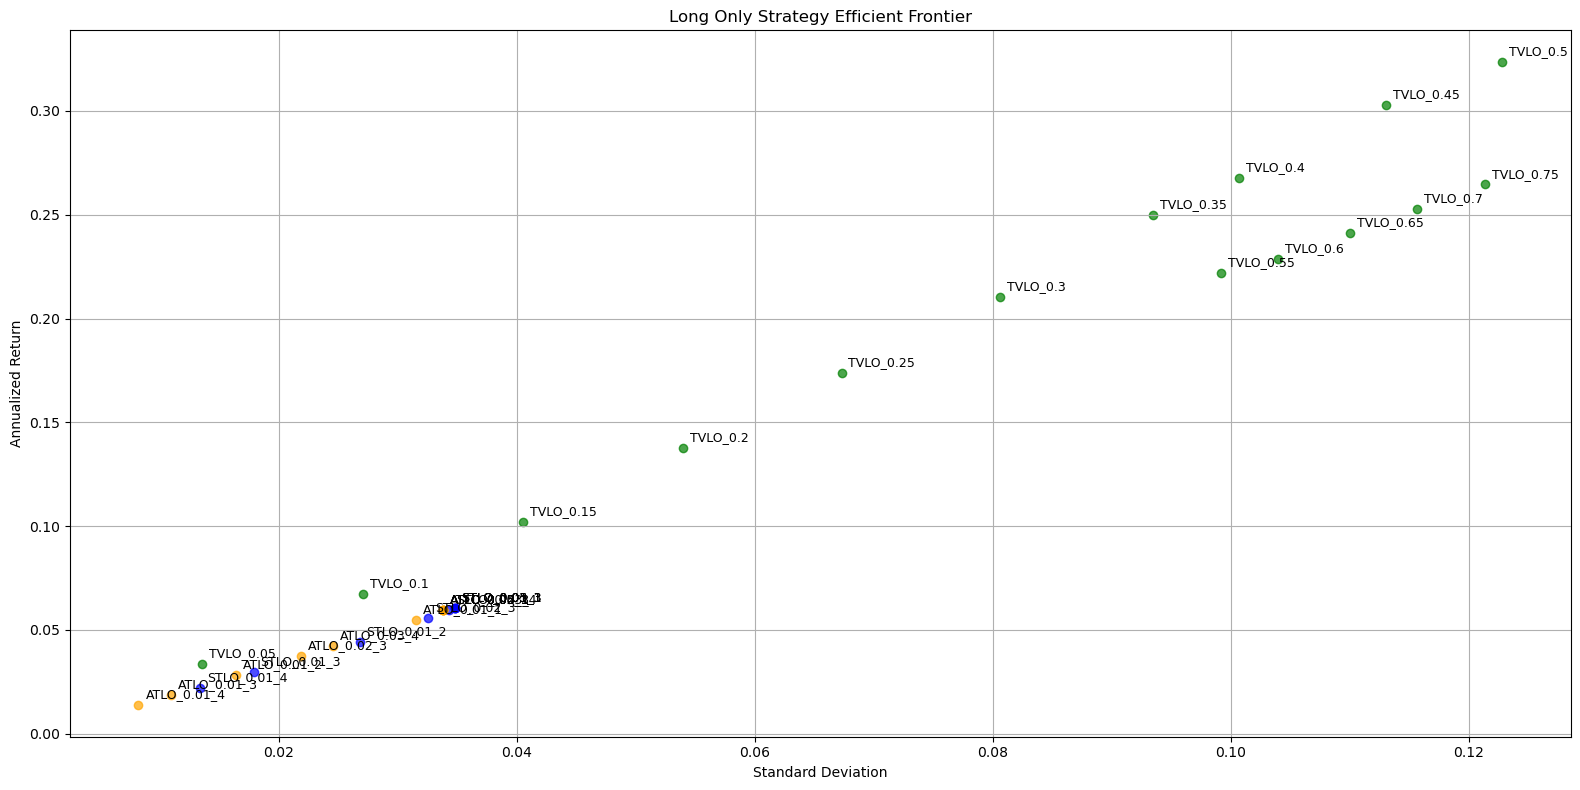

In [182]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

atr_cond = (df_results_atr_long_trim.annualized_std_dev <= 0.20)
std_cond = (df_results_std_long_trim.annualized_std_dev <= 0.20)
# target_vol_cond = (df_results_target_vol_long.annualized_std_dev <= 0.20)
# Scatter plot
ax.scatter(df_results_std_long_trim['annualized_std_dev'], df_results_std_long_trim['annualized_return'], color='blue', alpha=0.7)
ax.scatter(df_results_atr_long_trim['annualized_std_dev'], df_results_atr_long_trim['annualized_return'], color='orange', alpha=0.7)
ax.scatter(df_results_target_vol_long['annualized_std_dev'], df_results_target_vol_long['annualized_return'], color='green', alpha=0.7)

# Add labels next to each point
for i, row in df_results_std_long_trim.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_atr_long_trim.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_target_vol_long.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('Long Only Strategy Efficient Frontier')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

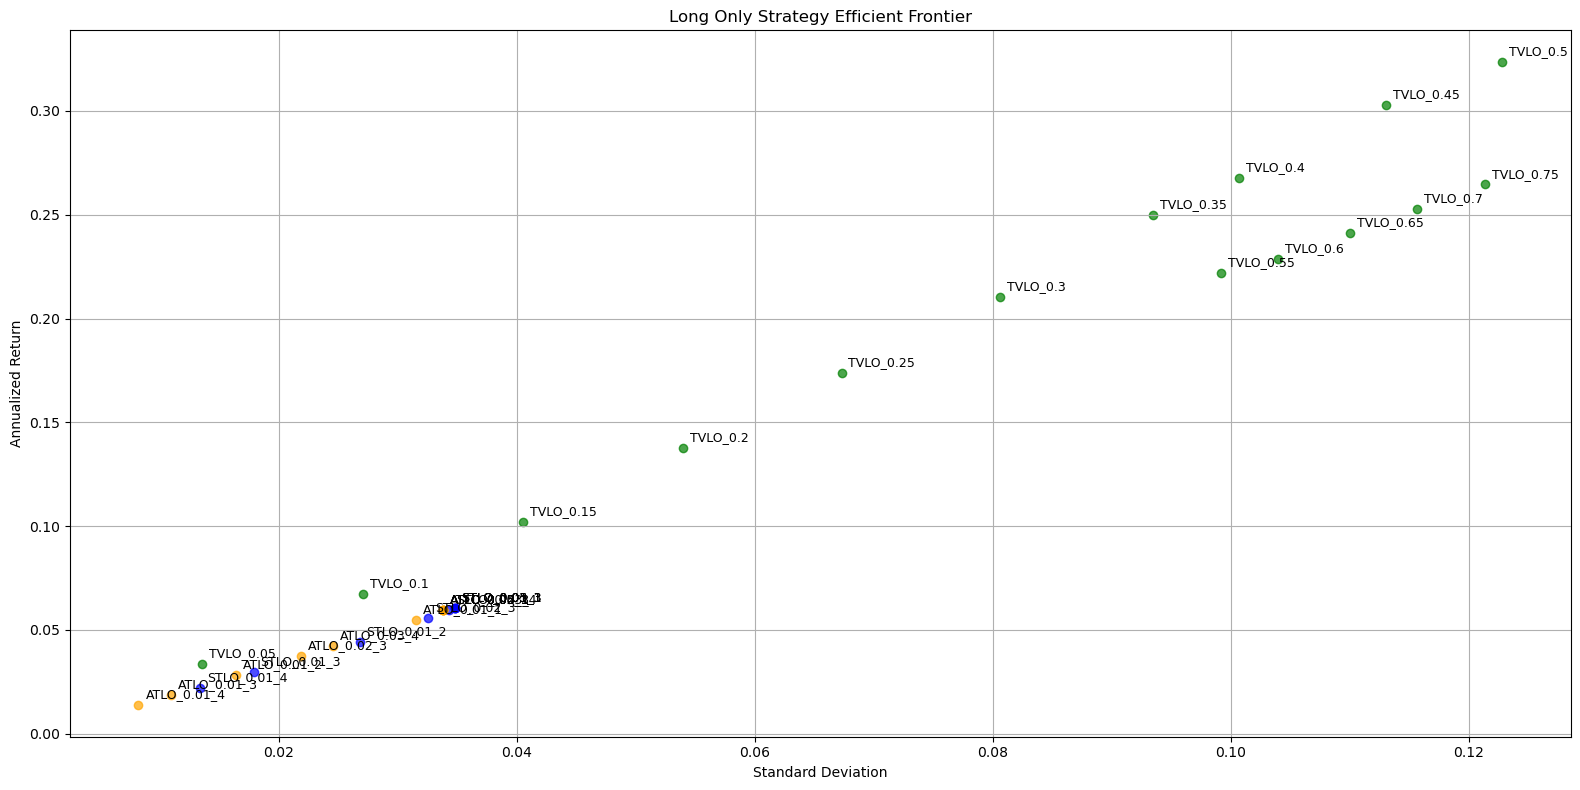

In [46]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

vol_threshold = 0.25
atr_cond = (df_results_atr_long_trim.annualized_std_dev <= vol_threshold)
std_cond = (df_results_std_long_trim.annualized_std_dev <= vol_threshold)
target_vol_cond = (df_results_target_vol_long.annualized_std_dev <= vol_threshold)
# Scatter plot
ax.scatter(df_results_std_long_trim[std_cond]['annualized_std_dev'], df_results_std_long_trim[std_cond]['annualized_return'], color='blue', alpha=0.7)
ax.scatter(df_results_atr_long_trim[atr_cond]['annualized_std_dev'], df_results_atr_long_trim[atr_cond]['annualized_return'], color='orange', alpha=0.7)
ax.scatter(df_results_target_vol_long[target_vol_cond]['annualized_std_dev'], df_results_target_vol_long[target_vol_cond]['annualized_return'], color='green', alpha=0.7)

# Add labels next to each point
for i, row in df_results_std_long_trim[std_cond].iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_atr_long_trim[atr_cond].iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_target_vol_long[target_vol_cond].iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('Long Only Strategy Efficient Frontier')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

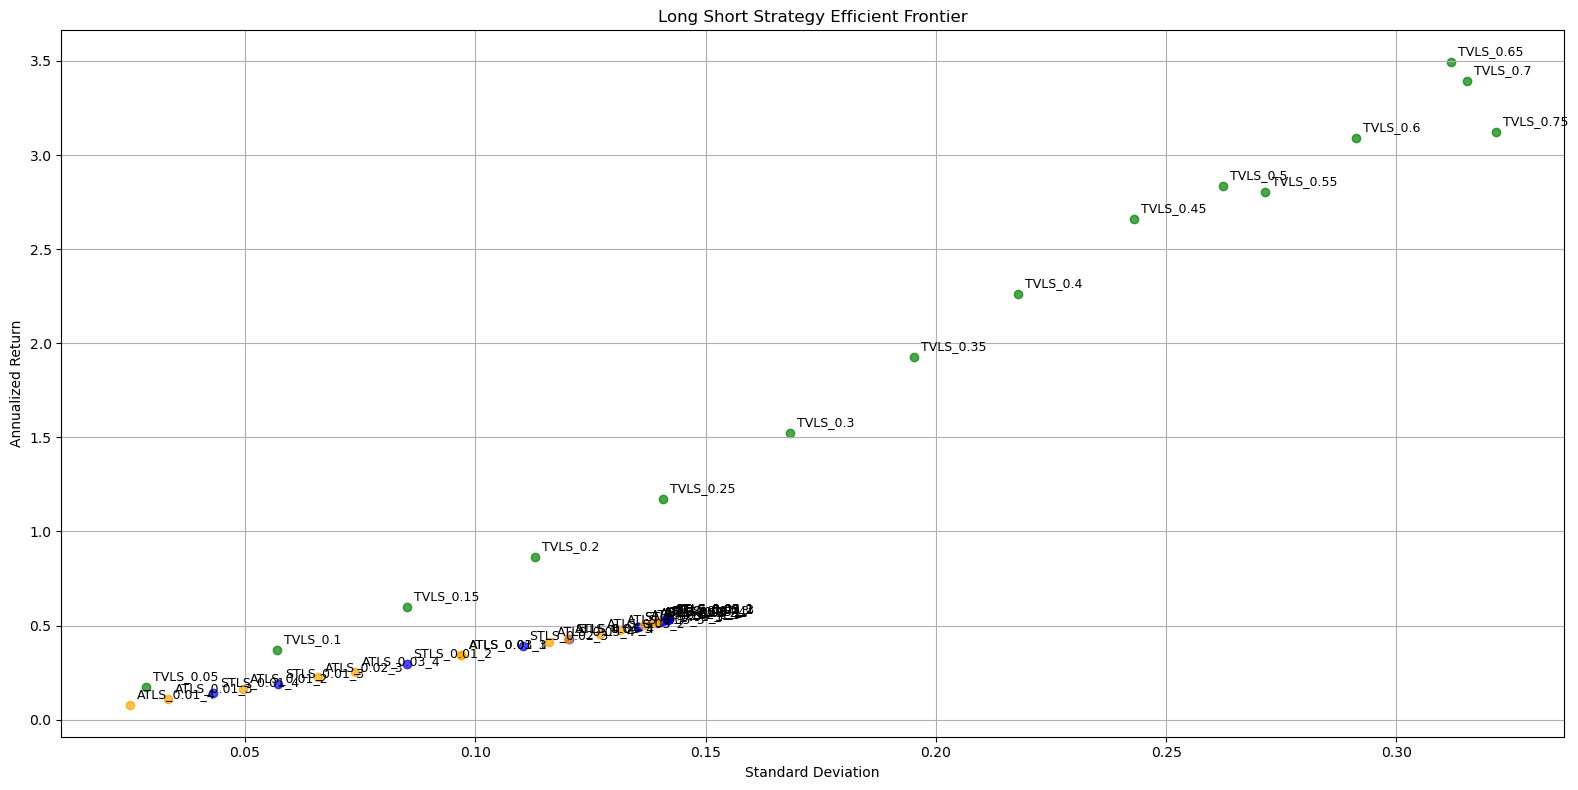

In [186]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

atr_cond = (df_results_atr_long_trim.annualized_std_dev <= 0.20)
std_cond = (df_results_std_long_trim.annualized_std_dev <= 0.20)
# Scatter plot
ax.scatter(df_results_std_long_short_trim['annualized_std_dev'], df_results_std_long_short_trim['annualized_return'], color='blue', alpha=0.7)
ax.scatter(df_results_atr_long_short_trim['annualized_std_dev'], df_results_atr_long_short_trim['annualized_return'], color='orange', alpha=0.7)
ax.scatter(df_results_target_vol_long_short['annualized_std_dev'], df_results_target_vol_long_short['annualized_return'], color='green', alpha=0.7)

# Add labels next to each point
for i, row in df_results_std_long_short_trim.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_atr_long_short_trim.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_target_vol_long_short.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('Long Short Strategy Efficient Frontier')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

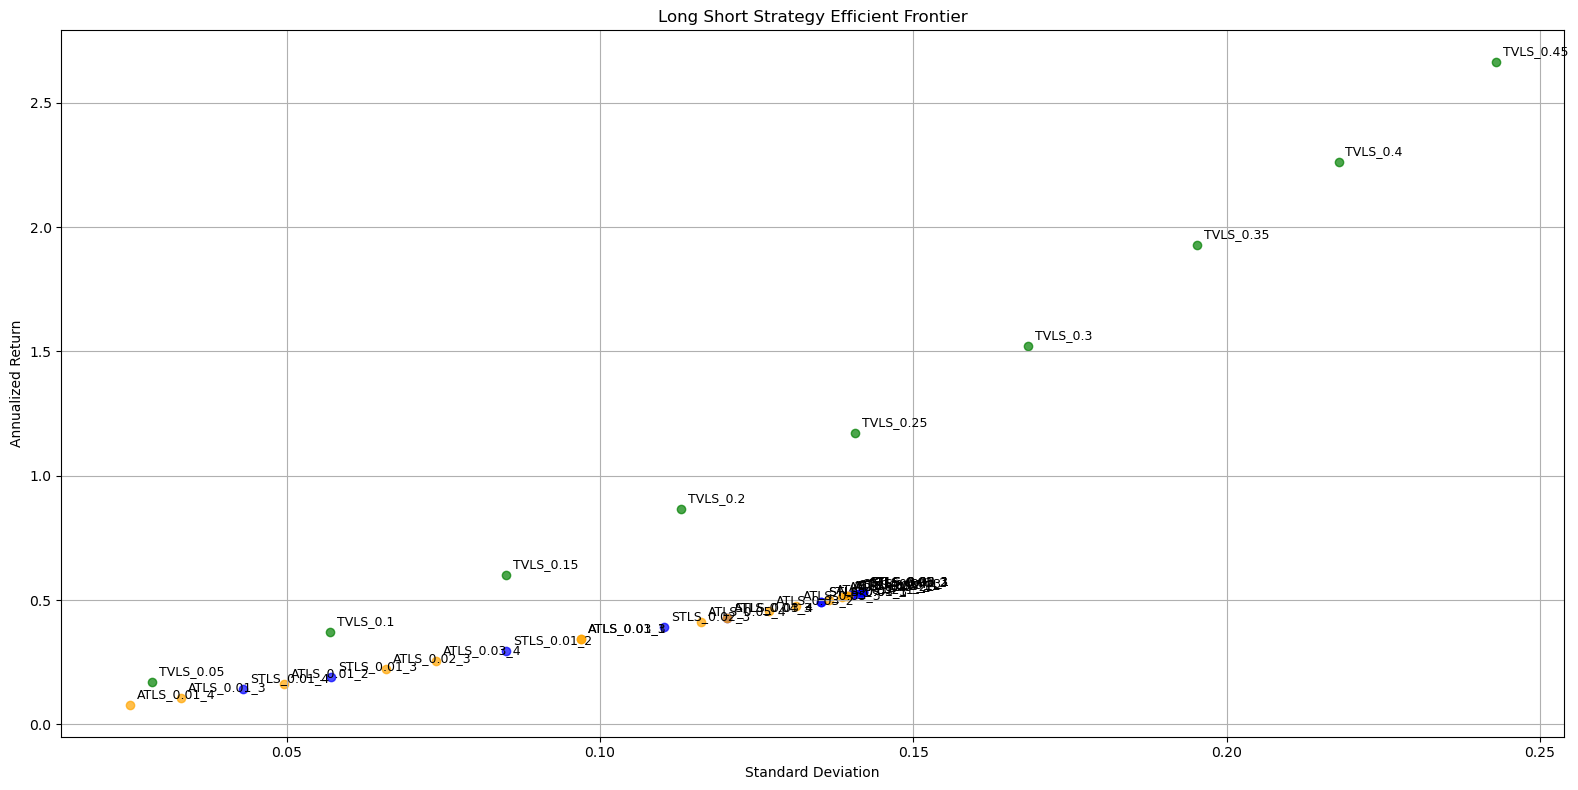

In [188]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

vol_threshold = 0.25
atr_cond = (df_results_atr_long_short_trim.annualized_std_dev <= vol_threshold)
std_cond = (df_results_std_long_short_trim.annualized_std_dev <= vol_threshold)
target_vol_cond = (df_results_target_vol_long_short.annualized_std_dev <= vol_threshold)
# Scatter plot
ax.scatter(df_results_std_long_short_trim[std_cond]['annualized_std_dev'], df_results_std_long_short_trim[std_cond]['annualized_return'], color='blue', alpha=0.7)
ax.scatter(df_results_atr_long_short_trim[atr_cond]['annualized_std_dev'], df_results_atr_long_short_trim[atr_cond]['annualized_return'], color='orange', alpha=0.7)
ax.scatter(df_results_target_vol_long_short[target_vol_cond]['annualized_std_dev'], df_results_target_vol_long_short[target_vol_cond]['annualized_return'], color='green', alpha=0.7)

# Add labels next to each point
for i, row in df_results_std_long_short_trim[std_cond].iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_atr_long_short_trim[atr_cond].iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_target_vol_long_short[target_vol_cond].iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('Long Short Strategy Efficient Frontier')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

## Testing Position Sizing Strategies using ATR, STD and Target Volatility

In [192]:
## Long Only
## Dates
signal_start_date = pd.Timestamp('2021-07-17').date()
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2023, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2024, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2026, 1, 31).date()
full_sample_start_date = in_sample_start_date
full_sample_end_date = out_of_sample_end_date

## Strategy Parameters
initial_capital = 20000
cash_buffer_percentage = 0.10
use_coinbase_data = True
rolling_sharpe_window = 50
transaction_cost_est=0.001
passive_trade_rate=0.05
long_only = True
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
use_specific_start_date=True

## Trend Following Parameters
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20

## ATR Parameters
rolling_atr_window = 20
atr_stop_loss_multiple = 1
atr_risk_per_trade = 0.02

## STD Parameters
rolling_std_window = 20
std_stop_loss_multiple = 1
std_risk_per_trade = 0.02

## Target Volatility Parameters
rolling_cov_window=20
volatility_window=20
annualized_target_volatility=0.30

In [72]:
%%time
df_atr_position_strategy = size.apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                                   mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                                   stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                                   annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)

CPU times: user 18.9 s, sys: 926 ms, total: 19.8 s
Wall time: 3min 45s


In [292]:
actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]

In [324]:
df_atr_position_strategy['total_target_notional_orig'] = df_atr_position_strategy['total_target_notional']
df_atr_position_strategy['total_target_notional'] = 0
mask = df_atr_position_strategy[actual_position_notional_cols].sum(axis=1) != 0
df_atr_position_strategy.loc[mask, 'total_target_notional'] = df_atr_position_strategy.loc[mask, target_notional_cols].sum(axis=1)

In [73]:
%%time
df_std_position_strategy = size.apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                                   mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                                   stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only,
                                                                   annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)

CPU times: user 19.3 s, sys: 930 ms, total: 20.3 s
Wall time: 3min 40s


In [326]:
df_std_position_strategy['total_target_notional_orig'] = df_std_position_strategy['total_target_notional']
df_std_position_strategy['total_target_notional'] = 0
mask = df_std_position_strategy[actual_position_notional_cols].sum(axis=1) != 0
df_std_position_strategy.loc[mask, 'total_target_notional'] = df_std_position_strategy.loc[mask, target_notional_cols].sum(axis=1)

In [194]:
%%time
df_target_vol_position_strategy_orig = size.apply_target_volatility_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                                                             slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, long_only=long_only,
                                                                                             initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
                                                                                             transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                                                             rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage,
                                                                                             annualized_target_volatility=np.round(annualized_target_volatility, 2),
                                                                                             annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)

CPU times: user 14.9 s, sys: 644 ms, total: 15.5 s
Wall time: 2min 22s


<Axes: xlabel='date'>

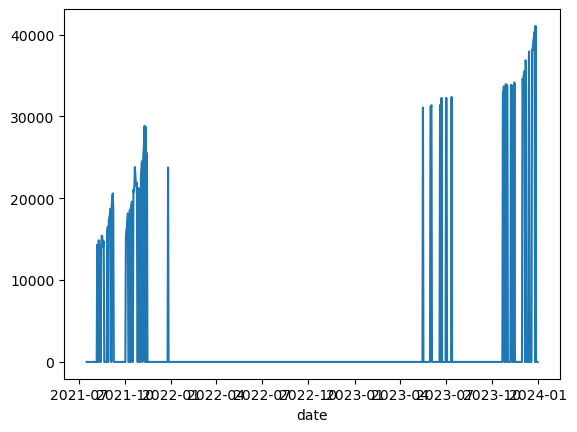

In [346]:
df_atr_position_strategy[df_atr_position_strategy.index >= signal_start_date][['total_target_notional',']].plot()

<Axes: xlabel='date'>

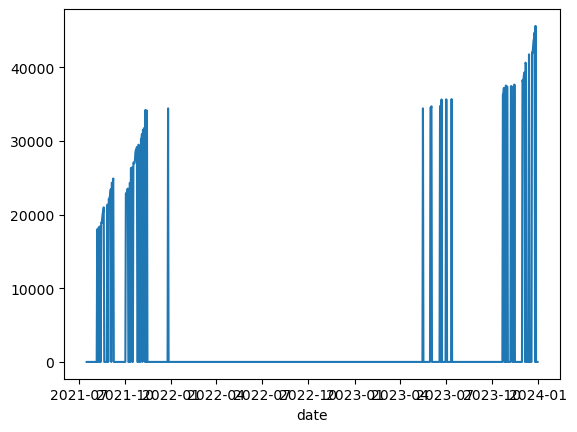

In [348]:
df_std_position_strategy[df_std_position_strategy.index >= signal_start_date]['total_target_notional'].plot()

<Axes: xlabel='date'>

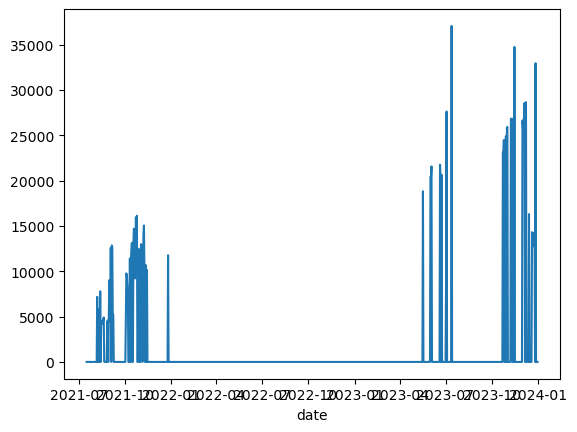

In [344]:
df_target_vol_position_strategy_orig['total_target_notional'].plot()

In [198]:
df_std_position_strategy.head()

,BTC-USD,BTC-USD_20_std_dev,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_account_risk,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_event,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_trade_risk,ETH-USD,ETH-USD_20_std_dev,ETH-USD_50_6_250_mavg_crossover_20_donchian_signal,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,ETH-USD_account_risk,ETH-USD_actual_position_entry_price,ETH-USD_actual_position_exit_price,ETH-USD_actual_position_notional,ETH-USD_actual_size,ETH-USD_event,ETH-USD_short_sale_proceeds,ETH-USD_t_1_close,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_trade_risk,LTC-USD,LTC-USD_20_std_dev,LTC-USD_50_6_250_mavg_crossover_20_donchian_signal,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,LTC-USD_account_risk,LTC-USD_actual_position_entry_price,LTC-USD_actual_position_exit_price,LTC-USD_actual_position_notional,LTC-USD_actual_size,LTC-USD_event,LTC-USD_short_sale_proceeds,LTC-USD_t_1_close,LTC-USD_target_notional,LTC-USD_target_size,LTC-USD_trade_risk,SOL-USD,SOL-USD_20_std_dev,SOL-USD_50_6_250_mavg_crossover_20_donchian_signal,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,SOL-USD_account_risk,SOL-USD_actual_position_entry_price,SOL-USD_actual_position_exit_price,SOL-USD_actual_position_notional,SOL-USD_actual_size,SOL-USD_event,SOL-USD_short_sale_proceeds,SOL-USD_t_1_close,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_trade_risk,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11,449.19,NaN,0,-0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,449.99,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
2016-01-12,434.01,NaN,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,449.19,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
2016-01-13,432.77,NaN,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,434.01,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
2016-01-14,430.03,NaN,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,432.77,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN
2016-01-15,357.53,NaN,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,430.03,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN


In [200]:
df_target_vol_position_strategy_orig.head()

,BTC-USD,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD,ETH-USD_50_6_250_mavg_crossover_20_donchian_signal,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,ETH-USD_actual_position_entry_price,ETH-USD_actual_position_exit_price,ETH-USD_actual_position_notional,ETH-USD_actual_size,ETH-USD_annualized_volatility_20,ETH-USD_event,ETH-USD_pct_returns,ETH-USD_position_volatility_adjusted_weight,ETH-USD_short_sale_proceeds,ETH-USD_t_1_close,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,LTC-USD,LTC-USD_50_6_250_mavg_crossover_20_donchian_signal,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,LTC-USD_actual_position_entry_price,LTC-USD_actual_position_exit_price,LTC-USD_actual_position_notional,LTC-USD_actual_size,LTC-USD_annualized_volatility_20,LTC-USD_event,LTC-USD_pct_returns,LTC-USD_position_volatility_adjusted_weight,LTC-USD_short_sale_proceeds,LTC-USD_t_1_close,LTC-USD_target_notional,LTC-USD_target_size,LTC-USD_target_vol_normalized_weight,LTC-USD_vol_adjusted_trend_signal,SOL-USD,SOL-USD_50_6_250_mavg_crossover_20_donchian_signal,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,SOL-USD_actual_position_entry_price,SOL-USD_actual_position_exit_price,SOL-USD_actual_position_notional,SOL-USD_actual_size,SOL-USD_annualized_volatility_20,SOL-USD_event,SOL-USD_pct_returns,SOL-USD_position_volatility_adjusted_weight,SOL-USD_short_sale_proceeds,SOL-USD_t_1_close,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-17,31533.91,0,0.0,0.0,0.0,0.0,0.0,0.0,0.477564,NaN,0.004647,0.0,0.0,31388.06,0.0,0.0,0.0,0.0,1899.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.847473,NaN,0.012002,0.0,0.0,1877.22,0.0,0.0,0.0,0.0,120.02,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.544771,NaN,-0.005469,0.0,0.0,120.68,0.0,0.0,0.0,0.0,26.764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.013539,NaN,0.017797,0.0,0.0,26.296,0.0,0.0,0.0,0.0,0.0,20000.0,0.0,0.0,0.0,20000.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN
2021-07-18,31788.25,0,0.0,0.0,0.0,0.0,0.0,0.0,0.480458,No Event,0.008066,0.0,0.0,31533.91,0.0,0.0,0.0,0.0,1891.46,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.815654,No Event,-0.004364,0.0,0.0,1899.75,0.0,0.0,0.0,0.0,119.13,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.510241,No Event,-0.007415,0.0,0.0,120.02,0.0,0.0,0.0,0.0,26.696,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.996538,No Event,-0.002541,0.0,0.0,26.764,0.0,0.0,0.0,0.0,0.0,20000.0,0.0,0.0,0.0,20000.0,18000.0,0.0,1.0,0.0,0.0,0.0,NaN
2021-07-19,30842.03,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.447962,No Event,-0.029766,0.0,0.0,31788.25,0.0,0.0,0.0,0.0,1818.44,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.803844,No Event,-0.038605,0.0,0.0,1891.46,0.0,0.0,0.0,0.0,113.17,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.480651,No Event,-0.050029,0.0,0.0,119.13,0.0,0.0,0.0,0.0,24.524,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,1.026424,No Event,-0.081361,0.0,0.0,26.69

In [328]:
strat_cols = []
for ticker in ticker_list:
    cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',f'{ticker}_event',f'{ticker}_target_notional',f'{ticker}_target_size',
            f'{ticker}_actual_position_notional',f'{ticker}_actual_size']
    strat_cols.extend(cols)

strat_cols.extend(['total_portfolio_value','portfolio_daily_pct_returns','available_cash','portfolio_trade_count','total_target_notional','total_actual_position_notional','portfolio_strategy_cumulative_return'])
df_position_sizing_perf_long = df_target_vol_position_strategy_orig[strat_cols]

strat_cols = []
for ticker in ticker_list:
    cols = [f'{ticker}_target_notional',f'{ticker}_target_size',f'{ticker}_actual_position_notional',f'{ticker}_actual_size']
    strat_cols.extend(cols)

strat_cols.extend(['total_portfolio_value','portfolio_daily_pct_returns','available_cash','portfolio_trade_count','total_target_notional','total_actual_position_notional','portfolio_strategy_cumulative_return'])

In [204]:
# tv_cols = ['BTC_signal','BTC_event','BTC_target_notional_tv','BTC_target_size_tv',
#            'BTC_actual_notional_tv','BTC-USD_actual_size_tv','ETH_signal','ETH_event',
#            'ETH_target_notional_tv','ETH_target_size_tv','ETH_actual_notional_tv',
#            'ETH_actual_size_tv','LTC_signal','LTC_event','LTC_target_notional_tv',
#            'LTC_target_size_tv','LTC_actual_notional_tv','LTC_actual_size_tv',
#            'SOL_signal','SOL_event','SOL_target_notional_tv','SOL_target_size_tv',
#            'SOL_actual_notional_tv','SOL_actual_size_tv','ADA_signal','ADA_event',
#            'ADA_target_notional_tv','ADA_target_size_tv','ADA_actual_notional_tv',
#            'ADA-USD_actual_size_tv','ALGO_signal','ALGO_event','ALGO_target_notional_tv',
#            'ALGO_target_size_tv','ALGO_actual_notional_tv','ALGO-USD_actual_size_tv',
#            'AAVE_signal','AAVE_event','AAVE_target_notional_tv','AAVE_target_size_tv',
#            'AAVE_actual_notional_tv','AAVE-USD_actual_size_tv','total_portfolio_value_tv',
#            'daily_portfolio_pct_returns_tv','available_cash_tv']
# std_cols = ['BTC_target_notional_std','BTC_target_size_std','BTC_actual_notional_std',
#             'BTC-USD_actual_size_std','ETH_target_notional_std','ETH_target_size_std',
#             'ETH_actual_notional_std','ETH_actual_size_std','LTC_target_notional_std',
#             'LTC_target_size_std','LTC_actual_notional_std','LTC_actual_size_std',
#             'SOL_target_notional_std','SOL_target_size_std','SOL_actual_notional_std',
#             'SOL_actual_size_std','ADA_target_notional_std','ADA_target_size_std',
#             'ADA_actual_notional_std','ADA-USD_actual_size_std','ALGO_target_notional_std',
#             'ALGO_target_size_std','ALGO_actual_notional_std','ALGO-USD_actual_size_std',
#             'AAVE_target_notional_std','AAVE_target_size_std','AAVE_actual_notional_std',
#             'AAVE-USD_actual_size_std','total_portfolio_value_std',
#             'daily_portfolio_pct_returns_std','available_cash_std']
# atr_cols = ['BTC_target_notional_atr','BTC_target_size_atr','BTC_actual_notional_atr',
#             'BTC-USD_actual_size_atr','ETH_target_notional_atr','ETH_target_size_atr',
#             'ETH_actual_notional_atr','ETH_actual_size_atr','LTC_target_notional_atr',
#             'LTC_target_size_atr','LTC_actual_notional_atr','LTC_actual_size_atr',
#             'SOL_target_notional_atr','SOL_target_size_atr','SOL_actual_notional_atr',
#             'SOL_actual_size_atr','ADA_target_notional_atr','ADA_target_size_atr',
#             'ADA_actual_notional_atr','ADA-USD_actual_size_atr','ALGO_target_notional_atr',
#             'ALGO_target_size_atr','ALGO_actual_notional_atr','ALGO-USD_actual_size_atr',
#             'AAVE_target_notional_atr','AAVE_target_size_atr','AAVE_actual_notional_atr',
#             'AAVE-USD_actual_size_atr','total_portfolio_value_atr',
#             'daily_portfolio_pct_returns_atr','available_cash_atr']
# df_position_sizing_perf_long.columns = tv_cols
# df_std_trim = df_std_position_strategy[strat_cols]
# df_std_trim.columns = std_cols
# df_atr_trim = df_atr_position_strategy[strat_cols]
# df_atr_trim.columns = atr_cols
# df_position_sizing_perf_long = pd.merge(df_position_sizing_perf_long, df_std_trim, left_index=True, right_index=True, how='left')
# df_position_sizing_perf_long = pd.merge(df_position_sizing_perf_long, df_atr_trim, left_index=True, right_index=True, how='left')

In [206]:
ticker_list

['BTC-USD', 'ETH-USD', 'LTC-USD', 'SOL-USD']

In [330]:
tv_cols = ['BTC_signal','BTC_event','BTC_target_notional_tv','BTC_target_size_tv',
           'BTC_actual_notional_tv','BTC-USD_actual_size_tv','ETH_signal','ETH_event',
           'ETH_target_notional_tv','ETH_target_size_tv','ETH_actual_notional_tv',
           'ETH_actual_size_tv','LTC_signal','LTC_event','LTC_target_notional_tv',
           'LTC_target_size_tv','LTC_actual_notional_tv','LTC_actual_size_tv',
           'SOL_signal','SOL_event','SOL_target_notional_tv','SOL_target_size_tv',
           'SOL_actual_notional_tv','SOL_actual_size_tv','total_portfolio_value_tv',
           'daily_portfolio_pct_returns_tv','available_cash_tv','portfolio_trade_count_tv',
           'total_target_notional_tv','total_actual_position_notional_tv',
           'portfolio_strategy_cumulative_return_tv']
std_cols = ['BTC_target_notional_std','BTC_target_size_std','BTC_actual_notional_std',
            'BTC-USD_actual_size_std','ETH_target_notional_std','ETH_target_size_std',
            'ETH_actual_notional_std','ETH_actual_size_std','LTC_target_notional_std',
            'LTC_target_size_std','LTC_actual_notional_std','LTC_actual_size_std',
            'SOL_target_notional_std','SOL_target_size_std','SOL_actual_notional_std',
            'SOL_actual_size_std','total_portfolio_value_std',
            'daily_portfolio_pct_returns_std','available_cash_std','portfolio_trade_count_std',
            'total_target_notional_std','total_actual_position_notional_std','portfolio_strategy_cumulative_return_std']
atr_cols = ['BTC_target_notional_atr','BTC_target_size_atr','BTC_actual_notional_atr',
            'BTC-USD_actual_size_atr','ETH_target_notional_atr','ETH_target_size_atr',
            'ETH_actual_notional_atr','ETH_actual_size_atr','LTC_target_notional_atr',
            'LTC_target_size_atr','LTC_actual_notional_atr','LTC_actual_size_atr',
            'SOL_target_notional_atr','SOL_target_size_atr','SOL_actual_notional_atr',
            'SOL_actual_size_atr','total_portfolio_value_atr',
            'daily_portfolio_pct_returns_atr','available_cash_atr','portfolio_trade_count_atr',
            'total_target_notional_atr','total_actual_position_notional_atr','portfolio_strategy_cumulative_return_atr']
df_position_sizing_perf_long.columns = tv_cols
df_std_trim = df_std_position_strategy[strat_cols]
df_std_trim.columns = std_cols
df_atr_trim = df_atr_position_strategy[strat_cols]
df_atr_trim.columns = atr_cols
df_position_sizing_perf_long = pd.merge(df_position_sizing_perf_long, df_std_trim, left_index=True, right_index=True, how='left')
df_position_sizing_perf_long = pd.merge(df_position_sizing_perf_long, df_atr_trim, left_index=True, right_index=True, how='left')

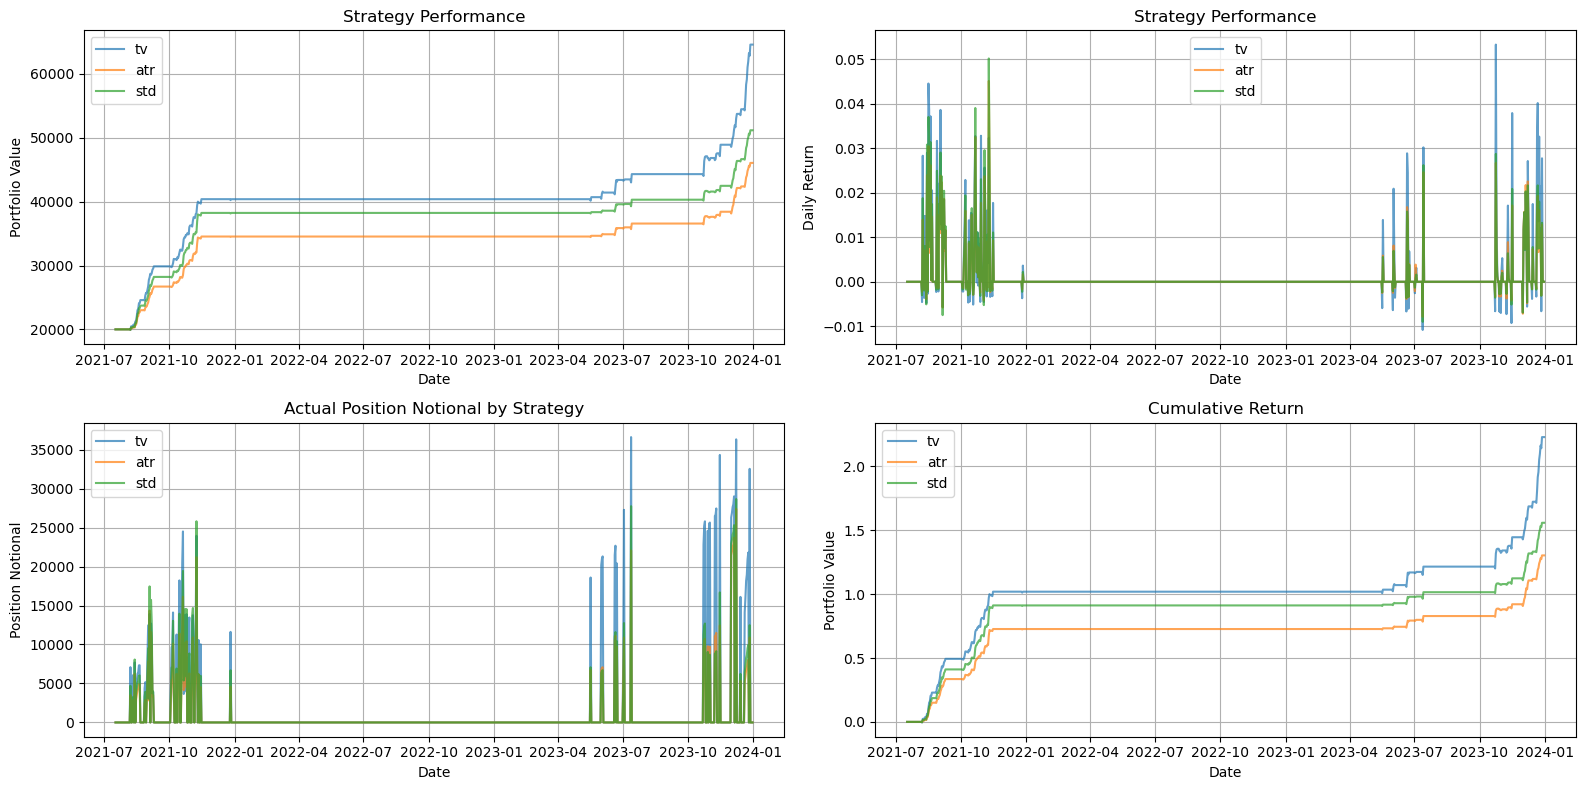

In [354]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
layout = (2,2)
value_ax = plt.subplot2grid(layout, (0, 0))  # A single grid, but you can customize this layout
return_ax = plt.subplot2grid(layout, (0, 1))  # A single grid, but you can customize this layout
target_notional_ax = plt.subplot2grid(layout, (1, 0))  # A single grid, but you can customize this layout
cum_return_ax = plt.subplot2grid(layout, (1, 1))  # A single grid, but you can customize this layout

strategy_list = ['tv','atr','std']
for strategy in strategy_list:
    _ = value_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'total_portfolio_value_{strategy}'], alpha=0.7, label=strategy)
    _ = return_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'daily_portfolio_pct_returns_{strategy}'], alpha=0.7, label=strategy)
    _ = target_notional_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'total_actual_position_notional_{strategy}'], alpha=0.7, label=strategy)
    _ = cum_return_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'portfolio_strategy_cumulative_return_{strategy}'], alpha=0.7, label=strategy)
    

# Add labels and title
_ = value_ax.set_xlabel('Date')
_ = value_ax.set_ylabel('Portfolio Value')
_ = value_ax.set_title('Strategy Performance')
_ = value_ax.grid(True)
_ = value_ax.legend()

_ = return_ax.set_xlabel('Date')
_ = return_ax.set_ylabel('Daily Return')
_ = return_ax.set_title('Strategy Performance')
_ = return_ax.grid(True)
_ = return_ax.legend()

_ = target_notional_ax.set_xlabel('Date')
_ = target_notional_ax.set_ylabel('Position Notional')
_ = target_notional_ax.set_title('Actual Position Notional by Strategy')
_ = target_notional_ax.grid(True)
_ = target_notional_ax.legend()

_ = cum_return_ax.set_xlabel('Date')
_ = cum_return_ax.set_ylabel('Portfolio Value')
_ = cum_return_ax.set_title('Cumulative Return')
_ = cum_return_ax.grid(True)
_ = cum_return_ax.legend()

# Show plot
plt.tight_layout()
plt.show()

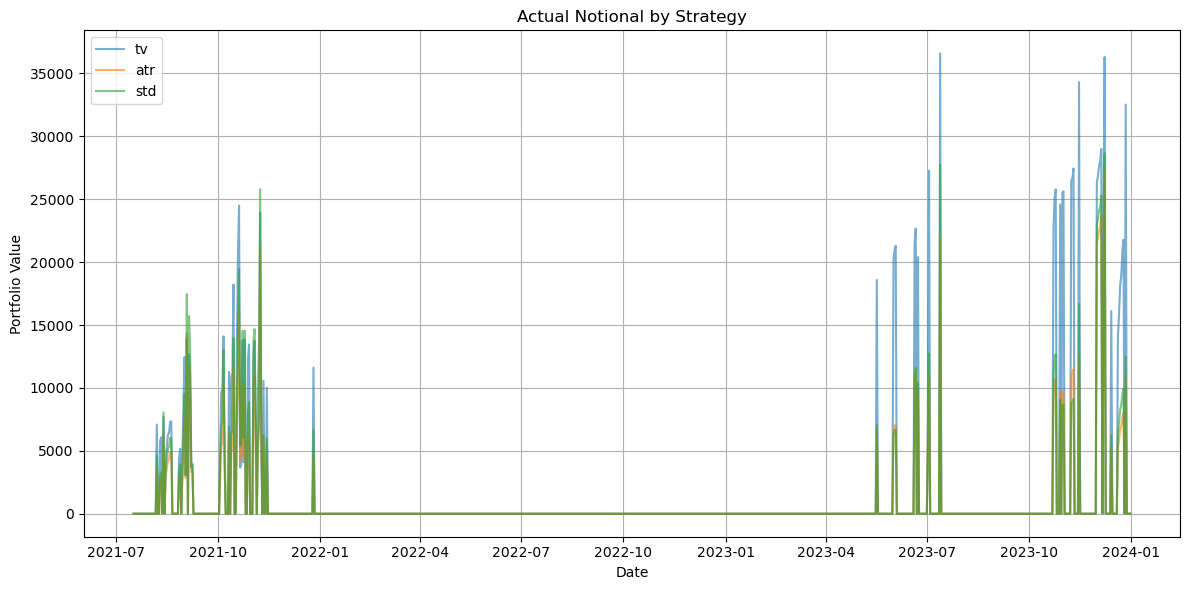

In [338]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(12, 6))
layout = (1,1)
actual_ax = plt.subplot2grid(layout, (0, 0))  # A single grid, but you can customize this layout
# return_ax = plt.subplot2grid(layout, (0, 1))  # A single grid, but you can customize this layout
# target_notional_ax = plt.subplot2grid(layout, (1, 0))  # A single grid, but you can customize this layout
# cum_return_ax = plt.subplot2grid(layout, (1, 1))  # A single grid, but you can customize this layout

strategy_list = ['tv','atr','std']
for strategy in strategy_list:
    _ = actual_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'total_actual_position_notional_{strategy}'], alpha=0.6, label=strategy)
    # _ = return_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'daily_portfolio_pct_returns_{strategy}'], alpha=0.7, label=strategy)
    # _ = target_notional_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'total_target_notional_{strategy}'], alpha=0.7, label=strategy)
    # _ = cum_return_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'portfolio_strategy_cumulative_return_{strategy}'], alpha=0.7, label=strategy)
    

# Add labels and title
_ = actual_ax.set_xlabel('Date')
_ = actual_ax.set_ylabel('Portfolio Value')
_ = actual_ax.set_title('Actual Notional by Strategy')
_ = actual_ax.grid(True)
_ = actual_ax.legend()

# _ = return_ax.set_xlabel('Date')
# _ = return_ax.set_ylabel('Daily Return')
# _ = return_ax.set_title('Strategy Performance')
# _ = return_ax.grid(True)
# _ = return_ax.legend()

# _ = target_notional_ax.set_xlabel('Date')
# _ = target_notional_ax.set_ylabel('Target Notional')
# _ = target_notional_ax.set_title('Target Notional by Strategy')
# _ = target_notional_ax.grid(True)
# _ = target_notional_ax.legend()

# _ = cum_return_ax.set_xlabel('Date')
# _ = cum_return_ax.set_ylabel('Portfolio Value')
# _ = cum_return_ax.set_title('Cumulative Return')
# _ = cum_return_ax.grid(True)
# _ = cum_return_ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [356]:
position_cond = (df_position_sizing_perf_long['total_actual_position_notional_atr'] != 0)
df_position_sizing_perf_long[position_cond][[#'total_target_notional_tv','total_target_notional_atr','total_target_notional_std',
                                             'total_actual_position_notional_tv','total_actual_position_notional_atr','total_actual_position_notional_std',
                                             'total_portfolio_value_tv','total_portfolio_value_atr','total_portfolio_value_std',
                                             'daily_portfolio_pct_returns_tv','daily_portfolio_pct_returns_atr','daily_portfolio_pct_returns_std']]

,total_actual_position_notional_tv,total_actual_position_notional_atr,total_actual_position_notional_std,total_portfolio_value_tv,total_portfolio_value_atr,total_portfolio_value_std,daily_portfolio_pct_returns_tv,daily_portfolio_pct_returns_atr,daily_portfolio_pct_returns_std
date,,,,,,,,,
2021-08-07,7089.866029,3500.888729,4707.802554,19908.800467,19954.966791,19939.441819,-0.004560,-0.002252,-0.003028
2021-08-10,5782.811159,2731.613534,3117.378604,20397.928145,20198.085382,20273.525647,-0.003634,-0.001737,-0.001974
2021-08-11,6084.092689,2873.929215,3279.792449,20699.209676,20340.401063,20435.939492,0.014770,0.007046,0.008011
2021-08-13,7694.711849,6243.712701,8071.100725,20664.529848,20290.459183,20366.780641,-0.004767,-0.003943,-0.005072
2021-08-15,4447.750221,2978.693461,3653.289269,21205.509033,20737.790404,20947.005784,-0.002691,-0.001844,-0.002238
2021-08-16,5391.907982,3611.003373,4428.800762,22149.666794,21370.100316,21722.517278,0.044524,0.030491,0.037023
2021-08-17,6247.569830,4184.046872,5131.623559,23005.328642,21943.143815,22425.340074,0.038631,0.026815,0.032355
2021-08-18,6460.403005,4326.582930,5306.440289,23218.161816,22085.679873,22600.156805,0.009251,0.006496,0.007795
2021-08-19,7322.910953,4904.211317,6014.886329,24080.669765,22663.308260,23308.602845,0.037148,0.026154,0.031347


In [274]:
df_atr_position_strategy[df_atr_position_strategy.index > pd.Timestamp('2021-08-05').date()].head()

,BTC-USD,BTC-USD_20_avg_true_range_price,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_account_risk,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_close,BTC-USD_event,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_trade_risk,ETH-USD,ETH-USD_20_avg_true_range_price,ETH-USD_50_6_250_mavg_crossover_20_donchian_signal,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,ETH-USD_account_risk,ETH-USD_actual_position_entry_price,ETH-USD_actual_position_exit_price,ETH-USD_actual_position_notional,ETH-USD_actual_size,ETH-USD_close,ETH-USD_event,ETH-USD_short_sale_proceeds,ETH-USD_t_1_close,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_trade_risk,LTC-USD,LTC-USD_20_avg_true_range_price,LTC-USD_50_6_250_mavg_crossover_20_donchian_signal,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,LTC-USD_account_risk,LTC-USD_actual_position_entry_price,LTC-USD_actual_position_exit_price,LTC-USD_actual_position_notional,LTC-USD_actual_size,LTC-USD_close,LTC-USD_event,LTC-USD_short_sale_proceeds,LTC-USD_t_1_close,LTC-USD_target_notional,LTC-USD_target_size,LTC-USD_trade_risk,SOL-USD,SOL-USD_20_avg_true_range_price,SOL-USD_50_6_250_mavg_crossover_20_donchian_signal,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,SOL-USD_account_risk,SOL-USD_actual_position_entry_price,SOL-USD_actual_position_exit_price,SOL-USD_actual_position_notional,SOL-USD_actual_size,SOL-USD_close,SOL-USD_event,SOL-USD_short_sale_proceeds,SOL-USD_t_1_close,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_trade_risk,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-06,42869.58,2410.948401,0,0.0,0.0,900.000000,0.0,0.0,0.0,0.0,42869.58,No Event,0.0,40888.74,4129.040493,0.100982,8912.449771,2892.98,183.568762,0.0,0.000000,0.0,900.000000,0.00,0.00,0.000000,0.000000,2892.98,No Event,0.0,2829.35,3748.994598,1.325037,679.226105,148.09,8.517715,0.0,0.0,0.0,900.000000,0.0,0.0,0.0,0.0,148.09,No Event,0.0,143.59,3815.749113,26.573920,33.867793,39.513,3.108798,0.0,0.000000,0.0,900.000000,0.000,0.0,0.000000,0.000000,39.513,No Event,0.0,37.398,2678.412125,71.619127,12.566475,20000.000000,0.0,0.000000,14372.196329,20000.000000,18000.000000,1.0,0.000000,0.0,0.000000,0.0
2021-08-07,44637.34,2516.812363,0,0.0,0.0,900.000000,0.0,0.0,0.0,0.0,44637.34,No Event,0.0,42869.58,4000.772268,0.093324,9643.793603,3163.09,187.820308,1.0,0.093367,1.0,900.000000,2892.98,0.00,3500.888729,1.210132,3163.09,New Long Position,0.0,2892.98,3545.921937,1.225699,734.275048,156.05,8.564599,0.0,0.0,0.0,900.000000,0.0,0.0,0.0,0.0,156.05,No Event,0.0,148.09,3911.876592,26.415535,34.070860,39.516,3.268055,0.0,0.000000,0.0,900.000000,0.000,0.0,0.000000,0.000000,39.516,No Event,0.0,39.513,2859.762841,72.375240,12.435192,16454.078063,1.0,3500.888729,14318.333638,19954.966791,18000.000000,1.0,-0.002252,1.0,-0.002252,0.0
2021-08-08,43829.14,2495.471185,0,-0.0,0.0,897.973506,0.0,0.0,0.0,0.0,43829.14,No Event,0.0,44637.34,3981.539236,0.089198,10067.249450,3014.13,199.184089,0.0,-0.000000,-1.0,897.973506,0.00,3163.09,0.000000,0.000000,3014.13,Closing Long Position,0.0,3163.09,3780.702736,1.195256,751.281234,149.88,8.637495,0.0,-0.0,0.0,897.973506,0.0,0.0,0.0,0.0,149.88,No Event,0.0,156.05,4090.347972,26.211778,34.258397,37.689,3

In [276]:
df_target_vol_position_strategy_orig[df_target_vol_position_strategy_orig.index > pd.Timestamp('2021-08-05').date()].head()

,BTC-USD,BTC-USD_50_6_250_mavg_crossover_20_donchian_signal,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,BTC-USD_actual_position_entry_price,BTC-USD_actual_position_exit_price,BTC-USD_actual_position_notional,BTC-USD_actual_size,BTC-USD_annualized_volatility_20,BTC-USD_event,BTC-USD_pct_returns,BTC-USD_position_volatility_adjusted_weight,BTC-USD_short_sale_proceeds,BTC-USD_t_1_close,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD,ETH-USD_50_6_250_mavg_crossover_20_donchian_signal,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,ETH-USD_actual_position_entry_price,ETH-USD_actual_position_exit_price,ETH-USD_actual_position_notional,ETH-USD_actual_size,ETH-USD_annualized_volatility_20,ETH-USD_event,ETH-USD_pct_returns,ETH-USD_position_volatility_adjusted_weight,ETH-USD_short_sale_proceeds,ETH-USD_t_1_close,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,LTC-USD,LTC-USD_50_6_250_mavg_crossover_20_donchian_signal,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,LTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,LTC-USD_actual_position_entry_price,LTC-USD_actual_position_exit_price,LTC-USD_actual_position_notional,LTC-USD_actual_size,LTC-USD_annualized_volatility_20,LTC-USD_event,LTC-USD_pct_returns,LTC-USD_position_volatility_adjusted_weight,LTC-USD_short_sale_proceeds,LTC-USD_t_1_close,LTC-USD_target_notional,LTC-USD_target_size,LTC-USD_target_vol_normalized_weight,LTC-USD_vol_adjusted_trend_signal,SOL-USD,SOL-USD_50_6_250_mavg_crossover_20_donchian_signal,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns,SOL-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades,SOL-USD_actual_position_entry_price,SOL-USD_actual_position_exit_price,SOL-USD_actual_position_notional,SOL-USD_actual_size,SOL-USD_annualized_volatility_20,SOL-USD_event,SOL-USD_pct_returns,SOL-USD_position_volatility_adjusted_weight,SOL-USD_short_sale_proceeds,SOL-USD_t_1_close,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,daily_portfolio_volatility,available_cash,count_of_positions,total_actual_position_notional,total_target_notional,total_portfolio_value,total_portfolio_value_upper_limit,target_vol_scaling_factor,target_notional_scaling_factor,portfolio_daily_pct_returns,portfolio_trade_count,portfolio_strategy_cumulative_return,portfolio_rolling_sharpe_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-08-06,42869.58,0,0.0,0.0,0.0,0.0,0.0,0.0,0.670182,No Event,0.048445,0.0,0.0,40888.74,0.0,0.0,0.0,0.0,2892.98,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000000,0.699748,No Event,0.022489,0.0,0.0,2829.35,0.000000,0.000000,0.000000,0.000000,148.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.645593,No Event,0.031339,0.0,0.0,143.59,0.0,0.0,0.0,0.0,39.513,0.0,0.000000,0.0,0.000,0.0,0.000000,0.00000,1.151729,No Event,0.056554,0.0,0.0,37.398,0.000000,0.000000,0.000000,0.000000,0.000000,20000.000000,0.0,0.000000,0.000000,20000.000000,18000.000000,0.000000,1.0,0.000000,0.0,0.000000,NaN
2021-08-07,44637.34,0,0.0,0.0,0.0,0.0,0.0,0.0,0.677531,No Event,0.041236,0.0,0.0,42869.58,0.0,0.0,0.0,0.0,3163.09,1.0,0.093367,1.0,2892.98,0.00,7089.866029,2.450714,0.751978,New Long Position,0.093367,1.0,0.0,2892.98,7181.065562,2.482238,0.398948,1.329827,156.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.664500,No Event,0.053751,0.0,0.0,148.09,0.0,0.0,0.0,0.0,39.516,0.0,0.000000,0.0,0.000,0.0,0.000000,0.00000,1.150740,No Event,0.000076,0.0,0.0,39.513,0.000000,0.000000,0.000000,0.000000,0.039360,12818.934438,1.0,7089.866029,7181.065562,19908.800467,18000.000000,0.398948,1.0,-0.004560,1.0,-0.004560,NaN
2021-08-08,43829.14,0,-0.0,0.0,0.0,0.0,0.0,0.0,0.663521,No Event,-0.018106,0.0,0.0,44637.34,0.0,0.0

In [256]:
df_position_sizing_perf_long[['total_target_notional_tv','total_target_notional_atr','total_target_notional_std']]#.plot()

,total_target_notional_tv,total_target_notional_atr,total_target_notional_std
date,,,
2021-07-17,0.000000,0.000000,0.000000
2021-07-18,0.000000,11265.050130,18000.000000
2021-07-19,0.000000,11838.353253,18000.000000
2021-07-20,0.000000,11587.470167,18000.000000
2021-07-21,0.000000,11300.975807,18000.000000
2021-07-22,0.000000,12418.816071,18000.000000
2021-07-23,0.000000,11739.629410,18000.000000
2021-07-24,0.000000,12668.235699,18000.000000
2021-07-25,0.000000,13036.123944,18000.000000


<Axes: xlabel='date'>

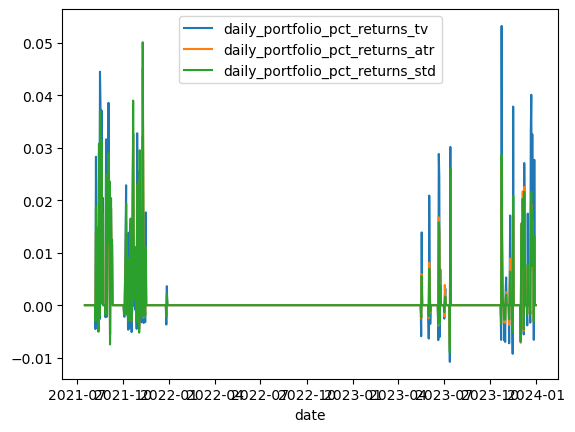

In [214]:
df_position_sizing_perf_long[['daily_portfolio_pct_returns_tv','daily_portfolio_pct_returns_atr','daily_portfolio_pct_returns_std']].plot()

<Axes: xlabel='date'>

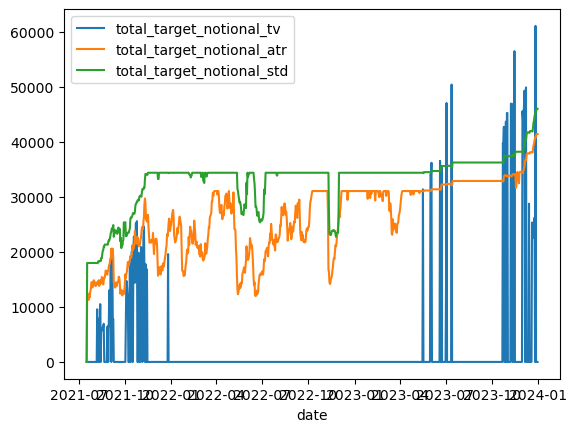

In [134]:
df_position_sizing_perf_long[['total_target_notional_tv','total_target_notional_atr','total_target_notional_std']].plot()

In [122]:
df_position_sizing_perf_long[['portfolio_trade_count_tv','portfolio_trade_count_atr','portfolio_trade_count_std']]#.plot()

,portfolio_trade_count_tv,portfolio_trade_count_atr,portfolio_trade_count_std
date,,,
2021-07-17,0.0,0.0,0.0
2021-07-18,0.0,0.0,0.0
2021-07-19,0.0,0.0,0.0
2021-07-20,0.0,0.0,0.0
2021-07-21,0.0,0.0,0.0
2021-07-22,0.0,0.0,0.0
2021-07-23,0.0,0.0,0.0
2021-07-24,0.0,0.0,0.0
2021-07-25,0.0,0.0,0.0


In [124]:
df_position_sizing_perf_long[['portfolio_trade_count_tv','portfolio_trade_count_atr','portfolio_trade_count_std']].sum()

portfolio_trade_count_tv     112.0
portfolio_trade_count_atr    112.0
portfolio_trade_count_std    112.0
dtype: float64

In [ ]:
df_target_vol_position_strategy_orig[df_target_vol_position_strategy_orig.index > pd.Timestamp('2021-08-05').date()].head(20)

In [ ]:
df_target_vol_position_sizing_long[df_target_vol_position_sizing_long.index > pd.Timestamp('2021-08-05').date()].head(20)

In [ ]:
df_position_sizing_perf_long[['total_portfolio_value_tv','total_portfolio_value_atr','total_portfolio_value_std']]

In [ ]:
df_position_sizing_perf_long[['total_portfolio_value_tv','total_portfolio_value_atr','total_portfolio_value_std']]

In [ ]:
df_position_sizing_perf_long[['available_cash_tv','available_cash_atr','available_cash_std']]

In [ ]:
tv_cols = []
for ticker in ticker_list:
    cols = [f'{ticker}_event',f'{ticker}_target_notional',#f'{ticker}_target_size',
            f'{ticker}_actual_position_notional']#,f'{ticker}_actual_size']
    tv_cols.extend(cols)

tv_cols.extend(['total_portfolio_value','portfolio_daily_pct_returns','available_cash','total_portfolio_value_upper_limit'])
df_position_sizing_perf_long = df_target_vol_position_strategy[tv_cols]

# tv_cols = []
# for ticker in ticker_list:
#     cols = [f'{ticker}_target_notional',f'{ticker}_target_size',f'{ticker}_actual_position_notional',f'{ticker}_actual_size']
#     tv_cols.extend(cols)

# tv_cols.extend(['total_portfolio_value','portfolio_daily_pct_returns','available_cash'])
df_target_vol_position_strategy[df_target_vol_position_strategy.index > pd.Timestamp('2021-08-11').date()][tv_cols].head(100)

In [ ]:
23198.417687-12287.704617

In [ ]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e6:.1f}M'

def thousands(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e3:.1f}K'

# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
layout = (2, 2)
btc_ax = plt.subplot2grid(layout, (0, 0))  # A single grid, but you can customize this layout
eth_ax = plt.subplot2grid(layout, (0, 1))  # A single grid, but you can customize this layout
ltc_ax = plt.subplot2grid(layout, (1, 0))  # A single grid, but you can customize this layout
sol_ax = plt.subplot2grid(layout, (1, 1))  # A single grid, but you can customize this layout

position_sizing_list = ['tv', 'atr', 'std']
for ps in position_sizing_list:
    _ = btc_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'BTC_target_notional_{ps}'], alpha=0.7, label=ps)
    _ = eth_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'ETH_target_notional_{ps}'], alpha=0.7, label=ps)
    _ = ltc_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'LTC_target_notional_{ps}'], alpha=0.7, label=ps)
    _ = sol_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'SOL_target_notional_{ps}'], alpha=0.7, label=ps)

# Add labels and title
_ = btc_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = btc_ax.set_xlabel('Date')
_ = btc_ax.set_ylabel('Target Notional ($)')
_ = btc_ax.set_title('BTC Target Notional by Position Sizing Strategy')
_ = btc_ax.grid(True)
_ = btc_ax.legend()

_ = eth_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = eth_ax.set_xlabel('Date')
_ = eth_ax.set_ylabel('Target Notional ($)')
_ = eth_ax.set_title('ETH Target Notional by Position Sizing Strategy')
_ = eth_ax.grid(True)
_ = eth_ax.legend()

_ = ltc_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = ltc_ax.set_xlabel('Date')
_ = ltc_ax.set_ylabel('Target Notional ($)')
_ = ltc_ax.set_title('LTC Target Notional by Position Sizing Strategy')
_ = ltc_ax.grid(True)
_ = ltc_ax.legend()

_ = sol_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = sol_ax.set_xlabel('Date')
_ = sol_ax.set_ylabel('Target Notional ($)')
_ = sol_ax.set_title('SOL Target Notional by Position Sizing Strategy')
_ = sol_ax.grid(True)
_ = sol_ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e6:.1f}M'

def thousands(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e3:.1f}K'

# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
layout = (2, 2)
btc_ax = plt.subplot2grid(layout, (0, 0))  # A single grid, but you can customize this layout
eth_ax = plt.subplot2grid(layout, (0, 1))  # A single grid, but you can customize this layout
ltc_ax = plt.subplot2grid(layout, (1, 0))  # A single grid, but you can customize this layout
sol_ax = plt.subplot2grid(layout, (1, 1))  # A single grid, but you can customize this layout

position_sizing_list = ['tv', 'atr', 'std']
for ps in position_sizing_list:
    _ = btc_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'BTC_actual_notional_{ps}'], alpha=0.7, label=ps)
    _ = eth_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'ETH_actual_notional_{ps}'], alpha=0.7, label=ps)
    _ = ltc_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'LTC_actual_notional_{ps}'], alpha=0.7, label=ps)
    _ = sol_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'SOL_actual_notional_{ps}'], alpha=0.7, label=ps)

# Add labels and title
_ = btc_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = btc_ax.set_xlabel('Date')
_ = btc_ax.set_ylabel('Target Notional ($)')
_ = btc_ax.set_title('BTC Target Notional by Position Sizing Strategy')
_ = btc_ax.grid(True)
_ = btc_ax.legend()

_ = eth_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = eth_ax.set_xlabel('Date')
_ = eth_ax.set_ylabel('Target Notional ($)')
_ = eth_ax.set_title('ETH Target Notional by Position Sizing Strategy')
_ = eth_ax.grid(True)
_ = eth_ax.legend()

_ = ltc_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = ltc_ax.set_xlabel('Date')
_ = ltc_ax.set_ylabel('Target Notional ($)')
_ = ltc_ax.set_title('LTC Target Notional by Position Sizing Strategy')
_ = ltc_ax.grid(True)
_ = ltc_ax.legend()

_ = sol_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = sol_ax.set_xlabel('Date')
_ = sol_ax.set_ylabel('Target Notional ($)')
_ = sol_ax.set_title('SOL Target Notional by Position Sizing Strategy')
_ = sol_ax.grid(True)
_ = sol_ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e6:.1f}M'

def thousands(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e3:.1f}K'

# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 8))
layout = (2, 1)
value_ax = plt.subplot2grid(layout, (0, 0))  # A single grid, but you can customize this layout
return_ax = plt.subplot2grid(layout, (1, 0))  # A single grid, but you can customize this layout

position_sizing_list = ['tv', 'atr', 'std']
for ps in position_sizing_list:
    _ = value_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'total_portfolio_value_{ps}'], alpha=0.7, label=ps)
    _ = return_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'daily_portfolio_pct_returns_{ps}'], alpha=0.7, label=ps)

# Add labels and title
_ = value_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = value_ax.set_xlabel('Date')
_ = value_ax.set_ylabel('Portfolio Value ($)')
_ = value_ax.set_title('Portfolio Value by Position Sizing Strategy')
_ = value_ax.grid(True)
_ = value_ax.legend()

# Add labels and title
# _ = return_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = return_ax.set_xlabel('Date')
_ = return_ax.set_ylabel('Portfolio Return (%)')
_ = return_ax.set_title('Portfolio Return by Position Sizing Strategy')
_ = return_ax.grid(True)
_ = return_ax.legend()


# Show plot
plt.tight_layout()
plt.show()

In [ ]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e6:.1f}M'

def thousands(x, pos):
    """The two args are the value and tick position."""
    return f'{x/1e3:.1f}K'

# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(16, 10))
layout = (3, 1)
value_ax = plt.subplot2grid(layout, (0, 0))  # A single grid, but you can customize this layout
return_ax = plt.subplot2grid(layout, (1, 0))  # A single grid, but you can customize this layout
cash_ax = plt.subplot2grid(layout, (2, 0))  # A single grid, but you can customize this layout


position_sizing_list = ['tv', 'atr', 'std']
for ps in position_sizing_list:
    _ = value_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'total_portfolio_value_{ps}'], alpha=0.7, label=ps)
    _ = return_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'daily_portfolio_pct_returns_{ps}'], alpha=0.7, label=ps)
    _ = cash_ax.plot(df_position_sizing_perf_long.index, df_position_sizing_perf_long[f'available_cash_{ps}'], alpha=0.7, label=ps)

# Add labels and title
_ = value_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = value_ax.set_xlabel('Date')
_ = value_ax.set_ylabel('Portfolio Value ($)')
_ = value_ax.set_title('Portfolio Value by Position Sizing Strategy')
_ = value_ax.grid(True)
_ = value_ax.legend()

# Add labels and title
# _ = return_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = return_ax.set_xlabel('Date')
_ = return_ax.set_ylabel('Portfolio Return (%)')
_ = return_ax.set_title('Portfolio Return by Position Sizing Strategy')
_ = return_ax.grid(True)
_ = return_ax.legend()


# _ = return_ax.yaxis.set_major_formatter(mtick.FuncFormatter(thousands))
_ = cash_ax.set_xlabel('Date')
_ = cash_ax.set_ylabel('Available Cash')
_ = cash_ax.set_title('Available Cash by Position Sizing Strategy')
_ = cash_ax.grid(True)
_ = cash_ax.legend()


# Show plot
plt.tight_layout()
plt.show()

In [ ]:
df_position_sizing_perf[df_position_sizing_perf['BTC_signal_x'] != df_position_sizing_perf['BTC_signal_y']].head()

In [ ]:
df_std_position_strategy[strat_cols].head()

## Target Volatility Position Sizing for Different T-Cost Estimates

In [ ]:
%%time
start_date = in_sample_start_date
end_date = in_sample_end_date
signal_start_date = pd.Timestamp('2021-07-17').date()
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.30
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = False

perf_cols = ['annualized_target_volatility','t_cost_est', 'fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_target_vol_long_short_t_cost = pd.DataFrame(columns=perf_cols)
for t_cost in np.arange(0.001, 0.01, 0.001):
    print(f'Estimated T-Cost: {t_cost}')
    df = size.apply_target_volatility_position_sizing_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window, long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                          volatility_window=volatility_window, transaction_cost_est=t_cost, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                          rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=np.round(annualized_target_volatility, 2),
                                                          annual_trading_days=annual_trading_days, use_specific_start_date=True, signal_start_date=signal_start_date)
    performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                      annual_trading_days=365, include_transaction_costs_and_fees=False)
    row = {
        'annualized_target_volatility': np.round(annualized_target_volatility,2),
        't_cost_est': t_cost,
        'fast_mavg': fast_mavg,
        'slow_mavg': slow_mavg,
        'stepsize': mavg_stepsize,
        'annualized_return': performance_metrics['annualized_return'],
        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
        'calmar_ratio': performance_metrics['calmar_ratio'],
        'annualized_std_dev': performance_metrics['annualized_std_dev'],
        'max_drawdown': performance_metrics['max_drawdown'],
        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
        'hit_rate': performance_metrics['hit_rate'],
        't_statistic': performance_metrics['t_statistic'],
        'p_value': performance_metrics['p_value'],
        'trade_count': performance_metrics['trade_count']
    }

    df_results_target_vol_long_short_t_cost = pd.concat([df_results_target_vol_long_short_t_cost, pd.DataFrame([row])], ignore_index=True)
# df_results_target_vol_long_short_t_cost['strategy_name'] = f'TVLS_' + df_results_target_vol_long_short['annualized_target_volatility'].astype(str)

In [ ]:
df_results_target_vol_long_short_t_cost

## Position Sizing using Average True Range

In [ ]:
def calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc='price', rolling_atr_window=20,
                                 use_coinbase_data=True):
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose', f'{ticker}_volume']

    
    ## Get T-1 Close Price
    df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)
    
    if price_or_returns_calc == 'price':
        # Calculate the Exponential Moving Average (EMA)
        # df[f'{ticker}_{rolling_atr_window}_ema_price'] = df['close'].ewm(span=rolling_atr_window,
        #                                                                  adjust=False).mean()

        # Calculate the True Range (TR) and Average True Range (ATR)
        df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
        df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_true_range_price'] = df[
            [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
            span=rolling_atr_window, adjust=False).mean()

        ## Shift by 1 to avoid look-ahead bias
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].shift(1)

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        # Calculate Middle Line as the EMA of returns
        df[f'{ticker}_{rolling_atr_window}_ema_returns'] = df[f'{ticker}_pct_returns'].ewm(span=rolling_atr_window,
                                                                                           adjust=False).mean()

        # Calculate True Range based on absolute returns
        df[f'{ticker}_true_range_returns'] = df[f'{ticker}_{rolling_atr_window}_ema_returns'].abs()

        # Calculate ATR using the EMA of the True Range
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'] = df[f'{ticker}_true_range_returns'].ewm(
            span=rolling_atr_window, adjust=False).mean()

        ## Shift by 1 to avoid look-ahead bias
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'] = df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'].shift(1)

    return df

In [ ]:
## Position Sizing Strategy will calculate Account Risk based on risk tolerance per trade and Trade Risk based on ATR or stop loss multiple
## Position Size will be determined by dividing the Account Risk by the Trade Risk
def get_position_sizing_using_atr(start_date, end_date, ticker_list, rolling_atr_window, initial_capital, risk_per_trade, stop_loss_multiple):

    atr_list = []
    for ticker in ticker_list:
        df_atr = calculate_average_true_range(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc='price',
                                              rolling_atr_window=rolling_atr_window, use_coinbase_data=True)
        
        ## Calculate Target Size and Notional based on the Average True Range
        target_size_col = f'{ticker}_target_size'
        target_notional_col = f'{ticker}_target_notional'
        atr_cols = [f'{ticker}_close',f'{ticker}_t_1_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price', target_size_col, target_notional_col]
        df_atr[target_size_col] = (initial_capital * risk_per_trade)/(df_atr[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] * stop_loss_multiple)
        df_atr[target_notional_col] = df_atr[f'{ticker}_target_size'] * df_atr[f'{ticker}_t_1_close']
        atr_list.append(df_atr[atr_cols])
        
    df_atr_ticker = pd.concat(atr_list, axis=1)
    
    ## Check if the sum of the target notionals for all tickers exceeds the initial capital
    # df_atr_ticker['scaling_factor'] = 1
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    # df_atr_ticker[f'total_target_notional'] = df_atr_ticker[target_notional_cols].sum(axis=1)
    # df_atr_ticker['scaling_factor'] = np.where(df_atr_ticker['total_target_notional'] > initial_capital, 
    #                                            initial_capital/df_atr_ticker['total_target_notional'], 1)
    # df_atr_ticker[target_notional_cols] = (
    #     df_atr_ticker[target_notional_cols].multiply(df_atr_ticker['scaling_factor'], axis=0))
    
    df_atr_ticker[f'total_target_notional'] = df_atr_ticker[target_notional_cols].sum(axis=1)
    df_atr_ticker['initial_capital'] = initial_capital
    
    return df_atr_ticker

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD']
df_target_position = get_position_sizing_using_atr(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_atr_window=20, 
                                                   initial_capital=20000, risk_per_trade=0.02, stop_loss_multiple=1)

In [ ]:
df_target_position.head()

In [ ]:
fig = plt.figure(figsize=(18,8))
layout = (2,2)
target_notional_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
price_ax = plt.subplot2grid(layout, (0,1))
total_target_notional_ax = plt.subplot2grid(layout, (1,0), colspan=2)
total_target_notional_ax2 = total_target_notional_ax.twinx()

date_cond = (df_target_position.index > pd.Timestamp('2017-06-30').date())
df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = target_notional_ax.plot(df_target_position_trim.index, df_target_position_trim[f'{ticker}_target_notional'], label=f'{ticker} Target Notional')
    _ = price_ax.plot(df_target_position_trim.index, df_target_position_trim[f'{ticker}_close'], label=f'{ticker}')
    
_ = total_target_notional_ax.plot(df_target_position_trim.index, df_target_position_trim[f'total_target_notional'], label=f'Total Target Notional', color='blue')
_ = total_target_notional_ax.plot(df_target_position_trim.index, df_target_position_trim[f'initial_capital'], label=f'Initial Capital', linestyle='--', color='orange')
_ = total_target_notional_ax2.plot(df_target_position_trim.index, df_target_position_trim[f'BTC-USD_close'], label=f'BTC-USD', linestyle='--', color='magenta')

_ = target_notional_ax.grid()
_ = target_notional_ax.legend(loc='upper left')
_ = target_notional_ax.set_title(f'Target Notional by Ticker')

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'Price by Ticker')

_ = total_target_notional_ax.grid()
_ = total_target_notional_ax.legend(loc='upper left')
_ = total_target_notional_ax2.legend(loc='upper right')
_ = total_target_notional_ax.set_title(f'Total Target Notional')

plt.tight_layout()

In [ ]:
import seaborn as sns
cols = ['BTC-USD_close','BTC-USD_target_notional','ETH-USD_close','ETH-USD_target_notional','SOL-USD_close','SOL-USD_target_notional','LTC-USD_close','LTC-USD_target_notional']
df_target_notional_corr = df_target_position[cols].corr()
sns.heatmap(df_target_notional_corr, annot=True)

In [ ]:
def reorder_columns_by_ticker(columns, tickers):
    ordered_columns = []
    for ticker in tickers:
        # Find all columns for this ticker
        ticker_columns = [col for col in columns if col.startswith(f"{ticker}")]
        # Add them to the ordered list
        ordered_columns.extend(sorted(ticker_columns))  # Sorting ensures a predictable order (e.g., open, close, volume)
    return ordered_columns

In [ ]:
def get_trend_donchian_signal_for_portfolio(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only=False,
                                            price_or_returns_calc='price'):

    ## Generate trend signal for all tickers
    trend_list = []
    date_list = cn.coinbase_start_date_by_ticker_dict
    for ticker in ticker_list:
        close_price_col = f'{ticker}'
        t_1_close_price_col = f'{ticker}_t_1_close'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        if pd.to_datetime(date_list[ticker]).date() > start_date:
            df_trend = generate_trend_signal_with_donchian_channel(start_date=pd.to_datetime(date_list[ticker]).date(), end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                             mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                             long_only=long_only)
        else:
            df_trend = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                             mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                             long_only=long_only)
        trend_cols = [close_price_col, signal_col, returns_col, trades_col]
        df_trend = df_trend[trend_cols]
        trend_list.append(df_trend)

    df_trend = pd.concat(trend_list, axis=1)

    return df_trend

In [ ]:
## TODO: MODIFY THIS FUNCTION TO ACCOUNT FOR TRANSACTION COST
def calculate_portfolio_cash_and_market_value_per_day(df, i, ticker_list, transaction_cost_est, passive_trade_rate):

    ## Calculate the estimated transaction costs and exchange fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    
    event_cols = [f'{ticker}_event' for ticker in ticker_list]
    actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
    target_position_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    actual_position_size_cols = [f'{ticker}_actual_size' for ticker in ticker_list]
    exit_price_cols = [f'{ticker}_actual_position_exit_price' for ticker in ticker_list]
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
        
    ## New Long Positions
    long_position_identifiers = ['New Long Position','New Long with Open Short Position']
    new_long_mask = df[event_cols].iloc[i].isin(long_position_identifiers)
    new_long_market_value = df[actual_position_notional_cols].iloc[i].where(new_long_mask.values).sum()
    new_target_long_market_value = df[target_position_notional_cols].iloc[i].where(new_long_mask.values).sum()
    # net_long_market_value = new_long_market_value * (1 - est_fees)
    ## We're subtracting target long market value from available cash because that what is paid prior to transaction costs
    ## The actual market value of the position is the target long market value minus transaction costs
    df['available_cash'][i] = df['available_cash'][i] - new_target_long_market_value#new_long_market_value

    ## New Short Positions
    ## Cash is generated from a New Short position and is stored as Short Sale Proceeds
    short_position_identifiers = ['New Short Position','New Short with Open Long Position']
    new_short_mask = df[event_cols].iloc[i].isin(short_position_identifiers)
    new_short_market_value = -df[actual_position_notional_cols].iloc[i].where(new_short_mask.values).sum()

    ## Closed Long Positions
    closing_long_mask = df[event_cols].iloc[i] == 'Closing Long Position'
    closing_long_masked_sizes = df[actual_position_size_cols].iloc[i-1].where(closing_long_mask.values).fillna(0).values
    closing_long_masked_prices = df[exit_price_cols].iloc[i].where(closing_long_mask.values).fillna(0).values
    closing_long_market_value = (closing_long_masked_sizes * closing_long_masked_prices).sum()
    net_closing_long_market_value = closing_long_market_value * (1 - est_fees)
    df['available_cash'][i] = df['available_cash'][i] + net_closing_long_market_value#closing_long_market_value

    ## Closed Short Positions
    closing_short_mask = df[event_cols].iloc[i] == 'Closing Short Position'
    closing_short_masked_sizes = df[actual_position_size_cols].iloc[i-1].where(closing_short_mask.values).fillna(0).values
    closing_short_masked_prices = df[exit_price_cols].iloc[i].where(closing_short_mask.values).fillna(0).values
    closing_short_market_value = (closing_short_masked_sizes * closing_short_masked_prices).sum()
    net_closing_short_market_value = closing_short_market_value * (1 - est_fees)
    short_sale_proceeds_value = df[short_sale_proceeds_cols].iloc[i-1].where(closing_short_mask.values).sum()
    df['available_cash'][i] = df['available_cash'][i] + (short_sale_proceeds_value + net_closing_short_market_value)#closing_short_market_value)

    ## Portfolio Positions
    df['count_of_positions'][i] = df[actual_position_notional_cols].iloc[i].ne(0).sum()
    df['total_actual_position_notional'][i] = df[actual_position_notional_cols].iloc[i].sum()
    df['total_portfolio_value'][i] = (df['available_cash'][i] +
                                      df[short_sale_proceeds_cols].iloc[i].sum() +
                                      df['total_actual_position_notional'][i])

    return df

In [ ]:
## Position Sizing Strategy will calculate Account Risk based on risk tolerance per trade and Trade Risk based on ATR or stop loss multiple
## Position Size will be determined by dividing the Account Risk by the Trade Risk
def get_atr_by_ticker(start_date, end_date, ticker_list, rolling_atr_window):#, initial_capital, risk_per_trade, stop_loss_multiple):

    atr_list = []
    for ticker in ticker_list:
        df_atr = calculate_average_true_range(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc='price',
                                              rolling_atr_window=rolling_atr_window, use_coinbase_data=True)
        
        ## Calculate Target Size and Notional based on the Average True Range
        target_size_col = f'{ticker}_target_size'
        target_notional_col = f'{ticker}_target_notional'
        atr_cols = [f'{ticker}_close',f'{ticker}_t_1_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price']
        atr_list.append(df_atr[atr_cols])
        
    df_atr_ticker = pd.concat(atr_list, axis=1)
    
    return df_atr_ticker

In [ ]:
def calculate_atr_target_notional(df, i, ticker_list, rolling_atr_window, risk_per_trade, stop_loss_multiple, t_1_porfolio_value_col='total_portfolio_value_upper_limit'):
    
    ## Calculate the target notional by ticker
    for ticker in ticker_list:
        df[f'{ticker}_account_risk'][i] = (df[t_1_porfolio_value_col][i] * risk_per_trade)# * (1 - cash_buffer_percentage)
        df[f'{ticker}_trade_risk'][i] = (df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'][i-1] * stop_loss_multiple)
        df[f'{ticker}_target_size'][i] = (df[f'{ticker}_account_risk'][i])/(df[f'{ticker}_trade_risk'][i])
        df[f'{ticker}_target_notional'][i] = df[f'{ticker}_target_size'][i] * df[f'{ticker}_t_1_close'][i]
    
    ## Calculate the total target notional for the day
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    df['total_target_notional'][i] = df[target_notional_cols].iloc[i].sum()

    ## Check if the Target Notional Positions need to be scaled
    if df['total_target_notional'][i] > df['total_portfolio_value_upper_limit'][i]:
        df['scaling_factor'][i] = df['total_portfolio_value_upper_limit'][i]/df['total_target_notional'].iloc[i]
        scaled_values = df[target_notional_cols].iloc[i].multiply(df['scaling_factor'].iloc[i], axis=0)
        df.iloc[i, df.columns.get_indexer(target_notional_cols)] = scaled_values.values
        df['total_target_notional'][i] = df[target_notional_cols].iloc[i].sum()
    
    
    return df

In [ ]:
def get_daily_portfolio_positions(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, rolling_atr_window, risk_per_trade, stop_loss_multiple,
                                  initial_capital, cash_buffer_percentage, transaction_cost_est=0.001, passive_trade_rate=0.05):

    ## Reorder dataframe columns
    col_list = []
    for ticker in ticker_list:
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_actual_position_entry_price'] = 0.0
        df[f'{ticker}_actual_position_exit_price'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_actual_size'] = 0.0
        df[f'{ticker}_account_risk'] = 0.0
        df[f'{ticker}_trade_risk'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = reorder_columns_by_ticker(df.columns, ticker_list)
    # ord_cols.extend(['total_target_notional','initial_capital'])
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['scaling_factor'] = 1.0
    
    ## Cash on Day 1 is all of the initial capital
    df['available_cash'][0] = initial_capital
    df['total_portfolio_value'][0] = initial_capital

    ## Set initial target size and notional values to 0
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    target_size_cols = [f'{ticker}_target_size' for ticker in ticker_list]
    df[target_size_cols] = 0.0
    df[target_notional_cols] = 0.0

    ## Estimate Transaction Costs & Fees per trade
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    event_cols = [f'{ticker}_event' for ticker in ticker_list]

    ## Identify Daily Positions
    for i in range(1, len(df)):
        ## Start the day with the available cash from yesterday
        df['available_cash'][i] = df['available_cash'][i-1]
        df['total_portfolio_value_upper_limit'][i] = df['total_portfolio_value'][i-1] * (1 - cash_buffer_percentage)

        ## Calculate the target notional by ticker
        df = calculate_atr_target_notional(df, i, ticker_list, rolling_atr_window, risk_per_trade, stop_loss_multiple)
            
        for ticker in ticker_list:
            t_1_close_price_col = f'{ticker}_t_1_close'
            signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
            target_position_notional_col = f'{ticker}_target_notional'
            target_position_size_col = f'{ticker}_target_size'
            actual_position_notional_col = f'{ticker}_actual_position_notional'
            actual_position_size_col = f'{ticker}_actual_size'
            actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
            actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'
            short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
            event_col = f'{ticker}_event'
            df[actual_position_notional_col][i] = 0.0
            df[actual_position_entry_price_col][i] = 0.0
            df[actual_position_size_col][i] = 0.0
            df[event_col][i] = np.nan

            ## TODO: Include Transaction Cost and Fees to all positions and market values
            ## Taking a New Long position
            if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
                net_long_notional = df[target_position_notional_col][i] * (1 - est_fees)
                df[actual_position_notional_col][i] = net_long_notional#df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[event_col][i] = 'New Long Position'
                
            ## Taking a New Short position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
                net_short_notional = -(df[target_position_notional_col][i] * (1 - est_fees))
                df[actual_position_notional_col][i] = net_short_notional#-df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = -df[actual_position_notional_col][i]
                df[event_col][i] = 'New Short Position'
                
            ## Amending an Open Long Position
            elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_size_col][i] = df[actual_position_size_col][i-1]
                df[actual_position_notional_col][i] = df[actual_position_size_col][i] * df[t_1_close_price_col][i]
                df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
                df[event_col][i] = 'Open Long Position'
                
            ## Amending an Open Short Position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_size_col][i] = df[actual_position_size_col][i-1]
                df[actual_position_notional_col][i] = df[actual_position_size_col][i] * df[t_1_close_price_col][i]
                df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
                df[short_sale_proceeds_col][i] = df[short_sale_proceeds_col][i-1]
                df[event_col][i] = 'Open Short Position'
                
            ## Taking a New Long Position with an Open Short Position
            elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                net_long_notional = df[target_position_notional_col][i] * (1 - est_fees)
                df[actual_position_notional_col][i] = net_long_notional#df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = 0.0
                df[event_col][i] = 'New Long with Open Short Position'
                
            ## Taking a New Short Position with an Existing Long Position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                net_short_notional = -(df[target_position_notional_col][i] * (1 - est_fees))
                df[actual_position_notional_col][i] = net_short_notional#-df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = -df[actual_position_notional_col][i]
                df[event_col][i] = 'New Short with Open Long Position'
            
            ## Closing a Long Position
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[actual_position_exit_price_col][i] = df[t_1_close_price_col][i]
                df[event_col][i] = 'Closing Long Position'
                
            ## Closing a Short Position
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[actual_position_exit_price_col][i] = df[t_1_close_price_col][i]
                df[short_sale_proceeds_col][i] = 0.0
                df[event_col][i] = 'Closing Short Position'

            ## No Event
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[short_sale_proceeds_col][i] = 0
                df[event_col][i] = 'No Event'

        ## Calculate Portfolio Value and Available Cash
        df = calculate_portfolio_cash_and_market_value_per_day(df, i, ticker_list, transaction_cost_est, passive_trade_rate)

    return df

In [ ]:
def apply_atr_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                       long_only=False, include_signal_strength=False, rolling_atr_window=20, stop_loss_multiple=1, transaction_cost_est=0.001, risk_per_trade=0.05, initial_capital=15000,
                                       passive_trade_rate=0.05, use_coinbase_data=True, rolling_sharpe_window=50, cash_buffer_percentage=0.10):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                       mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, long_only=long_only)

    ## Generate Target Position Size and Notional for all tickers
    # df_target_position = get_position_sizing_using_atr(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window, 
    #                                                    initial_capital=initial_capital, risk_per_trade=risk_per_trade, stop_loss_multiple=stop_loss_multiple)
    df_atr_ticker = get_atr_by_ticker(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window)

    ## Merge the Trend and Target Position Dataframes
    df = pd.merge(df_trend, df_atr_ticker, left_index=True, right_index=True, how='left')

    ## Get Daily Positions
    df = get_daily_portfolio_positions(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, rolling_atr_window, risk_per_trade,
                                       stop_loss_multiple, initial_capital, cash_buffer_percentage)

    ## Calculate Available Cash and Portfolio Positions
    # df = get_portfolio_cash_and_market_value(df, initial_capital, ticker_list)

    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    trade_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades' for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    # average_fee_per_trade = perf.estimate_fee_per_trade(passive_trade_rate=passive_trade_rate)
    # adjusted_daily_returns = df[f'portfolio_daily_pct_returns'] - (df[f'portfolio_trade_count']) * (transaction_cost_est + average_fee_per_trade)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    # df['portfolio_strategy_cumulative_return'] = (1 + adjusted_daily_returns).cumprod() - 1
    df['portfolio_strategy_cumulative_return'] = (1 + df['portfolio_daily_pct_returns']).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False,
                                                                               annual_trading_days=365))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})
    
    return df

In [ ]:
## In Sample Performance
in_sample_start_date = pd.Timestamp(2019, 1, 1).date()
in_sample_end_date = pd.Timestamp(2023, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2024, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2025, 1, 31).date()
full_sample_start_date = in_sample_start_date
full_sample_end_date = out_of_sample_end_date
signal_start_date = pd.Timestamp(2021, 7, 1).date()

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only=True
rolling_sharpe_window = 50
cash_buffer_percentage = 0.10
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_atr_long = size.apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                               mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                               stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only,
                                                               cash_buffer_percentage=cash_buffer_percentage, use_specific_start_date=True, signal_start_date=signal_start_date)
plot_portfolio_trend_following_performance(df_position_atr_long, signal_start_date, in_sample_end_date, rolling_sharpe_window)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_position_atr_long[df_position_atr_long.index >= signal_start_date], strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                            annual_trading_days=365, include_transaction_costs_and_fees=False)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_test, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                            annual_trading_days=365, include_transaction_costs_and_fees=False)

In [ ]:
df_test['portfolio_strategy_cumulative_return'] = np.where(df_position_atr_long.index >= signal_start_date, (1 + df_position_atr_long['portfolio_daily_pct_returns']).cumprod() - 1, 0)

In [ ]:
df_test.head()

In [ ]:
cols = ['BTC-USD_20_avg_true_range_price', 'BTC-USD_actual_position_notional', 'BTC-USD_actual_size',
       'BTC-USD_close', 'BTC-USD_event', 'BTC-USD_short_sale_proceeds',
       'BTC-USD_t_1_close', 'available_cash', 'count_of_positions',
       'total_actual_position_notional', 'total_target_notional',
       'total_portfolio_value', 'scaling_factor', 'BTC-USD_target_size',
       'BTC-USD_target_notional', 'portfolio_daily_pct_returns',
       'portfolio_trade_count', 'portfolio_strategy_cumulative_return',
       'portfolio_rolling_sharpe_50']

In [ ]:
df_position_atr_long[df_position_atr_long['ETH-USD'].notnull()].head(200)

In [ ]:
df_position_atr_long[df_position_atr_long['ETH-USD'].notnull()][['BTC-USD','ETH-USD']].plot()

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df_position_atr_long[df_position_atr_long['ETH-USD'].notnull()][target_notional_cols].plot()

In [ ]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only=True
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_atr_long = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        
        df_results_atr_long = pd.concat([df_results_atr_long, pd.DataFrame([row])], ignore_index=True)

df_results_atr_long['strategy_name'] = f'ATR_LO_' + df_results_atr_long['risk_per_trade'].astype(str) + '_' + df_results_atr_long['stop_loss_multiple'].astype(str)

In [ ]:
df_results_atr_long.sort_values('sharpe_ratio', ascending=False)

In [ ]:
cols = ['BTC-USD_actual_position_entry_price','BTC-USD_actual_position_exit_price','BTC-USD_target_notional', 'BTC-USD_target_size','BTC-USD','BTC-USD_actual_position_notional','BTC-USD_actual_size','BTC-USD_event',
        'ETH-USD_actual_position_entry_price','ETH-USD_actual_position_exit_price','ETH-USD_target_notional', 'ETH-USD_target_size','ETH-USD','ETH-USD_actual_position_notional','ETH-USD_actual_size','ETH-USD_event',
        'total_target_notional','available_cash','count_of_positions','total_actual_position_notional','total_portfolio_value','scaling_factor','portfolio_daily_pct_returns','portfolio_trade_count',
        'portfolio_strategy_cumulative_return','portfolio_rolling_sharpe_50']
df_position_atr_long[cols].head(1000)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only = False
rolling_sharpe_window = 50
cash_buffer_percentage = 0.10
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_atr_long_short = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                          mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                          stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only,
                                                         cash_buffer_percentage=cash_buffer_percentage)
plot_portfolio_trend_following_performance(df_position_atr_long_short, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only = False
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_atr_long_short = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = apply_atr_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }

        df_results_atr_long_short = pd.concat([df_results_atr_long_short, pd.DataFrame([row])], ignore_index=True)

df_results_atr_long_short['strategy_name'] = f'ATR_LS_' + df_results_atr_long_short['risk_per_trade'].astype(str) + '_' + df_results_atr_long_short['stop_loss_multiple'].astype(str)

In [ ]:
df_results_atr_long_short

In [ ]:
df_results_atr = pd.concat([df_results_atr_long, df_results_atr_long_short], axis=0, ignore_index=True)

In [ ]:
df_results_atr

In [ ]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

# Scatter plot
ax.scatter(df_results_atr_long_short['annualized_std_dev'], df_results_atr_long_short['annualized_return'], color='blue', alpha=0.7)
ax.scatter(df_results_atr_long['annualized_std_dev'], df_results_atr_long['annualized_return'], color='orange', alpha=0.7)

# Add labels next to each point
for i, row in df_results_atr_long_short.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_atr_long.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('ATR Strategy Efficient Frontier')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position_atr_long.index >= pd.Timestamp('2022-01-01').date()) & (df_position_atr_long.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position_atr_long.index, df_position_atr_long[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    # _ = actual_notional_ax.plot(df_position_atr_long.index, df_position_atr_long[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position_atr_long.index, df_position_atr_long[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax.plot(df_position_atr_long.index, df_position_atr_long[f'total_portfolio_value'], label=f'Portfolio Value', color='magenta')
_ = available_cash_ax2.plot(df_position_atr_long.index, df_position_atr_long[f'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], label=f'BTC Returns', color='green')
_ = available_cash_ax2.plot(df_position_atr_long.index, df_position_atr_long[f'portfolio_daily_pct_returns'], label=f'Portfolio Returns', color='orange')
# _ = available_cash_ax.plot(df_position_atr_long.index, df_position_atr_long[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long Only')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long Only')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position_atr_long_short.index >= pd.Timestamp('2022-01-01').date()) & (df_position_atr_long_short.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    _ = actual_notional_ax.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'total_portfolio_value'], label=f'Portfolio Value', color='magenta')
_ = available_cash_ax2.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], label=f'BTC Returns', color='green')
_ = available_cash_ax2.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'portfolio_daily_pct_returns'], label=f'Portfolio Returns', color='orange')
# _ = available_cash_ax.plot(df_position_atr_long_short.index, df_position_atr_long_short[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long/Short')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long/Short')

plt.tight_layout()

## Position Sizing using Annualized Standard Deviation

In [ ]:
def calculate_standard_deviation(start_date, end_date, ticker, rolling_std_window):

    ## Get Close Prices from Coinbase
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, end_date=end_date, save_to_file=False)
    df = (df[['close']].rename(columns={'close':ticker}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    df[f'{ticker}_t_1_close'] = df[ticker].shift(1)

    ## Calculate Annualized Standard Deviation
    df[f'{ticker}_pct_returns'] = df[f'{ticker}'].pct_change()
    df[f'{ticker}_{rolling_std_window}_std_dev'] = df[f'{ticker}_pct_returns'].rolling(window=rolling_std_window).std()
    
    ## Shift by 1 to avoid look-ahead bias
    df[f'{ticker}_{rolling_std_window}_std_dev'] = df[f'{ticker}_{rolling_std_window}_std_dev'].shift(1)

    return df

In [ ]:
## Position Sizing Strategy will calculate Account Risk based on risk tolerance per trade and Trade Risk based on ATR or stop loss multiple
## Position Size will be determined by dividing the Account Risk by the Trade Risk
def get_std_by_ticker(start_date, end_date, ticker_list, rolling_std_window):

    std_list = []
    for ticker in ticker_list:
        df_std = calculate_standard_deviation(start_date=start_date, end_date=end_date, ticker=ticker, rolling_std_window=rolling_std_window)
        
        ## Calculate Target Size and Notional based on the Standard Deviation
        std_cols = [f'{ticker}_t_1_close', f'{ticker}_{rolling_std_window}_std_dev']
        std_list.append(df_std[std_cols])
        
    df_std_ticker = pd.concat(std_list, axis=1)
    
    return df_std_ticker

In [ ]:
def calculate_std_target_notional(df, i, ticker_list, rolling_std_window, risk_per_trade, stop_loss_multiple, t_1_porfolio_value_col='total_portfolio_value_upper_limit'):
    
    ## Calculate the target notional by ticker
    for ticker in ticker_list:
        df[f'{ticker}_account_risk'][i] = (df[t_1_porfolio_value_col][i] * risk_per_trade)
        df[f'{ticker}_trade_risk'][i] = (df[f'{ticker}_t_1_close'][i] * df[f'{ticker}_{rolling_std_window}_std_dev'][i-1] * stop_loss_multiple)
        df[f'{ticker}_target_size'][i] = (df[f'{ticker}_account_risk'][i])/(df[f'{ticker}_trade_risk'][i])
        df[f'{ticker}_target_notional'][i] = df[f'{ticker}_target_size'][i] * df[f'{ticker}_t_1_close'][i]
    
    ## Calculate the total target notional for the day
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    df['total_target_notional'][i] = df[target_notional_cols].iloc[i].sum()

    ## Check if the Target Notional Positions need to be scaled
    if df['total_target_notional'][i] > df['total_portfolio_value_upper_limit'][i]:
        df['scaling_factor'][i] = df['total_portfolio_value_upper_limit'][i]/df['total_target_notional'].iloc[i]
        scaled_values = df[target_notional_cols].iloc[i].multiply(df['scaling_factor'].iloc[i], axis=0)
        df.iloc[i, df.columns.get_indexer(target_notional_cols)] = scaled_values.values
        
        ## Calculate revised target size
        for ticker in ticker_list:
            df[f'{ticker}_target_size'] = df[f'{ticker}_target_notional']/df[f'{ticker}_t_1_close']
        
        df['total_target_notional'][i] = df[target_notional_cols].iloc[i].sum()
    
    return df

In [ ]:
## Position Sizing Strategy will calculate Account Risk based on risk tolerance per trade and Trade Risk based on ATR or stop loss multiple
## Position Size will be determined by dividing the Account Risk by the Trade Risk
def get_position_sizing_using_std(start_date, end_date, ticker_list, rolling_std_window, initial_capital, risk_per_trade, stop_loss_multiple,
                                 annual_trading_days=365):

    std_list = []
    for ticker in ticker_list:
        df_std = calculate_standard_deviation(start_date=start_date, end_date=end_date, ticker=ticker, rolling_std_window=rolling_std_window)
        
        ## Calculate Target Size and Notional based on the Standard Deviation
        target_size_col = f'{ticker}_target_size'
        target_notional_col = f'{ticker}_target_notional'
        std_cols = [f'{ticker}', f'{ticker}_t_1_close', f'{ticker}_{rolling_std_window}_std_dev', target_size_col, target_notional_col]
        df_std[target_size_col] = (initial_capital * risk_per_trade)/(df_std[f'{ticker}_t_1_close'] * df_std[f'{ticker}_{rolling_std_window}_std_dev'] * stop_loss_multiple)
        df_std[target_notional_col] = df_std[f'{ticker}_target_size'] * df_std[f'{ticker}_t_1_close']
        std_list.append(df_std[std_cols])
        
    df_std_ticker = pd.concat(std_list, axis=1)
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]    
    df_std_ticker[f'total_target_notional'] = df_std_ticker[target_notional_cols].sum(axis=1)
    df_std_ticker['initial_capital'] = initial_capital
    
    return df_std_ticker

In [ ]:
def get_daily_portfolio_positions_std_position_sizing(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, rolling_std_window, risk_per_trade, stop_loss_multiple,
                                                      initial_capital, cash_buffer_percentage, transaction_cost_est=0.001, passive_trade_rate=0.05):

    ## Reorder dataframe columns
    col_list = []
    for ticker in ticker_list:
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_actual_position_entry_price'] = 0.0
        df[f'{ticker}_actual_position_exit_price'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_actual_size'] = 0.0
        df[f'{ticker}_account_risk'] = 0.0
        df[f'{ticker}_trade_risk'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = reorder_columns_by_ticker(df.columns, ticker_list)
    # ord_cols.extend(['total_target_notional','initial_capital'])
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['scaling_factor'] = 1.0
    
    ## Cash on Day 1 is all of the initial capital
    df['available_cash'][0] = initial_capital
    df['total_portfolio_value'][0] = initial_capital

    ## Set initial target size and notional values to 0
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    target_size_cols = [f'{ticker}_target_size' for ticker in ticker_list]
    df[target_size_cols] = 0.0
    df[target_notional_cols] = 0.0

    ## Estimate Transaction Costs & Fees per trade
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    event_cols = [f'{ticker}_event' for ticker in ticker_list]

    ## Identify Daily Positions
    for i in range(1, len(df)):
        ## Start the day with the available cash from yesterday
        df['available_cash'][i] = df['available_cash'][i-1]
        df['total_portfolio_value_upper_limit'][i] = df['total_portfolio_value'][i-1] * (1 - cash_buffer_percentage)

        ## Calculate the target notional by ticker
        df = calculate_std_target_notional(df, i, ticker_list, rolling_std_window, risk_per_trade, stop_loss_multiple)
            
        for ticker in ticker_list:
            t_1_close_price_col = f'{ticker}_t_1_close'
            signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
            target_position_notional_col = f'{ticker}_target_notional'
            target_position_size_col = f'{ticker}_target_size'
            actual_position_notional_col = f'{ticker}_actual_position_notional'
            actual_position_size_col = f'{ticker}_actual_size'
            actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
            actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'
            short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
            event_col = f'{ticker}_event'
            df[actual_position_notional_col][i] = 0.0
            df[actual_position_entry_price_col][i] = 0.0
            df[actual_position_size_col][i] = 0.0
            df[event_col][i] = np.nan

            ## TODO: Include Transaction Cost and Fees to all positions and market values
            ## Taking a New Long position
            if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
                net_long_notional = df[target_position_notional_col][i] * (1 - est_fees)
                df[actual_position_notional_col][i] = net_long_notional#df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[event_col][i] = 'New Long Position'
                
            ## Taking a New Short position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
                net_short_notional = -(df[target_position_notional_col][i] * (1 - est_fees))
                df[actual_position_notional_col][i] = net_short_notional#-df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = -df[actual_position_notional_col][i]
                df[event_col][i] = 'New Short Position'
                
            ## Amending an Open Long Position
            elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_size_col][i] = df[actual_position_size_col][i-1]
                df[actual_position_notional_col][i] = df[actual_position_size_col][i] * df[t_1_close_price_col][i]
                df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
                df[event_col][i] = 'Open Long Position'
                
            ## Amending an Open Short Position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_size_col][i] = df[actual_position_size_col][i-1]
                df[actual_position_notional_col][i] = df[actual_position_size_col][i] * df[t_1_close_price_col][i]
                df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
                df[short_sale_proceeds_col][i] = df[short_sale_proceeds_col][i-1]
                df[event_col][i] = 'Open Short Position'
                
            ## Taking a New Long Position with an Open Short Position
            elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                net_long_notional = df[target_position_notional_col][i] * (1 - est_fees)
                df[actual_position_notional_col][i] = net_long_notional#df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = 0.0
                df[event_col][i] = 'New Long with Open Short Position'
                
            ## Taking a New Short Position with an Existing Long Position
            elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                net_short_notional = -(df[target_position_notional_col][i] * (1 - est_fees))
                df[actual_position_notional_col][i] = net_short_notional#-df[target_position_notional_col][i]
                df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
                df[actual_position_size_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
                df[short_sale_proceeds_col][i] = -df[actual_position_notional_col][i]
                df[event_col][i] = 'New Short with Open Long Position'
            
            ## Closing a Long Position
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[actual_position_exit_price_col][i] = df[t_1_close_price_col][i]
                df[event_col][i] = 'Closing Long Position'
                
            ## Closing a Short Position
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[actual_position_exit_price_col][i] = df[t_1_close_price_col][i]
                df[short_sale_proceeds_col][i] = 0.0
                df[event_col][i] = 'Closing Short Position'

            ## No Event
            elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
                df[actual_position_notional_col][i] = 0
                df[actual_position_entry_price_col][i] = 0
                df[actual_position_size_col][i] = 0
                df[short_sale_proceeds_col][i] = 0
                df[event_col][i] = 'No Event'

        ## Calculate Portfolio Value and Available Cash
        df = calculate_portfolio_cash_and_market_value_per_day(df, i, ticker_list, transaction_cost_est, passive_trade_rate)

    return df

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD']#,'ADO-USD']
# df_std_target_position = get_position_sizing_using_std(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_std_window=20, 
#                                                        initial_capital=20000, risk_per_trade=0.02, stop_loss_multiple=1)
df_std_ticker = get_std_by_ticker(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_std_window=20)

In [ ]:
fig = plt.figure(figsize=(18,8))
layout = (2,2)
target_notional_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
price_ax = plt.subplot2grid(layout, (0,1))
total_target_notional_ax = plt.subplot2grid(layout, (1,0), colspan=2)
total_target_notional_ax2 = total_target_notional_ax.twinx()

date_cond = (df_std_target_position.index > pd.Timestamp('2017-06-30').date())
df_std_target_position_trim = df_std_target_position[date_cond]
for ticker in ticker_list:
    _ = target_notional_ax.plot(df_std_target_position_trim.index, df_std_target_position_trim[f'{ticker}_target_notional'], label=f'{ticker} Target Notional')
    _ = price_ax.plot(df_std_target_position_trim.index, df_std_target_position_trim[f'{ticker}'], label=f'{ticker}')
    
_ = total_target_notional_ax.plot(df_std_target_position_trim.index, df_std_target_position_trim[f'total_target_notional'], label=f'Total Target Notional', color='blue')
_ = total_target_notional_ax.plot(df_std_target_position_trim.index, df_std_target_position_trim[f'initial_capital'], label=f'Initial Capital', linestyle='--', color='orange')
_ = total_target_notional_ax2.plot(df_std_target_position_trim.index, df_std_target_position_trim[f'BTC-USD'], label=f'BTC-USD', linestyle='--', color='magenta')

_ = target_notional_ax.grid()
_ = target_notional_ax.legend(loc='upper left')
_ = target_notional_ax.set_title(f'Target Notional by Ticker')

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'Price by Ticker')

_ = total_target_notional_ax.grid()
_ = total_target_notional_ax.legend(loc='upper left')
_ = total_target_notional_ax2.legend(loc='upper right')
_ = total_target_notional_ax.set_title(f'Total Target Notional')

plt.tight_layout()

In [ ]:
def apply_std_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                       long_only=False, include_signal_strength=False, rolling_std_window=20, stop_loss_multiple=1, transaction_cost_est=0.001, risk_per_trade=0.02, initial_capital=15000,
                                       passive_trade_rate=0.05, use_coinbase_data=True, rolling_sharpe_window=50, cash_buffer_percentage=0.10):

    ## Generate Trend Signal for all tickers
    df_trend = get_trend_donchian_signal_for_portfolio(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                       mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, long_only=long_only)

    ## Generate Target Position Size and Notional for all tickers
    # df_target_position = get_position_sizing_using_std(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_std_window=rolling_std_window, 
    #                                                    initial_capital=initial_capital, risk_per_trade=risk_per_trade, stop_loss_multiple=stop_loss_multiple)
    df_std_ticker = get_std_by_ticker(start_date=start_date, end_date=end_date, ticker_list=ticker_list, rolling_std_window=rolling_std_window)

    ## Merge the Trend and Target Position Dataframes
    df = pd.merge(df_trend, df_std_ticker, left_index=True, right_index=True, how='left')

    ## Get Daily Positions
    df = get_daily_portfolio_positions_std_position_sizing(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, rolling_std_window, risk_per_trade,
                                                           stop_loss_multiple, initial_capital, cash_buffer_percentage)

    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    trade_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades' for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    df['portfolio_strategy_cumulative_return'] = (1 + df['portfolio_daily_pct_returns']).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
                                                                               strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False,
                                                                               annual_trading_days=365))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})
    
    return df

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only = True
rolling_sharpe_window = 50
cash_buffer_position = 0.10
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_std_long = size.apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                          mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                          stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only, cash_buffer_percentage=cash_buffer_percentage)
plot_portfolio_trend_following_performance(df_position_std_long, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only = True
rolling_sharpe_window = 50
cash_buffer_position = 0.10
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_std_long = apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                          mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                          stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only, cash_buffer_percentage=cash_buffer_percentage)
plot_portfolio_trend_following_performance(df_position_std_long, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
df_position_std_long.head()

In [ ]:
import seaborn as sns
cols = ['BTC-USD_20_std_dev','BTC-USD_target_notional','ETH-USD_20_std_dev','ETH-USD_target_notional','SOL-USD_20_std_dev','SOL-USD_target_notional','LTC-USD_20_std_dev','LTC-USD_target_notional']
df_target_notional_corr = df_position_std_long[cols].corr()
sns.heatmap(df_target_notional_corr, annot=True)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only = False
rolling_sharpe_window = 50
cash_buffer_position = 0.10
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_std_long_short = size.apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                                     stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only, cash_buffer_percentage=cash_buffer_percentage)
plot_portfolio_trend_following_performance(df_position_std_long_short, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
cols = ['BTC-USD', 'BTC-USD_t_1_close', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal', 'BTC-USD_account_risk', 'BTC-USD_trade_risk', 'BTC-USD_target_notional', 'BTC-USD_target_size', 'BTC-USD_event', 'BTC-USD_actual_position_notional', 'BTC-USD_actual_size', 'BTC-USD_actual_position_entry_price', 'BTC-USD_actual_position_exit_price', 'BTC-USD_short_sale_proceeds',
        'total_portfolio_value_upper_limit', 'available_cash', 'total_actual_position_notional', 'total_portfolio_value', 'scaling_factor', 'portfolio_daily_pct_returns', 'portfolio_strategy_cumulative_return', 'portfolio_rolling_sharpe_50']

In [ ]:
std_cond = (df_position_std_long_btc['BTC-USD_trade_risk'].notnull())
df_position_std_long_btc[std_cond][cols].tail(1000)

In [ ]:
360.000000/4.432627

In [ ]:
df_position_std_long_btc[['total_portfolio_value']].plot()

In [ ]:
%%time
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only = True
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_std_long = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }
        
        df_results_std_long = pd.concat([df_results_std_long, pd.DataFrame([row])], ignore_index=True)

df_results_std_long['strategy_name'] = f'STD_LO_' + df_results_std_long['risk_per_trade'].astype(str) + '_' + df_results_std_long['stop_loss_multiple'].astype(str)

In [ ]:
df_results_std_long.sort_values('sharpe_ratio', ascending=False)

In [ ]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

# Scatter plot
ax.scatter(df_results_atr_long['annualized_std_dev'], df_results_atr_long['annualized_return'], color='orange', alpha=0.7, label='ATR Strategy')
ax.scatter(df_results_std_long['annualized_std_dev'], df_results_std_long['annualized_return'], color='blue', alpha=0.7, label='STD Strategy')

# Add labels next to each point
for i, row in df_results_atr_long.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        # xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

for i, row in df_results_std_long.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('Strategy Efficient Frontier')
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
df_results_atr_long

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_std_window = 20
stop_loss_multiple = 1
risk_per_trade = 0.02
initial_capital = 20000
long_only = False
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
df_position_std_long_short = apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_std_window=rolling_std_window,
                                                                stop_loss_multiple=stop_loss_multiple, risk_per_trade=risk_per_trade, initial_capital=initial_capital, long_only=long_only)
plot_portfolio_trend_following_performance(df_position_std_long_short, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
df_position_std_long_short.head()

In [ ]:
%%time
fast_mavg = 50
slow_mavg = 250a
mavg_stepsize = 6
rolling_donchian_window = 20
rolling_atr_window = 20
# stop_loss_multiple = 1
# risk_per_trade = 0.02
initial_capital = 20000
long_only=False
rolling_sharpe_window = 50
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']#,'XRP-USD']
perf_cols = ['risk_per_trade','stop_loss_multiple','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_std_long_short = pd.DataFrame(columns=perf_cols)
for risk_per_trade in np.arange(0.01, 0.055, 0.01):
    for stop_loss_multiple in np.arange(1, 5, 1):
        print(f'Risk Per Trade: {np.round(risk_per_trade,3)} with Stop Loss Multiple: {stop_loss_multiple}')
        df = apply_std_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, rolling_atr_window=rolling_atr_window,
                                                stop_loss_multiple=stop_loss_multiple, risk_per_trade=np.round(risk_per_trade,2), initial_capital=initial_capital, long_only=long_only)
        performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                          annual_trading_days=365, include_transaction_costs_and_fees=False)
        row = {
            'risk_per_trade': risk_per_trade,
            'stop_loss_multiple': stop_loss_multiple,
            'fast_mavg': fast_mavg,
            'slow_mavg': slow_mavg,
            'stepsize': mavg_stepsize,
            'annualized_return': performance_metrics['annualized_return'],
            'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
            'calmar_ratio': performance_metrics['calmar_ratio'],
            'annualized_std_dev': performance_metrics['annualized_std_dev'],
            'max_drawdown': performance_metrics['max_drawdown'],
            'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
            'hit_rate': performance_metrics['hit_rate'],
            't_statistic': performance_metrics['t_statistic'],
            'p_value': performance_metrics['p_value'],
            'trade_count': performance_metrics['trade_count']
        }

        df_results_std_long_short = pd.concat([df_results_std_long_short, pd.DataFrame([row])], ignore_index=True)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_position_std_long, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                            annual_trading_days=365, include_transaction_costs_and_fees=False)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_position_std_long_short, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                            annual_trading_days=365, include_transaction_costs_and_fees=False)


In [ ]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position_std_long.index >= pd.Timestamp('2022-01-01').date()) & (df_position_std_long.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position_std_long.index, df_position_std_long[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    # _ = actual_notional_ax.plot(df_position_std_long.index, df_position_std_long[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position_std_long.index, df_position_std_long[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax.plot(df_position_std_long.index, df_position_std_long[f'total_portfolio_value'], label=f'Portfolio Value', color='magenta')
_ = available_cash_ax2.plot(df_position_std_long.index, df_position_std_long[f'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], label=f'BTC Returns', color='green')
_ = available_cash_ax2.plot(df_position_std_long.index, df_position_std_long[f'portfolio_daily_pct_returns'], label=f'Portfolio Returns', color='orange')
# _ = available_cash_ax.plot(df_position_std_long.index, df_position_std_long[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long Only')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long Only')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(18,8))
layout = (2,1)
actual_notional_ax = plt.subplot2grid(layout, (0,0), colspan=2)
available_cash_ax = plt.subplot2grid(layout, (1,0), colspan=2)
available_cash_ax2 = available_cash_ax.twinx()

date_cond = (df_position_std_long_short.index >= pd.Timestamp('2022-01-01').date()) & (df_position_std_long_short.index <= pd.Timestamp('2023-12-31').date())
# df_target_position_trim = df_target_position[date_cond]
for ticker in ticker_list:
    _ = actual_notional_ax.plot(df_position_std_long_short.index, df_position_std_long_short[f'{ticker}_actual_position_notional'], label=f'{ticker} Actual Notional')
    _ = actual_notional_ax.plot(df_position_std_long_short.index, df_position_std_long_short[f'{ticker}_short_sale_proceeds'], label=f'{ticker} Short Sale Proceeds')
_ = available_cash_ax.plot(df_position_std_long_short.index, df_position_std_long_short[f'available_cash'], label=f'Available Cash', color='blue')
_ = available_cash_ax.plot(df_position_std_long_short.index, df_position_std_long_short[f'total_portfolio_value'], label=f'Portfolio Value', color='magenta')
_ = available_cash_ax2.plot(df_position_std_long_short.index, df_position_std_long_short[f'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns'], label=f'BTC Returns', color='green')
_ = available_cash_ax2.plot(df_position_std_long_short.index, df_position_std_long_short[f'portfolio_daily_pct_returns'], label=f'Portfolio Returns', color='orange')
# _ = available_cash_ax.plot(df_position_std_long_short.index, df_position_std_long_short[f'initial_capital'], label=f'Initial Capital', linestyle='--')

_ = actual_notional_ax.grid()
_ = actual_notional_ax.legend(loc='upper left')
_ = actual_notional_ax.set_title(f'Actual Notional by Ticker - Long/Short')

_ = available_cash_ax.grid()
_ = available_cash_ax.legend(loc='upper left')
_ = available_cash_ax2.legend(loc='upper right')
_ = available_cash_ax.set_title(f'Available Cash in Portfolio - Long/Short')

plt.tight_layout()

In [ ]:
df_target_position = get_position_sizing_using_atr(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, rolling_atr_window=rolling_atr_window, 
                                                       initial_capital=initial_capital, risk_per_trade=risk_per_trade, stop_loss_multiple=stop_loss_multiple)

In [ ]:
df_target_position.head(20)

In [ ]:
def get_volatility_scaled_target_position_size(start_date, end_date, ticker, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                               position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, high_volatility_threshold=1.5,
                                               use_coinbase_data=True, price_or_returns_calc='price'):
    ## Calculate the Average True Range
    df = calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc, position_size_rolling_atr_window, use_coinbase_data)
    df = df[[f'{ticker}_close', f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price']].shift(1)

    ## Calculate Annualized Standard Deviation
    df[f'{ticker}_pct_returns'] = df[f'{ticker}_close'].pct_change()
    df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()
    
    # Annualize the standard deviation
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)
    
    # Shift to avoid lookahead bias
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

    ## Determine if the Volatility Regime is High or Low
    df[f'{ticker}_volatility_regime'] = np.where((df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] > high_volatility_threshold *
                                                  df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'].rolling(window=50).mean()), 'High', 'Low')
    df[f'{ticker}_volatility_regime'] = df[f'{ticker}_volatility_regime'].shift(1)

    ## Calculate Volatility Scaled Target Position
    if position_size_with_atr:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
        # df[f'{ticker}_atr_target_position_notional'] = np.where(df[f'{ticker}_volatility_regime'] == 'High', df[f'{ticker}_atr_target_position_notional'] * 0.5, df[f'{ticker}_atr_target_position_notional'])
    else:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)
        
    ## Cap position size to not exceed initial capital
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].fillna(0)
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].clip(upper=initial_capital)

    ## Shift position sizes by 1 to avoid lookahead bias
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].shift(1)
    
    return df

In [ ]:
rolling_atr_window=10
ticker = 'BTC-USD'
initial_capital = 15000
risk_per_trade = 0.2

## Calculate the Average True Range
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=rolling_atr_window,
                                     use_coinbase_data=True)
df_atr = df_atr[[f'{ticker}_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1)

## Calculate Annualized Standard Deviation
df_atr[f'{ticker}_pct_returns'] = df_atr[f'{ticker}_close'].pct_change()
position_size_rolling_atr_window = 10
position_size_atr_multiplier = 0.05
position_size_rolling_std_window = 20
position_size_std_multiplier = 10
df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df_atr[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()

# Annualize the standard deviation
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)

# Shift to avoid lookahead bias
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
# df_atr[f'{ticker}_atr_target_position_notional'] = np.where(df_atr[f'{ticker}_volatility_regime'] == 'High', df_atr[f'{ticker}_atr_target_position_notional'] * 0.5, df_atr[f'{ticker}_atr_target_position_notional'])
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)

df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].clip(upper=initial_capital)
df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].shift(1)

df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].clip(upper=initial_capital)
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].shift(1)

In [ ]:
df_atr.head(50)

In [ ]:
fig = plt.figure(figsize=(18,10))
layout = (3,2)
price_ax = plt.subplot2grid(layout, (0,0), colspan=2)
strategy_vol_ax = plt.subplot2grid(layout, (1,0), colspan=2)
strategy_vol_ax2 = strategy_vol_ax.twinx()
strategy_target_position_ax = plt.subplot2grid(layout, (2,0), colspan=2)
strategy_target_position_ax2 = strategy_target_position_ax.twinx()

date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
df_atr_trim = df_atr[date_cond]
_ = price_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='orange')
_ = strategy_vol_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='blue')
_ = strategy_vol_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
_ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_atr_vol_scaled_target_notional'], label=f'{ticker} ATR Target Notional', color='red')
_ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_std_vol_scaled_target_notional'], label=f'{ticker} STD Target Notional', color='green')
_ = strategy_target_position_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='blue', linestyle='--')
# _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'{ticker} Price')

_ = strategy_vol_ax.grid()
_ = strategy_vol_ax.legend(loc='upper left')
_ = strategy_vol_ax2.legend(loc='upper right')
_ = strategy_vol_ax.set_title(f'{ticker} Average True Range & Annualized Volatility')

_ = strategy_target_position_ax.grid()
_ = strategy_target_position_ax.legend(loc='upper left')
_ = strategy_target_position_ax2.legend(loc='upper right')
_ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(15,6))
layout = (1,1)
price_ax = plt.subplot2grid(layout, (0,0), colspan=2)
price_ax2 = price_ax.twinx()
# strategy_vol_ax = plt.subplot2grid(layout, (1,0), colspan=2)
# strategy_vol_ax2 = strategy_vol_ax.twinx()
# strategy_target_position_ax = plt.subplot2grid(layout, (2,0), colspan=2)
# strategy_target_position_ax2 = strategy_target_position_ax.twinx()

date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
df_atr_trim = df_atr[date_cond]
_ = price_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='orange')
_ = price_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
# _ = strategy_vol_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='blue')
# _ = strategy_vol_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
# _ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_atr_vol_scaled_target_notional'], label=f'{ticker} ATR Target Notional', color='red')
# _ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_std_vol_scaled_target_notional'], label=f'{ticker} STD Target Notional', color='green')
# _ = strategy_target_position_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='blue', linestyle='--')
# _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'{ticker} Price')

# _ = strategy_vol_ax.grid()
# _ = strategy_vol_ax.legend(loc='upper left')
# _ = strategy_vol_ax2.legend(loc='upper right')
# _ = strategy_vol_ax.set_title(f'{ticker} Average True Range & Annualized Volatility')

# _ = strategy_target_position_ax.grid()
# _ = strategy_target_position_ax.legend(loc='upper left')
# _ = strategy_target_position_ax2.legend(loc='upper right')
# _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

plt.tight_layout()

In [ ]:
df_atr[[f'{ticker}_close', f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price', f'{ticker}_{position_size_rolling_std_window}_annualized_volatility']].corr()

In [ ]:
df_atr[[f'{ticker}_close', f'{ticker}_atr_vol_scaled_target_notional', f'{ticker}_std_vol_scaled_target_notional']].corr()

In [ ]:
def apply_vol_adjusted_position_sizing_strategy(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                                long_only=False, include_signal_strength=False, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                                position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, use_coinbase_data=True,
                                                high_volatility_threshold=1.5, stop_loss_multiplier=1.5, take_profit_multiplier=3, apply_position_sizing_pyramid=True, position_sizing_pyramid_factor=0.5):

    close_price_col = f'{ticker}'
    t_1_close_price_col = f'{ticker}_t_1'
    signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
    target_position_notional_col = f'{ticker}_vol_scaled_target_notional'
    actual_position_notional_col = f'{ticker}_actual_position_notional'
    actual_position_shares_col = f'{ticker}_actual_position_share_count'
    actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
    atr_col = f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'
    std_col = f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'
    
    df = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                     long_only=long_only, include_signal_strength=include_signal_strength)
    trend_cols = [close_price_col, signal_col, returns_col, trades_col]
    df = df[trend_cols]
    df[t_1_close_price_col] = df[close_price_col].shift(1)
    
    df_position = get_volatility_scaled_target_position_size(start_date=start_date, end_date=end_date, ticker=ticker, position_size_with_atr=position_size_with_atr, 
                                                             position_size_rolling_atr_window=position_size_rolling_atr_window, position_size_atr_multiplier=position_size_atr_multiplier,
                                                             position_size_rolling_std_window=position_size_rolling_std_window, position_size_std_multiplier=position_size_std_multiplier,
                                                             risk_per_trade=risk_per_trade, initial_capital=initial_capital, high_volatility_threshold=high_volatility_threshold,
                                                             use_coinbase_data=use_coinbase_data, price_or_returns_calc=price_or_returns_calc)
    df = pd.merge(df, df_position, left_index=True, right_index=True, how='left')

    if apply_position_sizing_pyramid:
        ## Apply Position Sizing Pyramid Factor
        df[target_position_notional_col] = np.where((df[signal_col] == 1) | (df[signal_col] == -1), df[target_position_notional_col] * (1 + position_sizing_pyramid_factor),
                                                    df[target_position_notional_col])
    df[actual_position_notional_col] = 0.0
    df[actual_position_entry_price_col] = 0.0
    df[actual_position_shares_col] = 0.0
    df['portfolio_value'] = initial_capital
    df['event'] = np.nan
    
    position = 0
    entry_price = None
    
    for i in range(1, len(df)):
        ## Taking a New Long position
        if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Long Position: {df.index[i]}')
            # position = df[position_col][i]
            # entry_price = df[close_price_col][i]
            # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
            # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Long Position'
            
        ## Taking a New Short position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Short Position'
            
        ## Amending an Existing Long Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Amending an Existing Long Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Long Position'
            # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
            
        ## Amending an Existing Short Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Amending an Existing Short Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Short Position'
            
        ## Taking a New Long Position with an Existing Short Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Take a New Long Position with an Existing Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Long with Existing Short Position'
            
        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Take a New Short Position with an Existing Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Short with Existing Long Position'
        
        ## Closing a Long Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Closing a Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i]
            df['event'][i] = 'Closing Long Position'
            
        ## Closing a Short Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Closing a Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + (df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i])
            df['event'][i] = 'Closing Short Position'
    
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
            # print(f'Other: {df_test.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'No Event'
        
        
            
        # elif df[signal_col][i] == -1 and position > 0:
        #     initial_capital += position * (df[close_price_col][i] - entry_price)
        #     position = 0
        #     entry_price = None
        
        # # Stop-loss and take-profit logic
        # if position > 0:
        #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
        #         initial_capital += position * (df[close_price_col][i] - entry_price)
        #         position = 0
        #         entry_price = None
        
        # df.at[df.index[i], 'Capital'] = initial_capital

    return df

In [ ]:
df_strategy_atr = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                              rolling_donchian_window=20, position_size_with_atr=True, position_size_atr_multiplier=0.05)
df_strategy_std = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                              rolling_donchian_window=20, position_size_with_atr=False, position_size_std_multiplier=10)

In [ ]:
print(df_strategy_atr.shape)
print(df_strategy_std.shape)

In [ ]:
ticker

In [ ]:
df_strategy_atr.head()

In [ ]:
## TODO: Fix the below code, this doesn't work
def apply_pyramiding(df, ticker, position_col, atr_col, close_col, rolling_atr_window, add_position_atr_multiplier, max_pyramid_levels=3, risk_per_trade=0.05, initial_capital=15000):
    """
    Adjusts the target position by adding to the base position incrementally during a confirmed trend.
    
    Parameters:
    - df: DataFrame containing the price and ATR data.
    - ticker: Ticker symbol.
    - base_position_size: Initial position size.
    - atr_window: Number of periods for ATR calculation.
    - atr_multiplier: ATR-based threshold for adding positions.
    - max_pyramid_levels: Maximum number of incremental adds allowed.
    - risk_per_trade: Risk percentage for each add.
    
    Returns:
    - df with adjusted target positions considering pyramiding.
    """
    # df['current_position'] = base_position_size
    for level in range(1, max_pyramid_levels + 1):
        add_threshold = level * add_position_atr_multiplier * df[f'{ticker}_{rolling_atr_window}_avg_true_range_price']
        df[f'add_level_{level}'] = np.where(
            df[close_col].shift(1) > df[close_col].shift(1).cummax() + add_threshold, 
            df[position_col] * (1 + (level * risk_per_trade)),
            0
        )
        df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[position_col] + df[f'add_level_{level}']

    df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'].clip(upper=initial_capital)
    
    return df

In [ ]:
df_strategy_atr_pyramid = apply_pyramiding(df_strategy_atr, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', close_col=f'{ticker}',
                                           rolling_atr_window=20, add_position_atr_multiplier=2)

In [ ]:
df_strategy_atr_pyramid.head(500)

In [ ]:
df_strategy_atr_pyramid[df_strategy_atr_pyramid.add_level_2 != 0].head()

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=True, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.01, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [ ]:
df_position[['DOGE-USD_20_avg_true_range_price','DOGE-USD_pct_returns']].corr()

In [ ]:
df_position.head()

In [ ]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=False, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.05, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price',
    # rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_annualized_volatility'], label=f'{ticker} Annualized Vol', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Annualized Volatility')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [ ]:
def get_portfolio_performance(df_strategy, ticker, rolling_sharpe_window=50, annual_trading_days=252, annual_rf=0.05):

    short_position_event_list = ['New Short Position', 'Existing Short Position']
    df_strategy['portfolio_value_adj'] = np.where(df_strategy['event'].isin(short_position_event_list),
                                                  df_strategy['portfolio_value'] + (df_strategy[f'{ticker}_actual_position_share_count'] * df_strategy[f'{ticker}_actual_position_entry_price']),
                                                  df_strategy['portfolio_value'])
    df_strategy['strategy_pct_returns'] = df_strategy['portfolio_value_adj'].pct_change()
    
    # Calculate rolling mean and standard deviation for 50-day intervals
    rolling_mean = df_strategy['strategy_pct_returns'].rolling(window=rolling_sharpe_window).mean()
    rolling_std = df_strategy['strategy_pct_returns'].rolling(window=rolling_sharpe_window).std()
    
    # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
    df_strategy[f'{ticker}_rolling_sharpe_ratio_{rolling_sharpe_window}d'] = (rolling_mean - annual_rf)/rolling_std

    # Overall Sharpe Ratio
    average_daily_return = df_strategy['strategy_pct_returns'].mean()
    average_daily_std = df_strategy['strategy_pct_returns'].std()
    daily_rf = (1 + annual_rf) ** (1/annual_trading_days) - 1
    daily_sharpe_ratio = (average_daily_return - daily_rf) / average_daily_std
    annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(annual_trading_days)
    print("Overall Annualized Sharpe Ratio:", annualized_sharpe_ratio)

    return df_strategy    

In [ ]:
df_strategy_atr.head()

In [ ]:
df_strategy_atr = get_portfolio_performance(df_strategy_atr, ticker='BTC-USD', rolling_sharpe_window=50, annual_trading_days=365)
df_strategy_std = get_portfolio_performance(df_strategy_std, ticker='BTC-USD', rolling_sharpe_window=50, annual_trading_days=365)

In [ ]:
# short_position_event_list = ['New Short Position', 'Existing Short Position']
# df_strategy_atr['portfolio_value_adj'] = np.where(df_strategy_atr['event'].isin(short_position_event_list),
#                                               df_strategy_atr['portfolio_value'] + (df_strategy_atr[f'{ticker}_actual_position_share_count'] * df_strategy_atr[f'{ticker}_actual_position_entry_price']),
#                                               df_strategy_atr['portfolio_value'])
# df_strategy_atr['strategy_pct_returns'] = df_strategy_atr['portfolio_value_adj'].pct_change()

# # Calculate rolling mean and standard deviation for 50-day intervals
# rolling_mean = df_strategy_atr['strategy_pct_returns'].rolling(window=50).mean()
# rolling_std = df_strategy_atr['strategy_pct_returns'].rolling(window=50).std()

# # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
# df_strategy_atr[f'{ticker}_rolling_sharpe_ratio_50d'] = (rolling_mean * np.sqrt(annualization_factor))

In [ ]:
# Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
annualization_factor = 365  # number of trading days in a year
sharpe_ratio = (df_strategy_atr['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy_atr['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
print("Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
df_strategy_atr.head()

In [ ]:
position_size_rolling_atr_window = 20
all_ticker_non_pyramid_atr_df = {}
for ticker in ticker_list:
    print(ticker)
    df_strategy_atr = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20,
                                                     position_size_rolling_atr_window=position_size_rolling_atr_window, position_size_atr_multiplier=0.05, risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    df_strategy_atr = get_portfolio_performance(df_strategy_atr, ticker=ticker, rolling_sharpe_window=50, annual_trading_days=365)

    df_strategy_atr = df_strategy_atr[df_strategy_atr.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_atr_df[ticker] = df_strategy_atr
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Average True Range Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy_atr['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy_atr['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
all_ticker_non_pyramid_std_df = {}
for ticker in ticker_list:
    print(ticker)
    df_strategy_std = apply_vol_adjusted_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, position_size_with_atr=False,
                                                                  position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    df_strategy_std = get_portfolio_performance(df_strategy_std, ticker=ticker, rolling_sharpe_window=50, annual_trading_days=365)
    
    df_strategy_std = df_strategy_std[df_strategy_std.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_std_df[ticker] = df_strategy_std
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} Annualized Volatility', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy_std.index, df_strategy_std[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

## Position Sizing using a Target Volatility Strategy

In [ ]:
## Long Only
## Dates
signal_start_date = pd.Timestamp('2021-07-17').date()
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2023, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2024, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2026, 1, 31).date()
full_sample_start_date = in_sample_start_date
full_sample_end_date = out_of_sample_end_date

## Strategy Parameters
initial_capital = 20000
cash_buffer_percentage = 0.10
use_coinbase_data = True
rolling_sharpe_window = 50
transaction_cost_est=0.001
passive_trade_rate=0.05
long_only = True
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','ADA-USD','ALGO-USD','AAVE-USD']
use_specific_start_date=True

## Trend Following Parameters
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20

## ATR Parameters
rolling_atr_window = 20
atr_stop_loss_multiple = 1
atr_risk_per_trade = 0.02

## STD Parameters
rolling_std_window = 20
std_stop_loss_multiple = 1
std_risk_per_trade = 0.02

## Target Volatility Parameters
rolling_cov_window=20
volatility_window=20
annualized_target_volatility=0.20

In [ ]:
# ticker_list = ['BTC-USD','ETH-USD','SOL-USD','LTC-USD','DOGE-USD']

# ## Strategy Parameters
# fast_mavg = 50
# slow_mavg = 250
# mavg_stepsize = 6
# rolling_donchian_window = 20

# ## Volatility Parameters
# volatility_window = 20
# annual_trading_days = 365

# ## Initial Capital
# initial_capital = 15000

In [ ]:
date = pd.Timestamp('2018-10-11').date()
unscaled_weight_cols = [f'{ticker}_position_volatility_adjusted_weight' for ticker in ticker_list]
np.abs(df_target_vol_position_sizing_long_short.loc[date, unscaled_weight_cols].values)

In [ ]:
def reorder_columns_by_ticker(columns, tickers):
    ordered_columns = []
    for ticker in tickers:
        # Find all columns for this ticker
        ticker_columns = [col for col in columns if col.startswith(f"{ticker}")]
        # Add them to the ordered list
        ordered_columns.extend(sorted(ticker_columns))  # Sorting ensures a predictable order (e.g., open, close, volume)
    return ordered_columns

In [ ]:
# Function to calculate portfolio volatility
def calculate_portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))


# Function to calculate position sizes based on target volatility
def get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                          total_portfolio_value_upper_limit):
    ## Scale weights of positions to ensure the portfolio is in line with the target volatility
    unscaled_weight_cols = [f'{ticker}_position_volatility_adjusted_weight' for ticker in ticker_list]
    scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
    target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]

    if date not in df.index or date not in cov_matrix.index:
        raise ValueError(f"Date {date} not found in DataFrame or covariance matrix index.")

    ## Iterate through each day and calculate the covariance matrix, portfolio volatility and scaling factors
    daily_weights = np.abs(df.loc[date, unscaled_weight_cols].values)
    daily_cov_matrix = cov_matrix.loc[date].values
    daily_portfolio_volatility = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
    df.loc[date, 'daily_portfolio_volatility'] = daily_portfolio_volatility
    if daily_portfolio_volatility > 0:
        scaling_factor = daily_target_volatility / daily_portfolio_volatility
    else:
        scaling_factor = 0
    df.loc[date, 'target_vol_scaling_factor'] = scaling_factor

    # Scale the weights to target volatility
    scaled_weights = daily_weights * scaling_factor
    df.loc[date, scaled_weight_cols] = scaled_weights

    ## Calculate the target notional and size
    target_notionals = scaled_weights * total_portfolio_value_upper_limit
    df.loc[date, target_notional_cols] = target_notionals
    target_sizes = target_notionals / df.loc[date, t_1_price_cols].values

    for i, ticker in enumerate(ticker_list):
        df.loc[date, f'{ticker}_target_size'] = target_sizes[i]

    total_target_notional = target_notionals.sum()
    df.loc[date, 'total_target_notional'] = total_target_notional

    ## Check if the Target Notional is greater than the portfolio value
    if total_target_notional > total_portfolio_value_upper_limit:
        target_notional_scaling_factor = total_portfolio_value_upper_limit / total_target_notional
        df.loc[date, 'target_notional_scaling_factor'] = target_notional_scaling_factor
        adjusted_target_notionals = target_notionals * target_notional_scaling_factor
        df.loc[date, target_notional_cols] = adjusted_target_notionals

        adjusted_target_sizes = adjusted_target_notionals / df.loc[date, t_1_price_cols].values
        for i, ticker in enumerate(ticker_list):
            df.loc[date, f'{ticker}_target_size'] = adjusted_target_sizes[i]

        df.loc[date, 'total_target_notional'] = adjusted_target_notionals.sum()

    return df


In [ ]:
def get_target_volatility_daily_portfolio_positions(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                    rolling_donchian_window, initial_capital, rolling_cov_window,
                                                    cash_buffer_percentage, annualized_target_volatility,
                                                    transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                    annual_trading_days=365, use_specific_start_date=False,
                                                    signal_start_date=None):

    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index[0][0]
    df = df[df.index >= cov_matrix_start_date]

    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)

    ## Reorder dataframe columns
    col_list = []
    for ticker in ticker_list:
        df[f'{ticker}_actual_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_actual_position_entry_price'] = 0.0
        df[f'{ticker}_actual_position_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]

    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['target_notional_scaling_factor'] = 1.0

    ## Cash and the Total Portfolio Value on Day 1 is the initial capital for the strategy
    if use_specific_start_date:
        start_index_position = df.index.get_loc(signal_start_date)
    else:
        start_index_position = 0
    df['available_cash'][start_index_position] = initial_capital
    df['total_portfolio_value'][start_index_position] = initial_capital

    ## Identify Daily Positions starting from day 2
    for date in df.index[start_index_position + 1:]:
        previous_date = df.index[df.index.get_loc(date) - 1]

        ## Start the day with the available cash from yesterday
        df['available_cash'].loc[date] = df['available_cash'].loc[previous_date]
        total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[previous_date] *
                                             (1 - cash_buffer_percentage))
        df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit

        ## Calculate the target notional by ticker
        df = get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                   total_portfolio_value_upper_limit)

        ## Get the daily positions
        df = get_daily_positions_and_portfolio_cash(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg, rolling_donchian_window,
                                                    transaction_cost_est, passive_trade_rate)

        ## Portfolio Positions
        event_cols = [f'{ticker}_event' for ticker in ticker_list]
        actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
        target_position_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
        actual_position_size_cols = [f'{ticker}_actual_size' for ticker in ticker_list]
        exit_price_cols = [f'{ticker}_actual_position_exit_price' for ticker in ticker_list]
        short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
        df['count_of_positions'].loc[date] = df[actual_position_notional_cols].loc[date].ne(0).sum()
        df['total_actual_position_notional'].loc[date] = df[actual_position_notional_cols].loc[date].sum()
        df['total_portfolio_value'].loc[date] = (df['available_cash'].loc[date] +
                                                 df[short_sale_proceeds_cols].loc[date].sum() +
                                                 df['total_actual_position_notional'].loc[date])

        ## Calculate Portfolio Value and Available Cash
        # df = calculate_portfolio_cash_and_market_value_per_day(df, date, ticker_list, transaction_cost_est,
        #                                                        passive_trade_rate)

    return df

In [ ]:
def get_daily_positions_and_portfolio_cash(df, date, ticker_list, fast_mavg, mavg_stepsize, slow_mavg, rolling_donchian_window,
                                           transaction_cost_est, passive_trade_rate):

    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Estimated Transaction Costs and Fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    for ticker in ticker_list:
        t_1_close_price_col = f'{ticker}_t_1_close'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        target_position_notional_col = f'{ticker}_target_notional'
        target_position_size_col = f'{ticker}_target_size'
        actual_position_notional_col = f'{ticker}_actual_position_notional'
        actual_position_size_col = f'{ticker}_actual_size'
        actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
        actual_position_exit_price_col = f'{ticker}_actual_position_exit_price'
        short_sale_proceeds_col = f'{ticker}_short_sale_proceeds'
        event_col = f'{ticker}_event'
        df[actual_position_notional_col].loc[date] = 0.0
        df[actual_position_entry_price_col].loc[date] = 0.0
        df[actual_position_size_col].loc[date] = 0.0
        df[event_col].loc[date] = np.nan

        ## Taking a New Long position
        if (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == 0) and (
                df[actual_position_notional_col].loc[previous_date] == 0):
            # Building a cash buffer
            available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
            target_long_notional = df[target_position_notional_col].loc[date]
            if available_cash_buffer - target_long_notional > 0:
                net_long_notional = target_long_notional * (1 - est_fees)
                df[actual_position_notional_col].loc[date] = net_long_notional
                df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
                df[event_col].loc[date] = 'New Long Position'

        ## Taking a New Short position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == 0) and (
                df[actual_position_notional_col].loc[previous_date] == 0):
            # Building a cash buffer
            available_cash_buffer = df['available_cash'].loc[date] * (1 - 0.10)
            target_short_notional = df[target_position_notional_col].loc[date]
            if available_cash_buffer - target_short_notional > 0:
                net_short_notional = -(target_short_notional * (1 - est_fees))
                df[actual_position_notional_col].loc[date] = net_short_notional
                df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = -net_short_notional
                df[event_col].loc[date] = 'New Short Position'

        ## Open Long Position
        elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
            df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                          df[t_1_close_price_col].loc[date])
            df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
            df[event_col].loc[date] = 'Open Long Position'

        ## Open Short Position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == -1) and (
            df[actual_position_notional_col].loc[previous_date] < 0):
            df[actual_position_size_col].loc[date] = df[actual_position_size_col].loc[previous_date]
            df[actual_position_notional_col].loc[date] = (df[actual_position_size_col].loc[date] *
                                                          df[t_1_close_price_col].loc[date])
            df[actual_position_entry_price_col].loc[date] = df[actual_position_entry_price_col].loc[previous_date]
            df[short_sale_proceeds_col].loc[date] = df[short_sale_proceeds_col].loc[previous_date]
            df[event_col].loc[date] = 'Open Short Position'

        ## Taking a New Long Position with an Open Short Position
        elif (df[signal_col].loc[date] == 1) and (df[signal_col].loc[previous_date] == -1) and (
                df[actual_position_notional_col].loc[previous_date] < 0):
            target_long_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
            if target_long_notional > 0:
                net_long_notional = target_long_notional * (1 - est_fees)
                df[actual_position_notional_col].loc[date] = net_long_notional
                df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = 0.0
                df['available_cash'].loc[date] = df['available_cash'].loc[date] - target_long_notional
                df[event_col].loc[date] = 'New Long with Open Short Position'

        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col].loc[date] == -1) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            target_short_notional = min(df[target_position_notional_col].loc[date], df['available_cash'].loc[date])
            if target_short_notional > 0:
                net_short_notional = -(target_short_notional * (1 - est_fees))
                df[actual_position_notional_col].loc[date] = net_short_notional
                df[actual_position_entry_price_col].loc[date] = df[t_1_close_price_col].loc[date]
                df[actual_position_size_col].loc[date] = (df[actual_position_notional_col].loc[date] /
                                                          df[actual_position_entry_price_col].loc[date])
                df[short_sale_proceeds_col].loc[date] = -net_short_notional
                df[event_col].loc[date] = 'New Short with Open Long Position'

        ## Closing a Long Position
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == 1) and (
                df[actual_position_notional_col].loc[previous_date] > 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
            closing_long_market_value = (df[actual_position_size_col].loc[previous_date] *
                                         df[actual_position_exit_price_col].loc[date])
            net_closing_long_market_value = closing_long_market_value * (1 - est_fees)
            df['available_cash'].loc[date] = (df['available_cash'].loc[date] + net_closing_long_market_value)
            df[event_col].loc[date] = 'Closing Long Position'

        ## Closing a Short Position
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == -1) and (
                df[actual_position_notional_col].loc[previous_date] < 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            df[actual_position_exit_price_col].loc[date] = df[t_1_close_price_col].loc[date]
            df[short_sale_proceeds_col].loc[date] = 0.0
            closing_short_market_value = (df[actual_position_size_col].loc[previous_date] *
                                          df[actual_position_exit_price_col].loc[date])
            net_closing_short_market_value = closing_short_market_value * (1 - est_fees)
            short_sale_proceeds = df[short_sale_proceeds_col].loc[previous_date]
            df['available_cash'].loc[date] = (df['available_cash'].loc[date] +
                                              (net_closing_short_market_value + short_sale_proceeds))
            df[event_col].loc[date] = 'Closing Short Position'

        ## No Event
        elif (df[signal_col].loc[date] == 0) and (df[signal_col].loc[previous_date] == 0):
            df[actual_position_notional_col].loc[date] = 0
            df[actual_position_entry_price_col].loc[date] = 0
            df[actual_position_size_col].loc[date] = 0
            df[short_sale_proceeds_col].loc[date] = 0
            df[event_col].loc[date] = 'No Event'

    return df


In [ ]:
def calculate_portfolio_cash_and_market_value_per_day(df, date, ticker_list, transaction_cost_est, passive_trade_rate):
    ## Create Previous Date Index
    previous_date = df.index[df.index.get_loc(date) - 1]

    ## Calculate the estimated transaction costs and exchange fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

    event_cols = [f'{ticker}_event' for ticker in ticker_list]
    actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
    target_position_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
    actual_position_size_cols = [f'{ticker}_actual_size' for ticker in ticker_list]
    exit_price_cols = [f'{ticker}_actual_position_exit_price' for ticker in ticker_list]
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]

    ## New Long Positions
    long_position_identifiers = ['New Long Position', 'New Long with Open Short Position']
    new_long_mask = df[event_cols].loc[date].isin(long_position_identifiers)
    new_long_market_value = df[actual_position_notional_cols].loc[date].where(new_long_mask.values).sum()
    new_target_long_market_value = df[target_position_notional_cols].loc[date].where(new_long_mask.values).sum()
    # net_long_market_value = new_long_market_value * (1 - est_fees)
    ## We're subtracting target long market value from available cash because that what is paid prior to transaction costs
    ## The actual market value of the position is the target long market value minus transaction costs
    df['available_cash'].loc[date] = (df['available_cash'].loc[date] -
                                      new_target_long_market_value)

    ## New Short Positions
    ## Cash is generated from a New Short position and is stored as Short Sale Proceeds
    short_position_identifiers = ['New Short Position', 'New Short with Open Long Position']
    new_short_mask = df[event_cols].loc[date].isin(short_position_identifiers)
    new_short_market_value = -df[actual_position_notional_cols].loc[date].where(new_short_mask.values).sum()

    ## Closed Long Positions
    closing_long_mask = df[event_cols].loc[date] == 'Closing Long Position'
    closing_long_masked_sizes = (df[actual_position_size_cols].loc[previous_date]
                                 .where(closing_long_mask.values).fillna(0).values)
    closing_long_masked_prices = (df[exit_price_cols].loc[date]
                                  .where(closing_long_mask.values).fillna(0).values)
    closing_long_market_value = (closing_long_masked_sizes * closing_long_masked_prices).sum()
    net_closing_long_market_value = closing_long_market_value * (1 - est_fees)
    df['available_cash'].loc[date] = (df['available_cash'].loc[date] +
                                      net_closing_long_market_value)

    ## Closed Short Positions
    closing_short_mask = df[event_cols].loc[date] == 'Closing Short Position'
    closing_short_masked_sizes = (df[actual_position_size_cols].loc[previous_date]
                                  .where(closing_short_mask.values).fillna(0).values)
    closing_short_masked_prices = df[exit_price_cols].loc[date].where(closing_short_mask.values).fillna(0).values
    closing_short_market_value = (closing_short_masked_sizes * closing_short_masked_prices).sum()
    net_closing_short_market_value = closing_short_market_value * (1 - est_fees)
    short_sale_proceeds_value = df[short_sale_proceeds_cols].loc[previous_date].where(closing_short_mask.values).sum()
    df['available_cash'].loc[date] = (df['available_cash'].loc[date] +
                                      (short_sale_proceeds_value + net_closing_short_market_value))

    ## Portfolio Positions
    df['count_of_positions'].loc[date] = df[actual_position_notional_cols].loc[date].ne(0).sum()
    df['total_actual_position_notional'].loc[date] = df[actual_position_notional_cols].loc[date].sum()
    df['total_portfolio_value'].loc[date] = (df['available_cash'].loc[date] +
                                             df[short_sale_proceeds_cols].loc[date].sum() +
                                             df['total_actual_position_notional'].loc[date])

    return df

In [ ]:
# Get Volatility Adjusted Trend Signal for Target Volatility Strategy
def get_volatility_adjusted_trend_signal(df, ticker_list, volatility_window, fast_mavg, mavg_stepsize, slow_mavg,
                                         rolling_donchian_window, annual_trading_days=365):
    ticker_signal_dict = {}
    final_cols = []
    for ticker in ticker_list:
        trend_signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        trend_returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trend_trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        annualized_volatility_col = f'{ticker}_annualized_volatility_{volatility_window}'
        vol_adj_trend_signal_col = f'{ticker}_vol_adjusted_trend_signal'

        ## Calculate Position Volatility Adjusted Trend Signal
        df = tf.get_returns_volatility(df, vol_range_list=[volatility_window], close_px_col=f'{ticker}')
        df[annualized_volatility_col] = (df[f'{ticker}_volatility_{volatility_window}'] *
                                         np.sqrt(annual_trading_days))
        df[vol_adj_trend_signal_col] = (df[trend_signal_col] / df[annualized_volatility_col])
        df[vol_adj_trend_signal_col] = df[vol_adj_trend_signal_col].fillna(0)
        df[f'{ticker}_t_1_close'] = df[f'{ticker}'].shift(1)
        trend_cols = [f'{ticker}', f'{ticker}_t_1_close', f'{ticker}_pct_returns', trend_signal_col, trend_returns_col,
                      trend_trades_col, annualized_volatility_col, vol_adj_trend_signal_col]
        final_cols.append(trend_cols)
        ticker_signal_dict[ticker] = df[trend_cols]
    df_signal = pd.concat(ticker_signal_dict, axis=1)

    ## Assign new column names to the dataframe
    df_signal.columns = df_signal.columns.to_flat_index()
    final_cols = [item for sublist in final_cols for item in sublist]
    df_signal.columns = final_cols

    ## Normalize the weights of each position by the total weight of the portfolio
    vol_normalized_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in ticker_list]
    df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
    for ticker in ticker_list:
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = (df_signal[f'{ticker}_vol_adjusted_trend_signal'] /
                                                                      df_signal[vol_normalized_signal_cols].abs()
                                                                      .sum(axis=1))
        df_signal[f'{ticker}_position_volatility_adjusted_weight'] = df_signal[
            f'{ticker}_position_volatility_adjusted_weight'].fillna(0)

    return df_signal

In [ ]:
# Calculate Portfolio Returns and Rolling Sharpe Ratio
def calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                rolling_sharpe_window):
    ## Calculate Portfolio Returns
    df['portfolio_daily_pct_returns'] = df['total_portfolio_value'].pct_change()
    trade_cols = [
        f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        for ticker in ticker_list]
    df['portfolio_trade_count'] = np.abs(df[trade_cols]).sum(axis=1)
    df['portfolio_daily_pct_returns'] = df['portfolio_daily_pct_returns'].fillna(0)
    df['portfolio_strategy_cumulative_return'] = (1 + df['portfolio_daily_pct_returns']).cumprod() - 1

    ## Calculate Rolling Sharpe Ratio
    df[f'rolling_sharpe_{rolling_sharpe_window}'] = (perf.rolling_sharpe_ratio(
        df, window=rolling_sharpe_window, strategy_daily_return_col='portfolio_daily_pct_returns',
        strategy_trade_count_col='portfolio_trade_count', include_transaction_costs_and_fees=False,
        annual_trading_days=365))
    df = df.rename(
        columns={f'rolling_sharpe_{rolling_sharpe_window}': f'portfolio_rolling_sharpe_{rolling_sharpe_window}'})

    return df

In [ ]:
# Target Volatility Position Sizing Strategy for a Trend Following Signal
def apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg,
                                                     mavg_stepsize, rolling_donchian_window, long_only=False,
                                                     initial_capital=15000, rolling_cov_window=20, volatility_window=20,
                                                     transaction_cost_est=0.001, passive_trade_rate=0.05,
                                                     use_coinbase_data=True, rolling_sharpe_window=50,
                                                     cash_buffer_percentage=0.10, annualized_target_volatility=0.20,
                                                     annual_trading_days=365, use_specific_start_date=False,
                                                     signal_start_date=None):
    ## Generate Trend Signal for all tickers
    df_trend = tf.get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date,
                                                          ticker_list=ticker_list, fast_mavg=fast_mavg,
                                                          slow_mavg=slow_mavg,
                                                          mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window,
                                                          long_only=long_only, use_coinbase_data=use_coinbase_data)

    ## Get Volatility Adjusted Trend Signal
    df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize,
                                                     slow_mavg, rolling_donchian_window, annual_trading_days)

    ## Get Daily Positions
    df = get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize,
                                                         rolling_donchian_window, initial_capital, rolling_cov_window,
                                                         cash_buffer_percentage, annualized_target_volatility,
                                                         transaction_cost_est, passive_trade_rate, annual_trading_days,
                                                         use_specific_start_date, signal_start_date)

    ## Calculate Portfolio Performance
    df = calculate_portfolio_returns(df, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window,
                                     rolling_sharpe_window)

    return df

In [ ]:
df_target_vol_position_sizing_long = apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
                                                                                      initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
                                                                                      annualized_target_volatility, annual_trading_days)
plot_portfolio_trend_following_performance(df_target_vol_position_sizing_long, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
df_target_vol_position_sizing_long_possiz = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
                                                                                                  initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
                                                                                                  annualized_target_volatility, annual_trading_days)
plot_portfolio_trend_following_performance(df_target_vol_position_sizing_long_possiz, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
long_only = False
annualized_target_volatility = 0.99
df_target_vol_position_sizing_long_short = apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
                                                                                            initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
                                                                                            annualized_target_volatility, annual_trading_days)
plot_portfolio_trend_following_performance(df_target_vol_position_sizing_long_short, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
df_target_vol_position_sizing_long_short.available_cash.plot()

In [ ]:
df_target_vol_position_sizing_long_short[df_target_vol_position_sizing_long_short.available_cash < 0]#.shape

In [ ]:
long_only = False
annualized_target_volatility = 0.99
df_target_vol_position_sizing_long_short_possiz = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
                                                                                                        initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
                                                                                                        annualized_target_volatility, annual_trading_days)
plot_portfolio_trend_following_performance(df_target_vol_position_sizing_long_short_possiz, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
df_target_vol_position_sizing_long_short[df_target_vol_position_sizing_long_short['available_cash'] == 0]

In [ ]:
df_target_vol_position_sizing_long_short[df_target_vol_position_sizing_long_short.index > pd.Timestamp('2021-08-13').date()].head(100)

In [ ]:
event_cols = [f'{ticker}_event' for ticker in ticker_list]
df_target_vol_position_sizing_long_short[df_target_vol_position_sizing_long_short.index > pd.Timestamp('2021-08-13').date()][event_cols].head(100)

In [ ]:
df_target_vol_position_sizing_long_short[df_target_vol_position_sizing_long_short.index > pd.Timestamp('2021-08-13').date()][['available_cash','total_portfolio_value','total_portfolio_value_upper_limit']].head(100)

In [ ]:
26786.724642-18728.627147

In [ ]:
df_target_vol_position_sizing_long_short_possiz['available_cash'].plot()

In [ ]:
# start_date = in_sample_start_date
# end_date = in_sample_end_date
# fast_mavg = fast_mavg
# slow_mavg = slow_mavg
# mavg_stepsize = mavg_stepsize
# rolling_donchian_window = rolling_donchian_window
# price_or_returns_calc='price'
# long_only=False
# transaction_cost_est=0.001
# initial_capital=20000
# rolling_cov_window=20
# volatility_window=20
# passive_trade_rate=0.05
# use_coinbase_data=True
# rolling_sharpe_window=50
# cash_buffer_percentage=0.10
# annualized_target_volatility=0.20
# annual_trading_days=365 
# ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
# long_only = True
# df_target_vol_position_sizing_long = apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
#                                                                                       initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
#                                                                                       annualized_target_volatility, annual_trading_days)
# plot_portfolio_trend_following_performance(df_target_vol_position_sizing_long, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = True
df_target_vol_position_sizing_long = size.apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
                                                                                           initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
                                                                                           annualized_target_volatility, annual_trading_days)
plot_portfolio_trend_following_performance(df_target_vol_position_sizing_long, start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, price_or_returns_calc, rolling_donchian_window, rolling_sharpe_window)

In [ ]:
df_target_vol_position_sizing_long#.head(200)

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = False
df_target_vol_position_sizing_long_short = apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, long_only, 
                                                                                            initial_capital, rolling_cov_window, volatility_window, transaction_cost_est, passive_trade_rate, use_coinbase_data, rolling_sharpe_window, cash_buffer_percentage,
                                                                                            annualized_target_volatility, annual_trading_days)

In [ ]:
daily_target_volatility = annualized_target_volatility/np.sqrt(annual_trading_days)
print(daily_target_volatility)

In [ ]:
%%time
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = True

perf_cols = ['annualized_target_volatility','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_target_vol_long = pd.DataFrame(columns=perf_cols)
for ann_target_vol in np.arange(0.05, 0.76, 0.05):
    print(f'Annualized Target Volatility: {np.round(ann_target_vol,2)}')
    df = apply_target_volatility_position_sizing_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window, long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                          volatility_window=volatility_window, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                          rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=np.round(ann_target_vol, 2),
                                                          annual_trading_days=annual_trading_days)
    performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                      annual_trading_days=365, include_transaction_costs_and_fees=False)
    row = {
        'annualized_target_volatility': np.round(ann_target_vol,2),
        'fast_mavg': fast_mavg,
        'slow_mavg': slow_mavg,
        'stepsize': mavg_stepsize,
        'annualized_return': performance_metrics['annualized_return'],
        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
        'calmar_ratio': performance_metrics['calmar_ratio'],
        'annualized_std_dev': performance_metrics['annualized_std_dev'],
        'max_drawdown': performance_metrics['max_drawdown'],
        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
        'hit_rate': performance_metrics['hit_rate'],
        't_statistic': performance_metrics['t_statistic'],
        'p_value': performance_metrics['p_value'],
        'trade_count': performance_metrics['trade_count']
    }

    df_results_target_vol_long = pd.concat([df_results_target_vol_long, pd.DataFrame([row])], ignore_index=True)
df_results_target_vol_long['strategy_name'] = f'Target_Vol_LO_' + df_results_target_vol_long['ann_target_vol'].astype(str)

In [ ]:
df_results_target_vol_long

In [ ]:
%%time
start_date = in_sample_start_date
end_date = in_sample_end_date
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=20000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD']
long_only = False

perf_cols = ['annualized_target_volatility','fast_mavg','slow_mavg','stepsize','annualized_return','sharpe_ratio','calmar_ratio','annualized_std_dev','max_drawdown','max_drawdown_duration',
             'hit_rate','t_statistic','p_value','trade_count']
df_results_target_vol_long_short = pd.DataFrame(columns=perf_cols)
for ann_target_vol in np.arange(0.05, 0.76, 0.05):
    print(f'Annualized Target Volatility: {np.round(ann_target_vol,2)}')
    df = apply_target_volatility_position_sizing_strategy(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                          rolling_donchian_window=rolling_donchian_window, long_only=long_only, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
                                                          volatility_window=volatility_window, transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate, use_coinbase_data=use_coinbase_data,
                                                          rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=np.round(ann_target_vol, 2),
                                                          annual_trading_days=annual_trading_days)
    performance_metrics = perf.calculate_risk_and_performance_metrics(df, strategy_daily_return_col='portfolio_daily_pct_returns', strategy_trade_count_col='portfolio_trade_count',
                                                                      annual_trading_days=365, include_transaction_costs_and_fees=False)
    row = {
        'annualized_target_volatility': np.round(ann_target_vol,2),
        'fast_mavg': fast_mavg,
        'slow_mavg': slow_mavg,
        'stepsize': mavg_stepsize,
        'annualized_return': performance_metrics['annualized_return'],
        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
        'calmar_ratio': performance_metrics['calmar_ratio'],
        'annualized_std_dev': performance_metrics['annualized_std_dev'],
        'max_drawdown': performance_metrics['max_drawdown'],
        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
        'hit_rate': performance_metrics['hit_rate'],
        't_statistic': performance_metrics['t_statistic'],
        'p_value': performance_metrics['p_value'],
        'trade_count': performance_metrics['trade_count']
    }

    df_results_target_vol_long_short = pd.concat([df_results_target_vol_long_short, pd.DataFrame([row])], ignore_index=True)
df_results_target_vol_long_short['strategy_name'] = f'Target_Vol_LS_' + df_results_target_vol_long_short['annualized_target_volatility'].astype(str)

In [ ]:
df_results_target_vol_long_short

In [ ]:
df_results_target_vol_long['strategy_name'] = f'TVol_LO_' + df_results_target_vol_long['annualized_target_volatility'].astype(str)
df_results_target_vol_long_short['strategy_name'] = f'TVol_LS_' + df_results_target_vol_long_short['annualized_target_volatility'].astype(str)

In [ ]:
# Create a figure and use subplot2grid for layout
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot2grid((1, 1), (0, 0))  # A single grid, but you can customize this layout

# Scatter plot
ax.scatter(df_results_target_vol_long['annualized_std_dev'], df_results_target_vol_long['annualized_return'], color='orange', alpha=0.7, label='Target Volatility Strategy')
# ax.scatter(df_results_target_vol_long_short['annualized_std_dev'], df_results_target_vol_long_short['annualized_return'], color='blue', alpha=0.7, label='STD Strategy')

# Add labels next to each point
for i, row in df_results_target_vol_long.iterrows():
    ax.annotate(
        row['strategy_name'], 
        (row['annualized_std_dev'], row['annualized_return']),
        textcoords="offset points", # Position the text slightly off the point
        # xytext=(5, 5),              # Offset text by (5, 5)
        ha='left',                  # Horizontal alignment
        fontsize=9                  # Font size
    )

# for i, row in df_results_target_vol_long_short.iterrows():
#     ax.annotate(
#         row['strategy_name'], 
#         (row['annualized_std_dev'], row['annualized_return']),
#         textcoords="offset points", # Position the text slightly off the point
#         xytext=(5, 5),              # Offset text by (5, 5)
#         ha='left',                  # Horizontal alignment
#         fontsize=9                  # Font size
#     )

# Add labels and title
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Annualized Return')
ax.set_title('Strategy Efficient Frontier')
ax.legend(loc='upper left')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
ticker = 'BTC-USD'
final_cols = []
portfolio_cols = ['daily_portfolio_volatility','target_vol_scaling_factor','target_notional_scaling_factor','total_portfolio_value_upper_limit','available_cash','portfolio_daily_pct_returns']
for ticker in ticker_list:
    cols = [f'{ticker}_event', f'{ticker}_annualized_volatility_20', f'{ticker}_vol_adjusted_trend_signal', f'{ticker}_position_volatility_adjusted_weight',
            f'{ticker}_target_vol_normalized_weight',f'{ticker}_target_notional',f'{ticker}_target_size',f'{ticker}_actual_position_notional',f'{ticker}_actual_size']
    final_cols.extend(cols)

final_cols.extend(portfolio_cols)

In [ ]:
event_status_list = ['New Long Position','Open Long Position','Closing Long Position']
cond = (df_target_vol_position_sizing['BTC-USD_event'].isin(event_status_list)) | (df_target_vol_position_sizing['ETH-USD_event'].isin(event_status_list))
df_target_vol_position_sizing_long[cond][final_cols]

In [ ]:
df_target_vol_position_sizing_long[final_cols]

In [ ]:
df_target_vol_position_sizing_long['total_portfolio_value'].plot()

In [ ]:
df_target_vol_position_sizing_long['total_portfolio_value'].plot()

In [ ]:
df_target_vol_position_sizing_long_short['total_portfolio_value'].plot()

In [ ]:
df_target_vol_position_sizing_long_short[['total_portfolio_value','available_cash']].plot()

In [ ]:
df_target_vol_position_sizing_long_short[df_target_vol_position_sizing_long_short.index > pd.Timestamp('2018-10-09').date()].head(1000)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_target_vol_position_sizing_long, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='portfolio_trade_count',
                                            annual_trading_days=365, passive_trade_rate=0.005, include_transaction_costs_and_fees=False)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_target_vol_position_sizing_long_short, strategy_daily_return_col='portfolio_daily_pct_returns',
                                            strategy_trade_count_col='portfolio_trade_count',
                                            annual_trading_days=365, passive_trade_rate=0.005, include_transaction_costs_and_fees=False)

In [ ]:
df_target_vol_position_sizing[df_target_vol_position_sizing['available_cash'] < 0].shape

In [ ]:
ticker = 'ETH-USD'
cols = [f'{ticker}_event', f'{ticker}_annualized_volatility_20', f'{ticker}_vol_adjusted_trend_signal', f'{ticker}_position_volatility_adjusted_weight','daily_portfolio_volatility',
        'target_vol_scaling_factor', 'target_notional_scaling_factor', f'{ticker}_target_vol_normalized_weight','total_portfolio_value_upper_limit',f'{ticker}_target_notional',f'{ticker}_target_size']# for ticker in ticker_list]

In [ ]:
df_target_vol_position_sizing[df_target_vol_position_sizing['ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades'] != 0][cols]

In [ ]:
df_target_vol_position_sizing[df_target_vol_position_sizing['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades'] != 0].head(20)

In [ ]:
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
cov_matrix = df_signal[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

In [ ]:
cov_matrix.index[0][0]

In [ ]:
df_target_vol_position_sizing['total_portfolio_value'].plot()

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
ticker_list = ticker_list
fast_mavg = fast_mavg
slow_mavg = slow_mavg
mavg_stepsize = mavg_stepsize
rolling_donchian_window = rolling_donchian_window
price_or_returns_calc='price'
long_only=False
transaction_cost_est=0.001
initial_capital=15000
rolling_cov_window=20
volatility_window=20
passive_trade_rate=0.05
use_coinbase_data=True
rolling_sharpe_window=50
cash_buffer_percentage=0.10
annualized_target_volatility=0.20
annual_trading_days=365 
ticker_list = ['BTC-USD']

# ## Generate Trend Signal for all tickers
df_trend = get_trend_donchian_signal_for_portfolio(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                   mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, long_only=long_only)

## Get Volatility Adjusted Trend Signal
df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize, slow_mavg, rolling_donchian_window, annual_trading_days)

## Get Daily Positions
# df = get_target_volatility_daily_portfolio_positions(df_signal, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, initial_capital, rolling_cov_window, cash_buffer_percentage, annualized_target_volatility,
#                                                      transaction_cost_est, passive_trade_rate)
# df = df_signal.copy()

In [ ]:
# # Function to calculate portfolio volatility
# def calculate_portfolio_volatility(weights, covariance_matrix):
#     return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

# def get_target_volatility_position_sizing(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, volatility_window, annual_trading_days,
#                                           rolling_cov_window, annualized_target_volatility, price_or_returns_calc='price', long_only=True):

#     ## STEP 1: Volatility normalized Trend Signal for each position
#     ## Generate trend signal for each ticker in the portfolio
#     df_trend = get_trend_donchian_signal_for_portfolio(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
#                                                        rolling_donchian_window=rolling_donchian_window, long_only=long_only)

#     ## Get Volatility Adjusted Trend Signal
#     df_signal = get_volatility_adjusted_trend_signal(df_trend, ticker_list, volatility_window, fast_mavg, mavg_stepsize, slow_mavg, rolling_donchian_window, annual_trading_days)

#     ## Calculate the covariance matrix for tickers in the portfolio
#     returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
#     cov_matrix = df_signal[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

#     ## Derive the Daily Target Portfolio Volatility
#     daily_target_volatility = annualized_target_volatility/np.sqrt(annual_trading_days)
    
#     ## Scale weights of positions to ensure the portfolio is in line with the target volatility
#     unscaled_weight_cols = [f'{ticker}_position_volatility_adjusted_weight' for ticker in ticker_list]
#     scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
#     price_cols = [f'{ticker}_close' for ticker in ticker_list]
#     t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
#     portfolio_cols = []
#     portfolio_cols.extend(scaled_weight_cols)
#     df_scaled_weights = pd.DataFrame(index=df_signal.index, columns=portfolio_cols)

#     ## Iterate through each day and calculate the covariance matrix, portfolio volatility and scaling factors
#     for date in df_signal.index:
#         if date in cov_matrix.index.get_level_values(0):
#             daily_weights = df_signal[unscaled_weight_cols].loc[date].values
#             daily_cov_matrix = cov_matrix.loc[date].values
#             portfolio_volatility = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
            
#             # Scale the weights to target volatility
#             scaling_factor = daily_target_volatility / portfolio_volatility
#             df_scaled_weights.loc[date][scaled_weight_cols] = daily_weights * scaling_factor

#     ## Delete rows prior to the first available date of the covariance matrix
#     df_scaled_weights = df_scaled_weights[df_scaled_weights.index >= cov_matrix.index[0][0]]
    
#     return df_scaled_weights

In [ ]:
cov_matrix.head(50)

In [ ]:
df_scaled_weights.head()

In [ ]:
df_signal[df_signal['BTC-USD_position_volatility_adjusted_weight'] > 0].head(200)

In [ ]:
1/0.152422

In [ ]:
ticker_list = ['BTC-USD', 'ETH-USD']# 'SOL-USD', 'LTC-USD', 'DOGE-USD']
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
volatility_window = 20
annual_trading_days = 365
rolling_cov_window = 20
annualized_target_volatility = 0.20
long_only = False
initial_capital = 15000

df_scaled_weights_new = get_target_volatility_position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list,
                                                          fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window,
                                                          volatility_window=volatility_window, annual_trading_days=annual_trading_days, rolling_cov_window=rolling_cov_window,
                                                          annualized_target_volatility=annualized_target_volatility, long_only=long_only)

In [ ]:
print(df_scaled_weights.shape)
print(df_scaled_weights_new.shape)

In [ ]:
df_scaled_weights.head(100)

In [ ]:
df_scaled_weights.plot(legend=False)

In [ ]:
df_scaled_weights.plot(legend=False)

In [ ]:
vol_normalized_signal_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
df_scaled_weights['sum_of_weights'] = df_scaled_weights[df_scaled_weights.columns].sum(axis=1)

In [ ]:
df_scaled_weights[np.abs(df_scaled_weights.sum_of_weights) > 1]

In [ ]:
target_position_value_cols = [f'{ticker}_target_position_value' for ticker in ticker_list]
target_position_value_cols.extend(['total_target_position_value'])
df_position[df_position.total_target_position_value > 15000][target_position_value_cols]

In [ ]:
df_position[vol_normalized_signal_cols].head()

In [ ]:
df_position.head()

In [ ]:
def target_volatility_based_position_sizes(start_date, end_date, ticker_list, volatility_window, annual_trading_days, rolling_cov_window, annualized_target_volatility):
    
    price_dict - {}
    for ticker in ticker_list:
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, 
                                                            end_date=end_date, save_to_file=False)
        df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        price_dict[ticker] = df
    df_price = pd.concat(price_dict, axis=1)
    df_price.columns = df_price.columns.droplevel(level=0)
    for ticker in ticker_list:
        df_price = tf.get_returns_volatility(df_price, vol_range_list=[20], close_px_col=ticker)
        df_price[f'{ticker}_volatility_20'] 

In [ ]:
start_date = in_sample_start_date
end_date = in_sample_end_date
price_dict = {}
for ticker in ticker_list:
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=False, start_date=start_date, 
                                                        end_date=end_date, save_to_file=False)
    df = (df[['close']].rename(columns={'close':ticker}))
    df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    price_dict[ticker] = df
df_price = pd.concat(price_dict, axis=1)
df_price.columns = df_price.columns.droplevel(level=0)
for ticker in ticker_list:
    df_price = tf.get_returns_volatility(df_price, vol_range_list=[20], close_px_col=ticker)

In [ ]:
for ticker in ticker_list:
        df_price = tf.get_returns_volatility(df_price, vol_range_list=[20], close_px_col=ticker)

In [ ]:
df_price.head()

In [ ]:
trend_dict = {}
for ticker in ticker_list:
    df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                           rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=long_only, include_signal_strength=False)
    df_trend[f'{ticker}_t_1_close'] = df_trend[f'{ticker}'].shift(1)
    trend_cols = [f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal']
    trend_dict[ticker] = df_trend[trend_cols]
df_signal = pd.concat(trend_dict, axis=1)
df_signal = df_signal.droplevel(0, axis=1)

In [ ]:
df_position = pd.merge(df_scaled_weights, df_signal, left_index=True, right_index=True, how='left')
position_cols = []
for ticker in ticker_list:
    position_cols.extend([f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',f'{ticker}_target_vol_normalized_weight'])

df_position = df_position[position_cols]
for ticker in ticker_list:
    df_position[f'{ticker}_target_position_value'] = df_position[f'{ticker}_target_vol_normalized_weight'] * initial_capital
    df_position[f'{ticker}_position_share_count'] = df_position[f'{ticker}_target_position_value']/df_position[f'{ticker}_t_1_close']

target_position_value_cols = [f'{ticker}_target_position_value' for ticker in ticker_list]
df_position['total_target_position_value'] = df_position[target_position_value_cols].sum(axis=1)

In [ ]:
df_position.head()

In [ ]:
df_position['total_target_position_value'].plot()

In [ ]:
df_trend.head()

In [ ]:
def apply_target_volatility_position_sizing_strategy(start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, volatility_window, rolling_cov_window, annual_trading_days,
                                                     annualized_target_volatility, initial_capital, price_or_returns_calc='price', long_only=False, include_signal_strength=False):

    df_scaled_weights = get_target_volatility_position_sizing(start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                              rolling_donchian_window=rolling_donchian_window, volatility_window=volatility_window, annual_trading_days=annual_trading_days,
                                                              rolling_cov_window=rolling_cov_window, annualized_target_volatility=annualized_target_volatility)

    trend_dict = {}
    for ticker in ticker_list:
        df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                               rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
        df_trend[f'{ticker}_t_1_close'] = df_trend[f'{ticker}'].shift(1)
        trend_cols = [f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_pct_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                      f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
        trend_dict[ticker] = df_trend[trend_cols]
    df_signal = pd.concat(trend_dict, axis=1)
    df_signal = df_signal.droplevel(0, axis=1)

    df_position = pd.merge(df_scaled_weights, df_signal, left_index=True, right_index=True, how='left')
    position_cols = []
    for ticker in ticker_list:
        position_cols.extend([f'{ticker}',f'{ticker}_t_1_close',f'{ticker}_pct_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                              f'{ticker}_target_vol_normalized_weight'])
    
    df_position = df_position[position_cols]
    for ticker in ticker_list:
        df_position[f'{ticker}_target_position_value'] = df_position[f'{ticker}_target_vol_normalized_weight'] * initial_capital
        df_position[f'{ticker}_target_position_share_count'] = df_position[f'{ticker}_target_position_value']/df_position[f'{ticker}_t_1_close']
    
    target_position_value_cols = [f'{ticker}_target_position_value' for ticker in ticker_list]
    df_position['total_target_position_value'] = df_position[target_position_value_cols].sum(axis=1)
    # df_position['portfolio_value'] = initial_capital
    
    position = 0
    entry_price = None
    for ticker in ticker_list:
        close_price_col = f'{ticker}'
        t_1_close_price_col = f'{ticker}_t_1_close'
        signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
        returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
        trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
        target_position_notional_col = f'{ticker}_target_position_value'
        actual_position_notional_col = f'{ticker}_actual_position_value'
        actual_position_shares_col = f'{ticker}_actual_position_share_count'
        actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
        event_col = f'{ticker}_event'
        # atr_col = f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'
        # std_col = f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'

        df_position[actual_position_notional_col] = 0.0
        df_position[actual_position_entry_price_col] = 0.0
        df_position[actual_position_shares_col] = 0.0
        df_position[event_col] = np.nan
        
        for i in range(1, len(df_position)):
            ## Taking a New Long position
            if (df_position[signal_col][i] == 1) and (df_position[signal_col][i-1] == 0) and (df_position[actual_position_notional_col][i-1] == 0):
                # print(f'Take a New Long Position: {df_position.index[i]}')
                # position = df[position_col][i]
                # entry_price = df[close_price_col][i]
                # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
                # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
                df_position[actual_position_notional_col][i] = df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - df_position[actual_position_notional_col][i]
                df_position[event_col][i] = 'New Long Position'
                
            ## Taking a New Short position
            elif (df_position[signal_col][i] == -1) and (df_position[signal_col][i-1] == 0) and (df_position[actual_position_notional_col][i-1] == 0):
                # print(f'Take a New Short Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = -df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - df_position[actual_position_notional_col][i]
                df_position[event_col][i] = 'New Short Position'
                
            ## Amending an Existing Long Position
            elif (df_position[signal_col][i] == 1) and (df_position[signal_col][i-1] == 1) and (df_position[actual_position_notional_col][i-1] > 0):
                # print(f'Amending an Existing Long Position: {df_position.index[i]}')
                df_position[actual_position_shares_col][i] = df_position[actual_position_shares_col][i-1]
                df_position[actual_position_notional_col][i] = df_position[actual_position_shares_col][i] * df_position[t_1_close_price_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[actual_position_entry_price_col][i-1]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1]
                df_position[event_col][i] = 'Existing Long Position'
                # df_position['initial_capital'][i] = df_position['initial_capital'][i] + (df_position[actual_position_notional_col][i] - df_position[actual_position_notional_col][i-1])
                
            ## Amending an Existing Short Position
            elif (df_position[signal_col][i] == -1) and (df_position[signal_col][i-1] == -1) and (df_position[actual_position_notional_col][i-1] < 0):
                # print(f'Amending an Existing Short Position: {df_position.index[i]}')
                df_position[actual_position_shares_col][i] = df_position[actual_position_shares_col][i-1]
                df_position[actual_position_notional_col][i] = df_position[actual_position_shares_col][i] * df_position[t_1_close_price_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[actual_position_entry_price_col][i-1]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1]
                df_position[event_col][i] = 'Existing Short Position'
                
            ## Taking a New Long Position with an Existing Short Position
            elif (df_position[signal_col][i] == 1) and (df_position[signal_col][i-1] == -1) and (df_position[actual_position_notional_col][i-1] < 0):
                # print(f'Take a New Long Position with an Existing Short Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - (df_position[actual_position_notional_col][i-1] + df_position[actual_position_notional_col][i])
                df_position[event_col][i] = 'New Long with Existing Short Position'
                
            ## Taking a New Short Position with an Existing Long Position
            elif (df_position[signal_col][i] == -1) and (df_position[signal_col][i-1] == 1) and (df_position[actual_position_notional_col][i-1] > 0):
                # print(f'Take a New Short Position with an Existing Long Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = -df_position[target_position_notional_col][i]
                df_position[actual_position_entry_price_col][i] = df_position[t_1_close_price_col][i]
                df_position[actual_position_shares_col][i] = df_position[actual_position_notional_col][i]/df_position[actual_position_entry_price_col][i]
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] - (df_position[actual_position_notional_col][i-1] + df_position[actual_position_notional_col][i])
                df_position[event_col][i] = 'New Short with Existing Long Position'
            
            ## Closing a Long Position
            elif (df_position[signal_col][i] == 0) and (df_position[signal_col][i-1] == 1) and (df_position[actual_position_notional_col][i-1] > 0):
                # print(f'Closing a Long Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = 0
                df_position[actual_position_entry_price_col][i] = 0
                df_position[actual_position_shares_col][i] = 0
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] + df_position[actual_position_shares_col][i-1] * df_position[t_1_close_price_col][i]
                df_position[event_col][i] = 'Closing Long Position'
                
            ## Closing a Short Position
            elif (df_position[signal_col][i] == 0) and (df_position[signal_col][i-1] == -1) and (df_position[actual_position_notional_col][i-1] < 0):
                # print(f'Closing a Short Position: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = 0
                df_position[actual_position_entry_price_col][i] = 0
                df_position[actual_position_shares_col][i] = 0
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1] + (df_position[actual_position_shares_col][i-1] * df_position[t_1_close_price_col][i])
                df_position[event_col][i] = 'Closing Short Position'
        
            elif (df_position[signal_col][i] == 0) and (df_position[signal_col][i-1] == 0):
                # print(f'Other: {df_position.index[i]}')
                df_position[actual_position_notional_col][i] = 0
                df_position[actual_position_entry_price_col][i] = 0
                df_position[actual_position_shares_col][i] = 0
                # df_position['portfolio_value'][i] = df_position['portfolio_value'][i-1]
                df_position[event_col][i] = 'No Position'
            
            # elif df[signal_col][i] == -1 and position > 0:
            #     initial_capital += position * (df[close_price_col][i] - entry_price)
            #     position = 0
            #     entry_price = None
            
            # # Stop-loss and take-profit logic
            # if position > 0:
            #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
            #         initial_capital += position * (df[close_price_col][i] - entry_price)
            #         position = 0
            #         entry_price = None
            
            # df.at[df.index[i], 'Capital'] = initial_capital
    for ticker in ticker_list:
        df_position[f'{ticker}_actual_position_return'] = df_position[f'{ticker}_pct_returns'] * df_position[f'{ticker}_target_vol_normalized_weight']

    position_return_cols = [f'{ticker}_actual_position_return' for ticker in ticker_list]
    df_position[f'total_portfolio_return'] = df_position[position_return_cols].sum(axis=1)

    trade_cols = [f'{ticker}_50_6_250_mavg_crossover_20_donchian_strategy_trades' for ticker in ticker_list]
    df_position['total_actual_position_trades'] = np.abs(df_position[trade_cols]).sum(axis=1)
    
    actual_position_value_cols = [f'{ticker}_actual_position_value' for ticker in ticker_list]
    df_position['total_actual_position_value'] = df_position[actual_position_value_cols].sum(axis=1)

    return df_position

In [ ]:
df_position = apply_target_volatility_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                               mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, volatility_window=volatility_window,
                                                               rolling_cov_window=rolling_cov_window, annual_trading_days=annual_trading_days, annualized_target_volatility=annualized_target_volatility,
                                                               initial_capital=initial_capital, price_or_returns_calc='price', long_only=False, include_signal_strength=False)

In [ ]:
perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='total_portfolio_return',
                                                                                   strategy_trade_count_col='total_actual_position_trades',
                                                                                   annual_trading_days=365, passive_trade_rate=0.005)

In [ ]:
performance_columns = ['annualized_return', 'annualized_sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration', 'hit_rate', 't_statistic', 'p_value', 'trade_count']
df_pos_sizing = pd.DataFrame(columns=performance_columns)
pos_sizing_results = []
for vol in np.arange(0.05, 0.80, 0.05):
    print(vol)
    df_position = apply_target_volatility_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
                                                                   mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, volatility_window=volatility_window,
                                                                   rolling_cov_window=rolling_cov_window, annual_trading_days=annual_trading_days, annualized_target_volatility=vol,
                                                                   initial_capital=initial_capital, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
    metrics = perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='total_portfolio_return',
                                                          strategy_trade_count_col='total_actual_position_trades',
                                                          annual_trading_days=365, passive_trade_rate=0.005)
    df_pos_sizing.loc[f'position_sizing_{round(vol*100, 0)}'] = metrics
    
    # print(f'Target Volatility: {round(vol,2)}\n')
    # print(f"Performance Statistics: \n{perf.calculate_risk_and_performance_metrics(df_position, strategy_daily_return_col='total_portfolio_return',
    #                                                                                strategy_trade_count_col='total_actual_position_trades',
    #                                                                                annual_trading_days=365, passive_trade_rate=0.005)}\n")

In [ ]:
df_pos_sizing

In [ ]:
df_position[df_position.total_actual_position_value > 30000]

In [ ]:
cols = ['BTC-USD_target_position_value','ETH-USD_target_position_value','SOL-USD_target_position_value','LTC-USD_target_position_value','DOGE-USD_target_position_value'
df_position.loc[df_position.index[45:55]]

In [ ]:
df_position.total_actual_position_value.plot()

In [ ]:
df_position.total_target_position_value.plot()

In [ ]:
cols = [col for col in df_position.columns if 'BTC' in col]
df_position[cols].head(10)

In [ ]:
cols = [col for col in df_trend.columns if 'BTC' in col]
df_trend.head()#[df_trend['DOGE-USD_50_6_250_mavg_crossover_20_donchian_signal'] != 0].tail(20)

In [ ]:
df_trend[df_trend.index.isin(df_trend.index[470:495])]

In [ ]:
df_trend[df_trend.index == pd.Timestamp('2022-10-15').date()]

In [ ]:
trade_cols = [f'{ticker}_50_6_250_mavg_crossover_20_donchian_strategy_trades' for ticker in ticker_list]

In [ ]:
df_position[trade_cols]

In [ ]:
np.abs(df_position[trade_cols]).sum(axis=1)

In [ ]:
for ticker in ticker_list:
    print(ticker)
    
    fig = plt.figure(figsize=(15,6))
    layout = (1,1)
    price_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    price_ax2 = price_ax.twinx()
    # strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    # sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = price_ax.plot(df_position.index, df_position[f'{ticker}'], label=f'{ticker} Price', color='blue')
    # _ = strategy_atr_ax2.plot(df_position.index, df_position[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = price_ax2.plot(df_position.index, df_position[f'{ticker}_target_position_value'], label=f'{ticker} Target Position', color='orange')
    # _ = sharpe_ax.plot(df_position.index, df_position[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = price_ax.grid()
    _ = price_ax.legend(loc='upper left')
    _ = price_ax2.legend(loc='upper right')
    _ = price_ax.set_title(f'{ticker} Position Size using Target Volatility')
    
    # _ = strategy_target_position_ax.grid()
    # _ = strategy_target_position_ax.legend(loc='upper left')
    # _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    # _ = sharpe_ax.grid()
    # _ = sharpe_ax.legend(loc='upper left')
    # _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

In [ ]:
position_cols

In [ ]:
df_position.head()

In [ ]:
df_signal.head()

In [ ]:
df_scaled_weights

In [ ]:
cov_matrix.index[0][0]

In [ ]:
df_scaled_weights[df_scaled_weights.index < cov_matrix.index[0][0]].tail()

In [ ]:
ticker_signal_dict = {}
for ticker in ticker_list:
    ## Generate the Trend Signal for each position
    df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                           rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
    
    ## Calculate the Volatility Adjusted Trend Signal for each Position
    df_trend = tf.get_returns_volatility(df_trend, vol_range_list = [volatility_window], close_px_col=f'{ticker}')
    df_trend[f'{ticker}_annualized_volatility_{volatility_window}'] = df_trend[f'{ticker}_volatility_{volatility_window}'] * np.sqrt(annual_trading_days)
    df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal']/df_trend[f'{ticker}_annualized_volatility_{volatility_window}']
    df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_vol_normalized_trend_signal'].fillna(0)
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                  f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
    ticker_signal_dict[ticker] = df_trend[trend_cols]
df_signal = pd.concat(ticker_signal_dict, axis=1)

## Assign new column names to the dataframe
df_signal.columns = df_signal.columns.to_flat_index()
cols = []
for ticker in ticker_list:
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                  f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
    cols.append(trend_cols)
cols = [item for sublist in cols for item in sublist]
df_signal.columns = cols

In [ ]:
## Normalize the weights of each position by the total weight of the portfolio
vol_normalized_signal_cols = [f'{ticker}_vol_normalized_trend_signal' for ticker in ticker_list]
df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
for ticker in ticker_list:
    df_signal[f'{ticker}_position_volatility_normalized_weight'] = df_signal[f'{ticker}_vol_normalized_trend_signal']/df_signal[vol_normalized_signal_cols].abs().sum(axis=1)

In [ ]:
# Function to calculate portfolio volatility
def calculate_portfolio_volatility(weights, covariance_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))

In [ ]:
rolling_cov_window = 20
returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]
cov_matrix = df_signal[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()

In [ ]:
# Target portfolio volatility
annualized_target_volatility = 0.15  # Example target, e.g., 15%
daily_target_volatility = annualized_target_volatility/np.sqrt(annual_trading_days)

# Scale weights to achieve target portfolio volatility
unscaled_weight_cols = [f'{ticker}_position_volatility_normalized_weight' for ticker in ticker_list]
scaled_weight_cols = [f'{ticker}_target_vol_normalized_weight' for ticker in ticker_list]
price_cols = [f'{ticker}_close' for ticker in ticker_list]
t_1_price_cols = [f'{ticker}_t_1_close' for ticker in ticker_list]
portfolio_cols = []
portfolio_cols.extend(price_cols)
portfolio_cols.extend(t_1_price_cols)
portfolio_cols.extend(unscaled_weight_cols)
portfolio_cols.extend(['daily_actual_portfolio_volatility','daily_target_portfolio_volatility','target_volatility_scaling_factor'])
portfolio_cols.extend(scaled_weight_cols)
df_scaled_weights = pd.DataFrame(index=df_signal.index, columns=portfolio_cols)
df_signal[t_1_price_cols] = df_signal[ticker_list].shift(1)

In [ ]:
df_signal[['BTC-USD','BTC-USD_t_1_close','ETH-USD','ETH-USD_t_1_close','SOL-USD','SOL-USD_t_1_close','LTC-USD','LTC-USD_t_1_close','DOGE-USD','DOGE-USD_t_1_close']].tail(20)

In [ ]:
for date in df_signal.index:
    if date in cov_matrix.index.get_level_values(0):
        daily_weights = df_signal[unscaled_weight_cols].loc[date].values
        df_scaled_weights.loc[date][unscaled_weight_cols] = daily_weights
        daily_cov_matrix = cov_matrix.loc[date].values
        portfolio_volatility = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)
        df_scaled_weights.loc[date][price_cols] = df_signal.loc[date][ticker_list]
        df_scaled_weights.loc[date][t_1_price_cols] = df_signal.loc[date][t_1_price_cols]
        df_scaled_weights.loc[date]['daily_actual_portfolio_volatility'] = portfolio_volatility
        df_scaled_weights.loc[date]['daily_target_portfolio_volatility'] = daily_target_volatility
        
        # Scale the weights to target volatility
        scaling_factor = daily_target_volatility / portfolio_volatility
        df_scaled_weights.loc[date]['target_volatility_scaling_factor'] = scaling_factor
        df_scaled_weights.loc[date][scaled_weight_cols] = daily_weights * scaling_factor

In [ ]:
signal_cols = [f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal' for ticker in ticker_list]
df_scaled_weights = pd.merge(df_scaled_weights, df_signal[signal_cols], left_index=True, right_index=True, how='left')
df_scaled_weights = df_scaled_weights[df_scaled_weights.index > cov_matrix.index[0][0]]
for ticker in ticker_list:
    df_scaled_weights[f'{ticker}_target_position_value'] = df_scaled_weights[f'{ticker}_target_vol_normalized_weight'] * initial_capital

In [ ]:
position_value_cols = [f'{ticker}_position_value' for ticker in ticker_list]
df_scaled_weights['position_value'] = df_scaled_weights[position_value_cols].sum(axis=1)

In [ ]:
df_scaled_weights.head(500)

In [ ]:
df_signal[signal_cols].head(200)

In [ ]:
daily_weights = df_signal[scaled_weight_cols].loc[pd.to_datetime('2022-06-16').date()].values
daily_cov_matrix = cov_matrix.loc[pd.to_datetime('2022-06-16').date()].values
portfolio_vol = calculate_portfolio_volatility(daily_weights, daily_cov_matrix)

# Scale the weights to target volatility
scaling_factor = daily_target_volatility / portfolio_vol

In [ ]:
daily_weights

In [ ]:
daily_cov_matrix

In [ ]:
portfolio_vol

In [ ]:
scaling_factor

In [ ]:
df_signal[vol_normalized_signal_cols].abs().sum(axis=1).tail(200)

In [ ]:
df_signal.tail(200)

In [ ]:
1/1.159591

In [ ]:
df_scaled_weights.tail(1000)

In [ ]:
cov_matrix

In [ ]:
df_signal[df_signal['BTC-USD_portfolio_normalized_weight'] < 1].head(200)

In [ ]:
returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]

In [ ]:
df_signal[returns_cols].rolling(20).cov(pairwise=True).dropna()

In [ ]:
normalized_weights = signals_normalized.div(signals_normalized.abs().sum(axis=1), axis=0)

In [ ]:
df_signal.head()

In [ ]:
df_trend.head()

In [ ]:
df_test = pd.concat(ticker_signal_dict, axis=1)

In [ ]:
df_test['BTC-USD'].head()

In [ ]:
df_test.columns = df_test.columns.to_flat_index()

In [ ]:
cols = []
for ticker in ticker_list:
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
    cols.append(trend_cols)
cols = [item for sublist in cols for item in sublist]

In [ ]:
cols

In [ ]:
df_test.head()

In [ ]:
ticker = 'BTC-USD'

In [ ]:
trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
              
df_trend[trend_cols].head()

In [ ]:
df_strategy.shape

In [ ]:
df_strategy.head(20)

In [ ]:
df_strategy.tail(20)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
close_price_col = f'{ticker}'
t_1_close_price_col = f'{ticker}_t_1'
signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
target_position_notional_col = f'{ticker}_target_position_notional'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_shares_col = f'{ticker}_actual_position_share_count'
actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
initial_capital = 15000

df_test = df_strategy.copy()
# df_test = df_test.head(200)
df_test[actual_position_notional_col] = 0.0
df_test[actual_position_entry_price_col] = 0.0
df_test[actual_position_shares_col] = 0.0
df_test['initial_capital'] = initial_capital
df_test['event'] = np.nan

In [ ]:
for i in range(1, len(df_test)):
    ## Taking a New Long position
    if (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Long Position: {df_test.index[i]}')
        # position = df[position_col][i]
        # entry_price = df[close_price_col][i]
        # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
        # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Long Position'
        
    ## Taking a New Short position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Short Position'
        
    ## Amending an Existing Long Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Amending an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Long Position'
        # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
        
    ## Amending an Existing Short Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Amending an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Short Position'
        
    ## Taking a New Long Position with an Existing Short Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Take a New Long Position with an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Long with Existing Short Position'
        
    ## Taking a New Short Position with an Existing Long Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Take a New Short Position with an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Short with Existing Long Position'
    
    ## Closing a Long Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Closing a Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i]
        df_test['event'][i] = 'Closing Long Position'
        
    ## Closing a Short Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Closing a Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])
        df_test['event'][i] = 'Closing Short Position'

    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 0):
        print(f'Other: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'No Event'

In [ ]:
initial_capital = 15000
df_test['portfolio_value'] = initial_capital * (1 + df_test['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns']).cumprod()
df_test.head(1500)

In [ ]:
i = 972
df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])

In [ ]:
df_test.tail(200)

In [ ]:
df_strategy['BTC-USD_strategy_position'] = df_strategy['BTC-USD_position_size'] * df_strategy['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal']

In [ ]:
strategy_cols = ['BTC-USD', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', 'Capital', 'BTC-USD_strategy_position']

In [ ]:
trend_cols = ['BTC-USD','BTC-USD_pct_returns','BTC-USD_50_mavg','BTC-USD_90_mavg','BTC-USD_130_mavg','BTC-USD_170_mavg','BTC-USD_210_mavg','BTC-USD_250_mavg',
              'BTC-USD_trend_signal','BTC-USD_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']

In [ ]:
sorted(df_trend.columns)

In [ ]:
df_trend[trend_cols].head(200)

In [ ]:
df_strategy[strategy_cols].head(200)

In [ ]:
df_strategy[strategy_cols].tail(200)

In [ ]:
df_strategy.head(200)

In [ ]:
df_position = position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', rolling_atr_window=20)

In [ ]:
df_position.head()

In [ ]:
df_returns.shape

In [ ]:
df_returns = pd.merge(df_returns, df_position, left_index=True, right_index=True, how='left')

In [ ]:
df_returns.shape

In [ ]:
df_returns[df_returns['BTC-USD_volatility_regime'] == 'High']#.head(20)

In [ ]:
df_returns.groupby(['BTC-USD_volatility_regime']).size()

In [ ]:
# Simulate trading logic
position = 0
entry_price = 0
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
total_capital = 15000
risk_per_trade = 0.05
stop_loss_multiplier = 2
ticker = 'BTC-USD'
rolling_atr_window = 20


for i in range(1, len(df_returns)):
    current_price = df_returns[f'{ticker}_close'].iloc[i]
    atr = df_returns[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].iloc[i]
    signal = df_returns[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'].iloc[i]

    # Calculate stop-loss distance based on ATR
    stop_loss_distance = stop_loss_multiplier * atr
    risk_per_unit = current_price - (current_price - stop_loss_distance)

    # Calculate position size based on the risk
    position_size = (total_capital * risk_per_trade) / risk_per_unit

    if signal == 1 and position == 0:
        # Buy signal: go long
        position = position_size
        entry_price = current_price
        print(f"Buy: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == -1 and position > 0:
        # Sell signal: exit long position
        print(f"Sell: Closing long position at {current_price:.2f} USD")
        position = 0  # Reset position

    elif signal == -1 and position == 0:
        # Short signal: go short
        position = -position_size
        entry_price = current_price
        print(f"Short: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == 1 and position < 0:
        # Exit short position if a buy signal occurs
        print(f"Buy to cover: Closing short position at {current_price:.2f} USD")
        position = 0  # Reset position

In [ ]:
df_returns.head(20)

In [ ]:
df_atr.head(20)